In [1]:
%env CUDA_VISIBLE_DEVICES=0

device='cuda'

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from copy import deepcopy
from tqdm import tqdm

from mtcnn import MTCNN

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef

print(f"Torch: {torch.__version__}")

2024-08-16 05:01:06.033241: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 05:01:06.070644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 05:01:06.070667: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 05:01:06.070690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 05:01:06.077775: I tensorflow/core/platform/cpu_feature_g

Torch: 2.1.0+cu121


In [3]:
DATA_DIR = '/media/deelvin_disk/echuraev/Workspace/HSE/engagement/'
USERS_DATASET = "/media/deelvin_disk/echuraev/Workspace/HSE/datasets/Engagement_dataset/"
USERS_FEATURES = USERS_DATASET + "features_with_balanced/"
USERS_WEIGHTS = USERS_DATASET + 'weights_with_balanced/'
TABLE_NAME = "04_User-adaptation.xlsx"
BATCH_SIZE = 128
N_CLASSES = 2
IMAGE_SET_SIZE=70
EPOCH_NUM = 12
LR = 1e-4
TABLE_NAME = None
CONCATENATE_STAT = True
THRESHOLD = 0.4
REPEAT = 10

In [4]:
labels_list = ['engaged', 'distracted']
REVERSE_LABELS = True
ACTOR_NAMES = ['Egor', 'Yana', 'Den', 'Katya', 'Kate']

In [5]:
VIDEO_COUNT = 16
#TEST_VIDEOS = 6
TEST_VIDEOS = 11
TRAIN_VIDEOS_COUNT = VIDEO_COUNT - TEST_VIDEOS
TEST_VIDEOS_COUNT = TEST_VIDEOS
print(TRAIN_VIDEOS_COUNT, TEST_VIDEOS_COUNT)

5 11


# Helpers

In [6]:
import pickle

def save_features(file_name, features):
    if os.path.isfile(file_name):
        print("Error! Cannot save features because file already exists")
        return
    with open(file_name, 'wb') as f:
        pickle.dump(features, f) # , protocol=pickle.HIGHEST_PROTOCOL)
    
def load_features(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def save_weights(model, file_name):
    if os.path.isfile(file_name):
        print("Error! Cannot save features because file already exists")
        return
    model.save_weights(file_name)

def load_weights(model, file_name):
    model.load_weights(file_name)

In [7]:
def draw_confusion_matrix(all_preds, all_labels):
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sn

    all_labels = np.array(all_labels)
    all_pred = np.array(all_preds)
    data=confusion_matrix(all_labels, all_pred)

    df_cm = pd.DataFrame(data, columns=labels_list)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (13,10))
    sn.set(font_scale=3)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16*2.5}, fmt='g')# font size
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0, va="center")

In [8]:
def draw_loss_acc_graphs(history):
    #import matplotlib.pyplot as plt
    #plt.rcParams.update({'font.size': 2})
    from copy import deepcopy
    
    plot_font_size = 20
    
    params_list = ['loss', 'val_loss', 'acc', 'val_acc']
    all_params = {}
    for k in history.keys():
        for param in params_list:
            if param in all_params:
                for i in range(len(history[k].history[param])):
                    all_params[param][i] += history[k].history[param][i]
            else:
                all_params[param] = deepcopy(history[k].history[param])
    
    for param in params_list:
        for i in range(len(all_params[param])):
            all_params[param][i] /= len(history)
    
    fig, axs = plt.subplots(len(history) + 1, 2, figsize=(15, 50))
    for i, k in enumerate(history.keys()):
        loss = history[k].history['loss']
        val_loss = history[k].history['val_loss']
        epochs = range(1, len(loss) + 1)
        axs[i, 0].set_facecolor('white')
        axs[i, 0].plot(epochs, loss, 'bo', label='Training loss')
        axs[i, 0].plot(epochs, val_loss, 'b', label='Validation loss')
        axs[i, 0].tick_params(axis='both', which='major', labelsize=plot_font_size)
        axs[i, 0].tick_params(axis='both', which='minor', labelsize=plot_font_size - 5)
        axs[i, 0].set_xlabel('Epochs', fontsize = plot_font_size)
        axs[i, 0].set_ylabel('Loss', fontsize = plot_font_size)
        axs[i, 0].legend(prop={'size': plot_font_size})
        axs[i, 0].set_title('{} Loss'.format(k), fontweight="bold", size = plot_font_size)
        axs[i, 0].grid(which='major', color='#CCCCCC', linewidth=1)
        axs[i, 0].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
        axs[i, 0].minorticks_on()
        axs[i, 0].tick_params(color='black', labelcolor='black')
        for spine in axs[i, 0].spines.values():
            spine.set_edgecolor('black')
        axs[i, 0].set_xticks([0, 5, 10, 15, 20]) 
        #axs[i, 0].set_xlim([0, 20])
        #axs[i, 0].set_ylim([0, 20])
    
        acc = [i * 100 for i in history[k].history['acc']]
        val_acc = [i * 100 for i in history[k].history['val_acc']]
        y_min = min(min(acc), min(val_acc))
        axs[i, 1].set_facecolor('white')
        axs[i, 1].plot(epochs, acc, 'bo', label='Training acc')
        axs[i, 1].plot(epochs, val_acc, 'b', label='Validation acc')
        axs[i, 1].tick_params(axis='both', which='major', labelsize=plot_font_size)
        axs[i, 1].tick_params(axis='both', which='minor', labelsize=plot_font_size - 5)
        axs[i, 1].set_xlabel('Epochs', fontsize = plot_font_size)
        axs[i, 1].set_ylabel('Accuracy', fontsize = plot_font_size)
        axs[i, 1].legend(prop={'size': plot_font_size})
        axs[i, 1].set_title('{} Accuracy'.format(k), fontweight="bold", size = plot_font_size)
        axs[i, 1].grid(which='major', color='#CCCCCC', linewidth=1)
        axs[i, 1].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
        axs[i, 1].minorticks_on()
        axs[i, 1].tick_params(color='black', labelcolor='black')
        for spine in axs[i, 1].spines.values():
            spine.set_edgecolor('black')
        axs[i, 1].set_xticks([0, 5, 10, 15, 20]) 
        #axs[i, 1].set_xlim([0, 20])
        #axs[i, 1].set_ylim([y_min - 1, 100 + 1])
    
    #for ax in axs.flat:
    #    ax.set(xlabel='x-label', ylabel='y-label')
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
    
    loss = all_params['loss']
    val_loss = all_params['val_loss']
    epochs = range(1, len(loss) + 1)
    i = len(history)
    axs[i, 0].set_facecolor('white')
    axs[i, 0].plot(epochs, loss, 'bo', label='Training loss')
    axs[i, 0].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[i, 0].tick_params(axis='both', which='major', labelsize=plot_font_size)
    axs[i, 0].tick_params(axis='both', which='minor', labelsize=plot_font_size - 5)
    axs[i, 0].set_xlabel('Epochs', fontsize = plot_font_size)
    axs[i, 0].set_ylabel('Loss', fontsize = plot_font_size)
    axs[i, 0].legend(prop={'size': plot_font_size})
    axs[i, 0].set_title('{} Loss'.format('All'), fontweight="bold", size = plot_font_size)
    axs[i, 0].grid(which='major', color='#CCCCCC', linewidth=1)
    axs[i, 0].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    axs[i, 0].minorticks_on()
    axs[i, 0].tick_params(color='black', labelcolor='black')
    for spine in axs[i, 0].spines.values():
        spine.set_edgecolor('black')
    axs[i, 0].set_xticks([0, 5, 10, 15, 20]) 
    #axs[i, 0].set_xlim([0, 20])
    #axs[i, 0].set_ylim([0, 20])
    
    acc = [i * 100 for i in all_params['acc']]
    val_acc = [i * 100 for i in all_params['val_acc']]
    axs[i, 1].set_facecolor('white')
    axs[i, 1].plot(epochs, acc, 'bo', label='Training acc')
    axs[i, 1].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[i, 1].tick_params(axis='both', which='major', labelsize=plot_font_size)
    axs[i, 1].tick_params(axis='both', which='minor', labelsize=plot_font_size - 5)
    axs[i, 1].set_xlabel('Epochs', fontsize = plot_font_size)
    axs[i, 1].set_ylabel('Accuracy', fontsize = plot_font_size)
    axs[i, 1].legend(prop={'size': plot_font_size})
    axs[i, 1].set_title('{} Accuracy'.format('All'), fontweight="bold", size = plot_font_size)
    axs[i, 1].grid(which='major', color='#CCCCCC', linewidth=1)
    axs[i, 1].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    axs[i, 1].minorticks_on()
    axs[i, 1].tick_params(color='black', labelcolor='black')
    for spine in axs[i, 1].spines.values():
        spine.set_edgecolor('black')
    axs[i, 1].set_xticks([0, 5, 10, 15, 20]) 

In [9]:
def result_agg_dict2lines(results_agg):
    columns = len(list(results_agg.keys()))
    lines = []
    for i in range(len(results_agg['metric_name'])):
        line = [results_agg['metric_name'][i]]
        for c in range(columns - 1):
            line.append(results_agg[str(c)][i])
        lines.append(line)
    return lines

def result_agg_dict2lines_row(results_agg):
    lines = [['metric_name'] + [i for i in results_agg['metric_name']]]
    sorted_keys = list(results_agg.keys())
    sorted_keys.sort()
    for k in sorted_keys:
        if k == 'metric_name':
            continue
        line = [k] + [i for i in results_agg[k]]
        lines.append(line)
    return lines

In [10]:
def pred2label(pred):
    if pred < 0.25:
        return 0.0
    if pred < 0.5:
        return 0.33
    if pred < 0.75:
        return 0.66
    return 1.0

def get_prediction(model, file2feat, with_processing=False):
    y_pred = []
    exp_pred = []
    for fn, x in file2feat.items():
        #print(x.shape)
        if len(x)==0:
            continue
        if CONCATENATE_STAT:
            mean_x=np.repeat(stat_func(x,axis=0).reshape((1,-1)),len(x),axis=0)            
            #preds=model.predict(np.expand_dims(np.concatenate((mean_x,x-mean_x),axis=1), axis=0))[0]
            pred=model.predict(np.expand_dims(np.concatenate((mean_x,x),axis=1), axis=0), verbose=0)
        else:
            pred=model.predict(np.expand_dims(x, axis=0), verbose=0)
        #y_pred.append(np.argmax(pred))
        #if with_processing:
        #    y_pred.append(pred2label(pred[0]))
        #else:
        #    y_pred.append(float(pred[0]))
        y_pred.append(float(pred[0]))
        exp_pred.append(video2label[fn])
    return np.array(y_pred), np.array(exp_pred) 

def prediction2bin(preds, threshold):
    y_pred = []
    for y in preds:
        if N_CLASSES == 2:
            y = 0 if y < threshold else 1
        y_pred.append(y)
    return y_pred

def dump_to_table(table_name, metric_name, acc, mse, uar, recall, precision, f1, num_comma=","):
    def _to_str(num, num_comma):
        if num_comma == ",":
            return str(num).replace(".", ",")
        return str(num).replace(",", ".")
    
    import pandas as pd
    if os.path.isfile(table_name):
        df = pd.read_excel(open(table_name,'rb'))
    else:
        df = pd.DataFrame(columns=['metric_name', 'accuracy', 'mse', 'uar', 'recall', 'precision', 'f1'])

    idx = len(df)
    # Remove previous recordings
    df = df[df.metric_name != metric_name]
    df.loc[idx] = [
        metric_name,
        _to_str(acc, num_comma),
        _to_str(mse, num_comma),
        _to_str(uar, num_comma),
        _to_str(recall, num_comma),
        _to_str(precision, num_comma), 
        _to_str(f1, num_comma)
    ] 
    df.to_excel(table_name, index=False) 

def dump_to_table(table_name, lines, num_comma=","):
    import pandas as pd
    line_num = 0
    if os.path.isfile(table_name):
        df = pd.read_excel(open(table_name,'rb'))
    else:
        df = pd.DataFrame(columns=lines[0])
        line_num += 1
    idx = len(df)
    for i in range(line_num, len(lines)):
        df.loc[idx] = lines[i]
        idx += 1
    df.to_excel(table_name, index=False)
    

def print_results(pred, labels, table_name=None, metric_name=None, from_int=False, print_info=True):
    if from_int is False:
        float2int={0:0,0.33:1,0.66:2,1:3}
        if N_CLASSES == 2:
            float2int={0:1,0.33:1,0.66:0,1:0}
        pred_int = np.array([float2int[pred2label(l)] for l in pred])
        labels_int = np.array([float2int[l] for l in labels])
        #labels_float = np.array([int2float[l] for l in labels])
        #pred_float = np.array([int2float[l] for l in pred])
        acc = (labels_int==pred_int).mean()
        #if N_CLASSES == 2:
        #    mse = ((labels-pred)**2).mean()
        #else:
        #    mse = ((labels_float-pred_float)**2).mean()
        mse = ((labels-pred)**2).mean()
        uar = recall_score(y_true=labels_int,y_pred=pred_int, average='macro')
        if N_CLASSES == 2:
            recall = recall_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
            precision = precision_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
            f1 = f1_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
        else:
            recall = 'N/A'
            precision = 'N/A'
            f1 = f1_score(y_true=labels_int,y_pred=pred_int, average='macro')
    else:
        int2float = {0:0.0, 1: 0.33, 2:0.66, 3: 1.0}
        labels_float = np.array([int2float[l] for l in labels])
        pred_float = np.array([int2float[l] for l in pred])
        acc = (labels==pred).mean()
        if N_CLASSES == 2:
            mse = ((labels-pred)**2).mean()
        else:
            mse = ((labels_float-pred_float)**2).mean()
        uar = recall_score(y_true=labels,y_pred=pred, average='macro')
        if N_CLASSES == 2:
            recall = recall_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
            precision = precision_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
            f1 = f1_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
        else:
            recall = 'N/A'
            precision = 'N/A'
            f1 = f1_score(y_true=labels,y_pred=pred, average='macro')
    if print_info:
        print('Metric_name: ', metric_name,
              'Accuracy: ', acc,
              'MSE: ', mse,
              'UAR: ', uar,
              'Recall: ', recall,
              'Precision: ', precision,
              'F1: ', f1)
    if table_name is not None and metric_name is not None:
        dump_to_table(table_name, metric_name, acc, mse, uar, recall, precision, f1)
    return acc, mse, uar, recall, precision, f1

In [11]:
def get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, aggregator, classificator, split_name):
    return "{}_{}_{}_{}_{}_{}".format(base_model_key, DATASET_NAME, N_CLASSES, aggregator, classificator, split_name)

def get_metric_name(base_model_key, DATASET_NAME, aggregator, classificator, split_name, user_name, train_files):
    return "{}_{}_{}_{}_{}_{}_{}".format(base_model_key, DATASET_NAME, aggregator, classificator, split_name, user_name, train_files)

def get_weights_path(metric_name):
    return USERS_WEIGHTS + "{}.h5".format(metric_name)

In [12]:
def compute_descriptor(cur_features, axis=0):
    #cur_features=cur_features[1000:]
    #cur_features=cur_features[30:-30]
    #mean_features=features.mean(axis=0)
    mean_features = np.mean(cur_features, axis=0)
    std_features = np.std(cur_features, axis=0)
    max_features = np.max(cur_features, axis=0)
    min_features = np.min(cur_features, axis=0)

    # join several features together
    #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
    #feature = np.concatenate((mean_features, std_features, max_features), axis=None)
    #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
    feature = np.concatenate((mean_features, std_features), axis=None)
    #feature = np.concatenate((max_features, std_features), axis=None)

    #feature=std_features
    #feature=mean_features
    #feature=np.percentile(cur_features, 100,axis=0)
    return feature

## Attention specific

In [13]:
IMAGE_SET_SIZE=128 #32 #20
USE_GENERATORS = False
USE_ALL_FEATURES = False

In [14]:
def get_samples(filename2features):
    X_subsample,y_subsample=[],[]
    for fn in filename2features:
        features=filename2features[fn]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_func(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            y_subsample.append(video2label[fn])
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [15]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [16]:
def get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES):
    inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
    e = Dense(1, activation='linear', name='e')(inputs)
    e = Reshape([-1], name='alignment')(e)
    alpha = Activation('softmax', name='alpha')(e)
    
    alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))
    
    c = Multiply(name='c')([inputs, alpha_repeated])
    x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)
    
    #x = Dropout(0.3)(x)
    x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
    #x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

    #pred=Dense(N_CLASSES,activation='softmax')(x)
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    #modelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #modelAtn.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1_m,precision_m, recall_m])
    metrics=['acc',tf.keras.metrics.AUC(multi_label=True,name='auc'), tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    modelAtn.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=metrics)
    save_best_model = SaveBestModel('val_loss',False)
    modelAtn.summary()

    
    return modelAtn, save_best_model

# Prepare custom dataset split

In [17]:
CUSTOM_DATASET_PICKLE = USERS_FEATURES + 'custom_dataset_split_names_train_{}.pickle'.format(TRAIN_VIDEOS_COUNT)
def get_custom_dataset_split(num_train_vid, eng_file_names, dis_file_names):
    if os.path.isfile(CUSTOM_DATASET_PICKLE):
        train_files, test_files = load_features(CUSTOM_DATASET_PICKLE)
    else:
        random.seed(7)
        random.shuffle(eng_file_names)
        random.shuffle(dis_file_names)
        train_files = []
        for i in range(TRAIN_VIDEOS_COUNT):
            for name in ACTOR_NAMES:
                for fn in eng_file_names:
                    if name in fn and fn not in train_files:
                        train_files.append(fn)
                        break
                for fn in dis_file_names:
                    if name in fn and fn not in train_files:
                        train_files.append(fn)
                        break
        test_files = []
        for fn in eng_file_names:
            if fn not in train_files:
                test_files.append(fn)
        for fn in dis_file_names:
            if fn not in train_files:
                test_files.append(fn)
        random.shuffle(test_files)
        save_features(CUSTOM_DATASET_PICKLE, [train_files, test_files])
    return train_files[:num_train_vid*N_CLASSES*len(ACTOR_NAMES)], test_files

def get_train_test_dict(train_names, test_names, eng2feat, dis2feat):
    file2feat_train = {}
    file2feat_test = {}
    for name in train_names:
        if name in eng2feat.keys():
            file2feat_train[name] = eng2feat[name]
        else:
            file2feat_train[name] = dis2feat[name]
    for name in test_names:
        if name in eng2feat.keys():
            file2feat_test[name] = eng2feat[name]
        else:
            file2feat_test[name] = dis2feat[name]

    return file2feat_train, file2feat_test

In [18]:
def get_video2label(eng_file_names, dis_file_names):
    video2label = {}
    eng_label = 0 if REVERSE_LABELS is True else 1
    dis_label = 1 if REVERSE_LABELS is True else 0
    for name in eng_file_names:
        video2label[name] = eng_label
    for name in dis_file_names:
        video2label[name] = dis_label
    return video2label

In [19]:
def associate_with_name(file2feat):
    import re
    
    res = {}
    for k, v in file2feat.items():
        name = re.split(" |_", k)[0]
        if name not in res:
            res[name] = {}
        res[name][k] = v

    return res

# DAiSEE

In [20]:
WEIGHTS_DIR = DATA_DIR + "weights_DAiSEE_classifier_sigmoid/"
DATASET_NAME = 'DAiSEE'

## enet_b0_8_best_afew

In [21]:
base_model_key = 'enet_b0_8_best_afew.pt'

In [22]:
engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
eng_file2features = load_features(engaged_pickle)
distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
dis_file2features = load_features(distracted_pickle)

In [23]:
video2label = get_video2label(list(eng_file2features.keys()), list(dis_file2features.keys()))

### Std

In [24]:
stat_func = np.std
stat_name = "std"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [25]:
classificator_name = 'single_attention'

#### Traditional split

In [26]:
split_name = 'traditional_best'

In [27]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [28]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [29]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [30]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [31]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

2024-08-14 21:32:08.015890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 812 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:11:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

In [32]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [33]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [34]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_traditional_best_Den_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_traditional_best_Kate_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_traditional_best_Yana_0 Accuracy:  0.5238095238095238 MSE:  0.47619047619047616 UAR:  0.5409090909090909 Recall:  0.9 Precision:  0.5 F1:  0.6428571428571429
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_traditional_best_Egor_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.9090909090909091 Precision:  0.5555555555555556 F1:  0.6896551724137931
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_traditional_best_Katya_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Total, accuracy: 0.7411255411255412, MSE: 0.25887445887445887, UAR: 0.7445454545454545, Recall: 0.9254545454545454, Precision: 0.7047474747474747, F1: 0.790673943747407


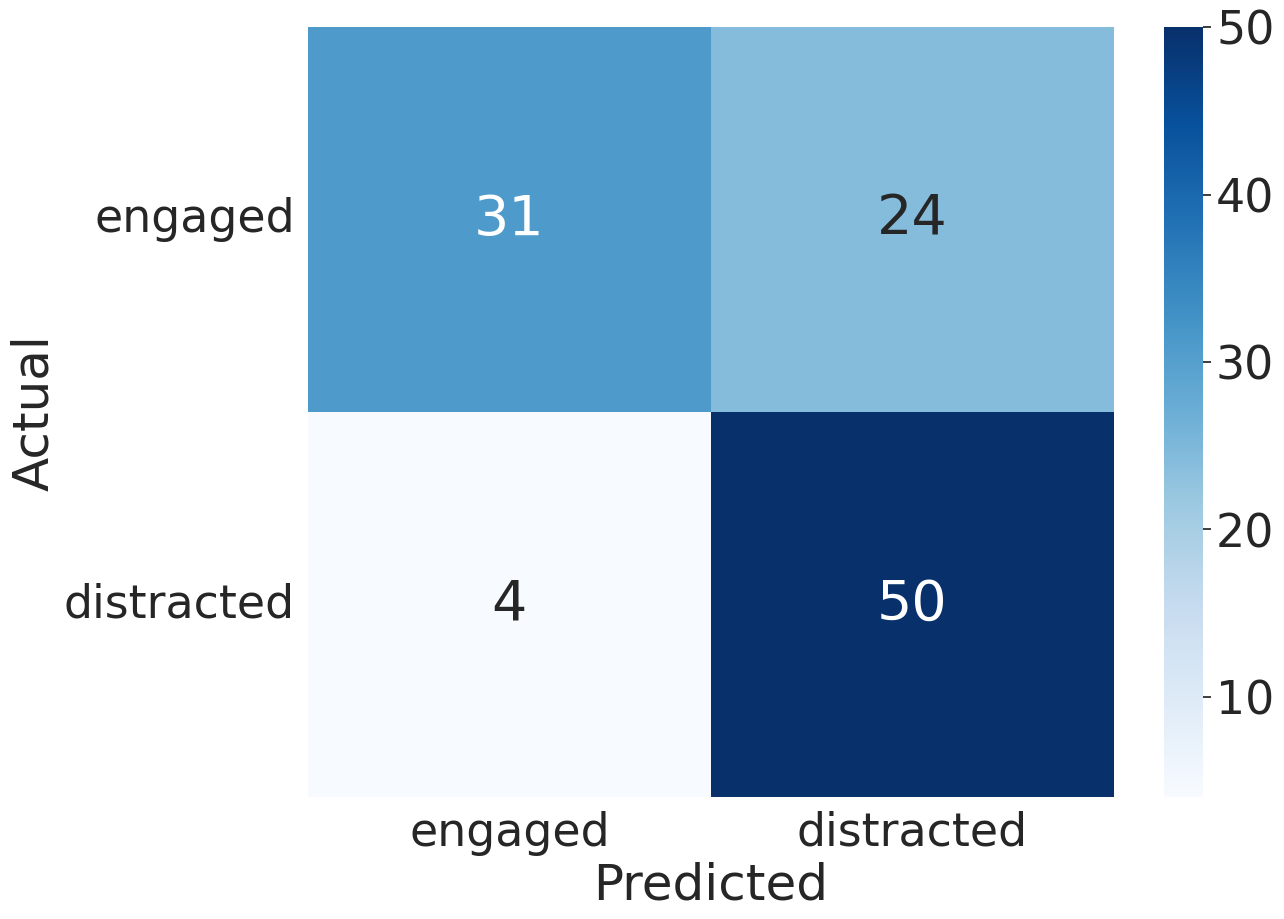

In [35]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [36]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [37]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


2024-08-14 21:32:16.223824: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f50580bff30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-14 21:32:16.223990: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-08-14 21:32:16.228202: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-14 21:32:16.273424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-08-14 21:32:16.325263: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in fut

Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6909090909090909, Precision: 0.9099999999999999, F1: 0.7084739454094293
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909091, Precision: 0.9040404040404042, F1: 0.7259232721301687
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7272727272727273, Precision: 0.9040404040404042, F1: 0.744256605463502
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7272727272727273, Precision: 0.9040404040404042, F1: 0.744256605463502
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7272727272727273, Precision: 0.8976076555023923, F1: 0.7391991341991342
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7272727272727273, Precision: 0.9040404040404042, F1: 0.744256605463502
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909091, Precision: 0.9040404040404042, F1: 0.7259232721301687
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.9022222222222223, F1: 0.7155336617405583
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909091, Precision: 0.9040404040404042, F1: 0.7259232721301687
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7272727272727273, Precision: 0.9040404040404042, F1: 0.744256605463502


In [38]:
if False:
    draw_loss_acc_graphs(history)

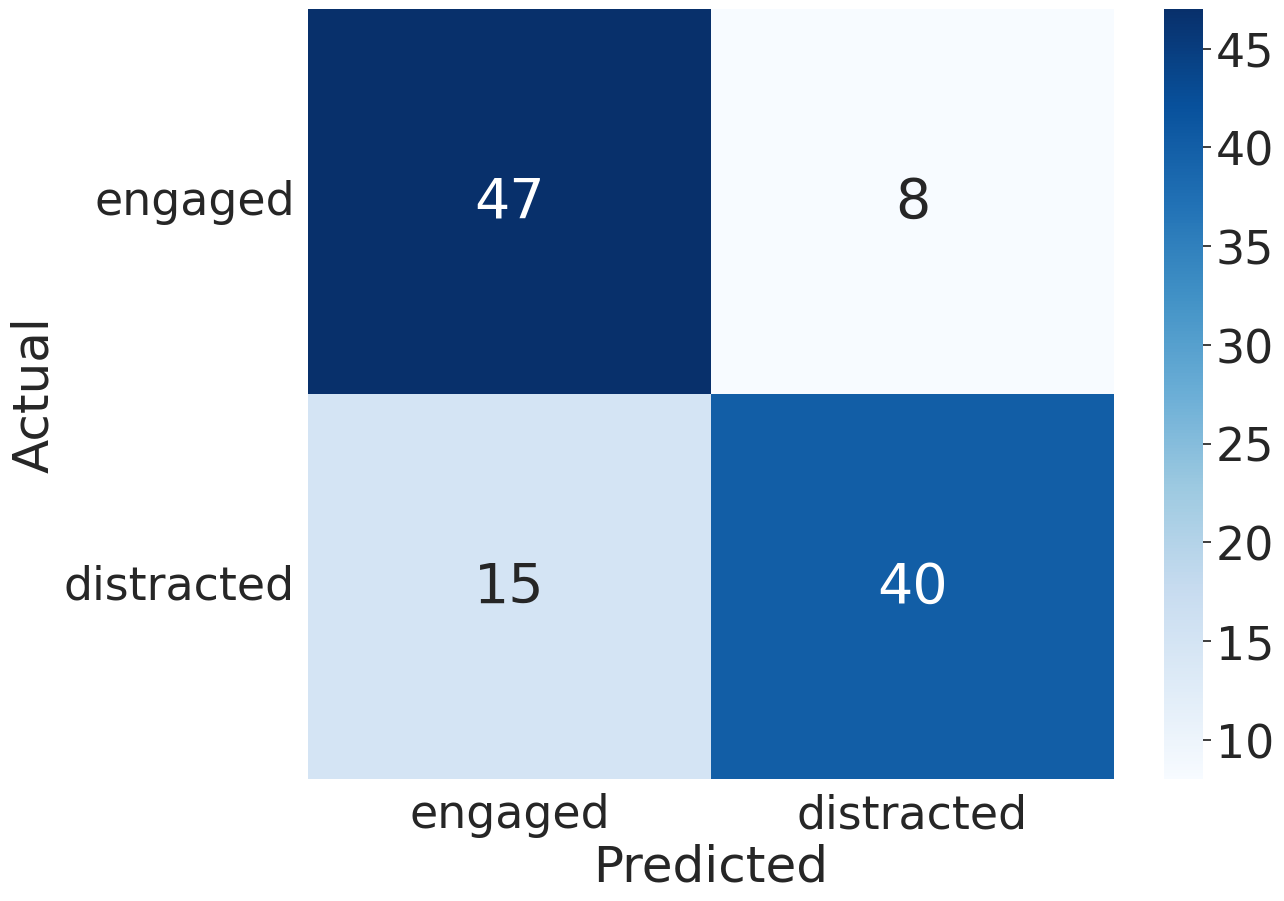

In [39]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [40]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5454545454545455, Precision: 0.7636363636363637, F1: 0.6136363636363636
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.6727272727272726, Precision: 0.95, F1: 0.7052173913043479
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.905, F1: 0.6779100529100528
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.5272727272727273, Precision: 0.7636363636363637, F1: 0.5953030303030303
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6909090909090909, Precision: 0.9651515151515152, F1: 0.741327657849397
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.905, F1: 0.6779100529100528
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.5272727272727273, Precision: 0.7636363636363637, F1: 0.5953030303030303
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.9651515151515152, F1: 0.7596609911827303
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.905, F1: 0.6779100529100528
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.5272727272727273, Precision: 0.7636363636363637, F1: 0.5953030303030303
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.6727272727272726, Precision: 0.95, F1: 0.7052173913043479
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.905, F1: 0.7061151811151811
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.5272727272727273, Precision: 0.7636363636363637, F1: 0.5953030303030303
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.6545454545454545, Precision: 0.9636363636363636, F1: 0.7036363636363636
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.905, F1: 0.7061151811151811
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.5454545454545455, Precision: 0.78, F1: 0.6214285714285714
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.6727272727272727, Precision: 0.9636363636363636, F1: 0.7318414918414918
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.905, F1: 0.7061151811151811
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.5636363636363637, Precision: 0.7666666666666667, F1: 0.6239130434782608
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.6909090909090909, Precision: 0.95, F1: 0.733422519509476
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.905, F1: 0.6779100529100528
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.5454545454545455, Precision: 0.78, F1: 0.6214285714285714
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6909090909090909, Precision: 0.9651515151515152, F1: 0.741327657849397
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6545454545454545, Precision: 0.925, F1: 0.6864814814814815
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.5454545454545455, Precision: 0.78, F1: 0.6214285714285714
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6909090909090909, Precision: 0.9651515151515152, F1: 0.741327657849397
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6545454545454545, Precision: 0.9228571428571428, F1: 0.6897619047619048
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.23333333333333334
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.5454545454545455, Precision: 0.78, F1: 0.6214285714285714
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.7090909090909091, Precision: 0.95, F1: 0.7575983436853002
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.905, F1: 0.6779100529100528


In [41]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [42]:
split_name = 'balanced_best'

In [43]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [44]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [45]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [46]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [47]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [48]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [49]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [50]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_balanced_best_Den_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_balanced_best_Kate_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.7272727272727273 Precision:  0.5714285714285714 F1:  0.64
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_balanced_best_Yana_0 Accuracy:  0.5714285714285714 MSE:  0.42857142857142855 UAR:  0.5818181818181818 Recall:  0.8 Precision:  0.5333333333333333 F1:  0.64
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_balanced_best_Egor_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_balanced_best_Katya_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Total, accuracy: 0.787012987012987, MSE: 0.212987012987013, UAR: 0.7890909090909091, Recall: 0.850909090909091, Precision: 0.7876190476190476, F1: 0.8070297482837528


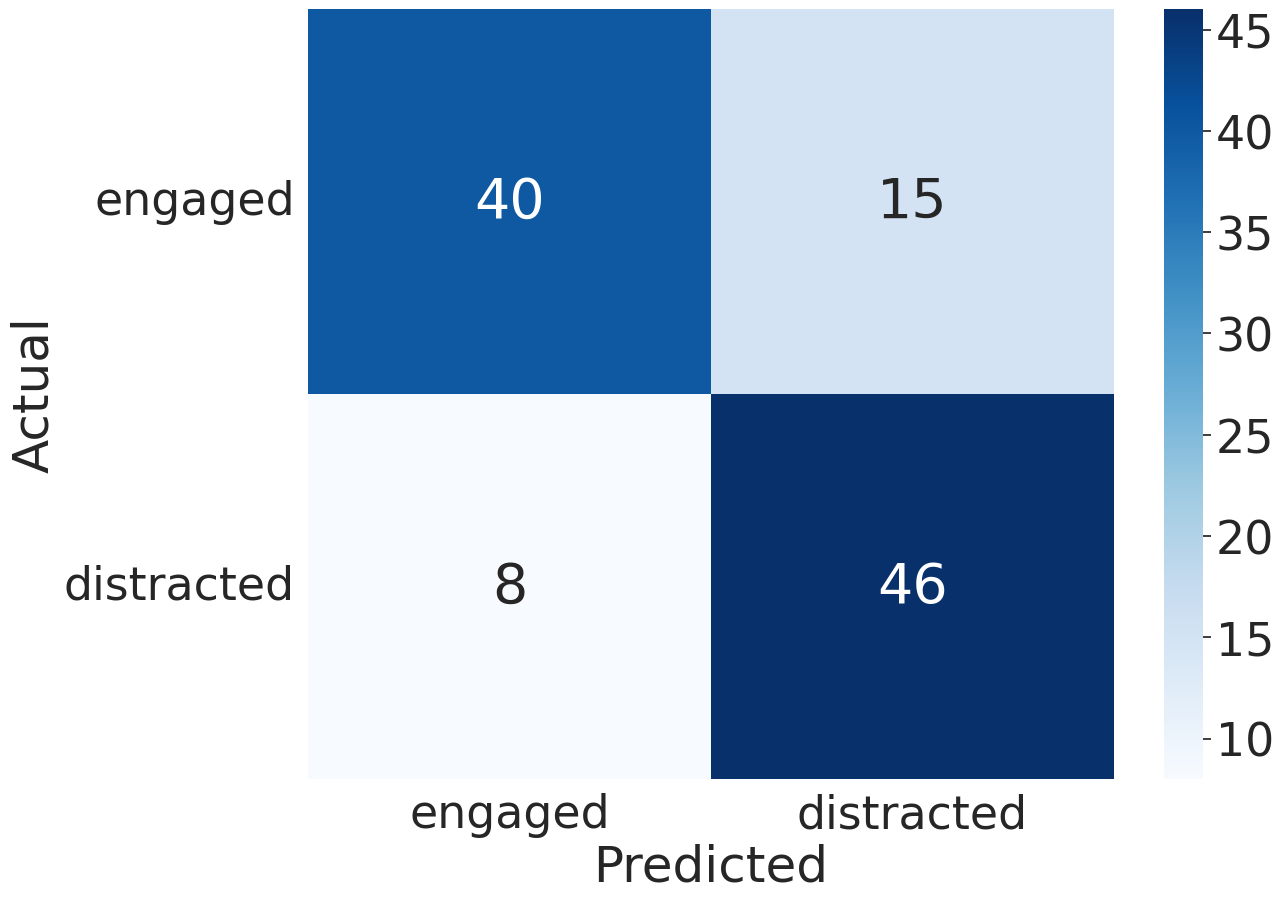

In [51]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [52]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [53]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7818181818181819, Precision: 0.7754435107376283, F1: 0.7591746031746032
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.8090909090909092, Recall: 0.8363636363636363, Precision: 0.8097069597069597, F1: 0.8167660455486543
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.8090909090909092, Recall: 0.8363636363636363, Precision: 0.7991008991008991, F1: 0.8120606060606061
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8363636363636363, Precision: 0.8152625152625153, F1: 0.8193333333333334
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8363636363636363, Precision: 0.8406593406593407, F1: 0.8282222222222222
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.8406593406593407, F1: 0.8186984126984127
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.8090909090909092, Recall: 0.8363636363636363, Precision: 0.8097069597069597, F1: 0.8167660455486543
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8097069597069597, F1: 0.7923216011042097
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8097069597069597, F1: 0.8018454106280192
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.8527472527472529, F1: 0.8260317460317459


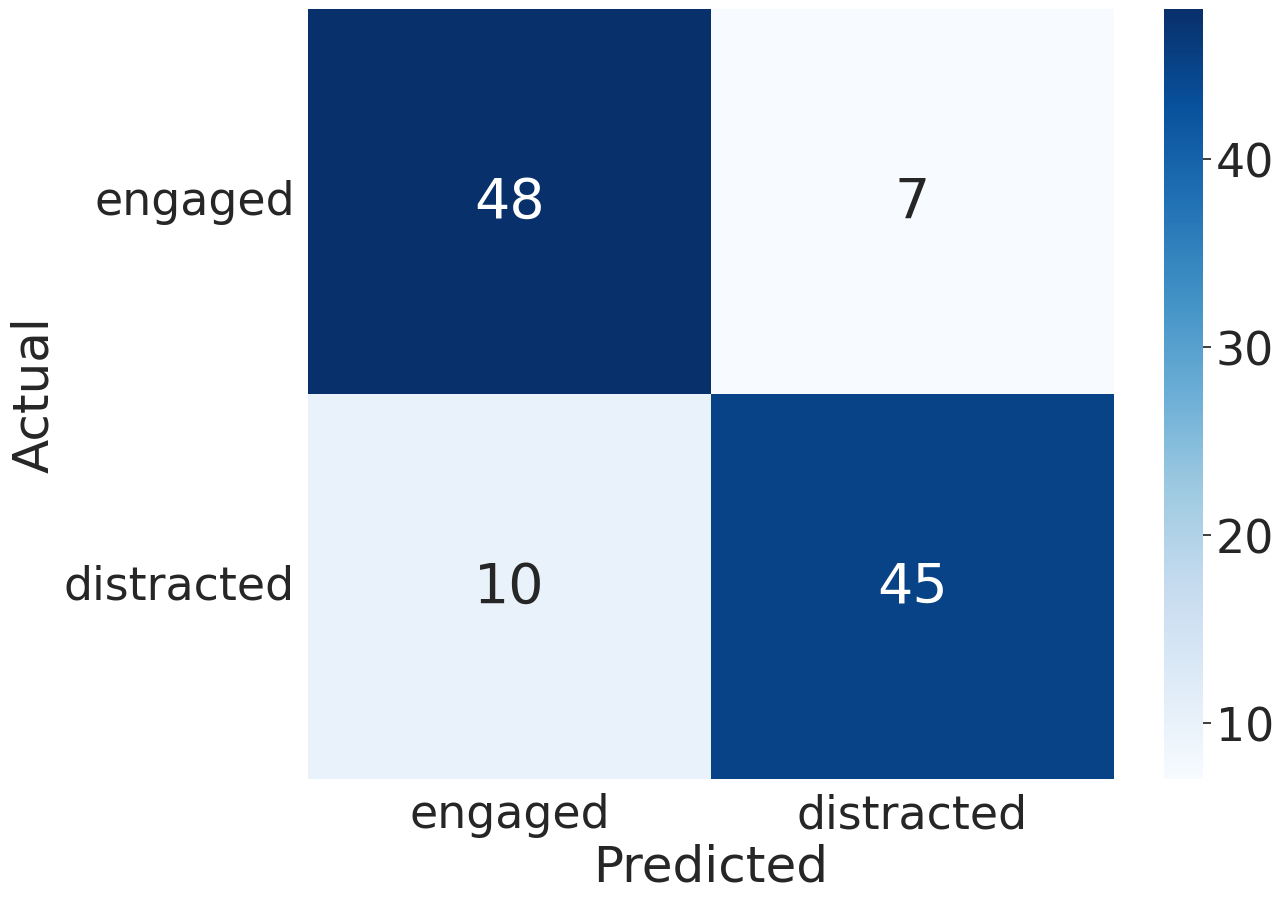

In [54]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [55]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.252014652014652
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7633333333333333, F1: 0.7311539718862374
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7636363636363637, Precision: 0.7993181818181818, F1: 0.7632021974127238
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7636363636363637, Precision: 0.938961038961039, F1: 0.7877776959882222
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.23636363636363633, Precision: 0.4, F1: 0.2761904761904762
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6909090909090909, Precision: 0.7611111111111111, F1: 0.7197254004576659
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7636363636363637, Precision: 0.7993181818181818, F1: 0.7632021974127238
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7454545454545455, Precision: 0.938961038961039, F1: 0.7782538864644127
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6909090909090909, Precision: 0.7611111111111111, F1: 0.7197254004576659
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7454545454545455, Precision: 0.8193181818181818, F1: 0.7536700336700337
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7636363636363637, Precision: 0.938961038961039, F1: 0.7877776959882222
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7611111111111111, F1: 0.731304347826087
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.7454545454545455, Precision: 0.8526515151515153, F1: 0.7574795574795574
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.7272727272727273, Precision: 0.938961038961039, F1: 0.7500487582592846
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7611111111111111, F1: 0.731304347826087
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7454545454545455, Precision: 0.8193181818181818, F1: 0.7536700336700337
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7636363636363637, Precision: 0.938961038961039, F1: 0.7711515151515151
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7611111111111111, F1: 0.731304347826087
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7636363636363637, Precision: 0.7993181818181818, F1: 0.7632021974127238
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7636363636363637, Precision: 0.938961038961039, F1: 0.7877776959882222
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7611111111111111, F1: 0.731304347826087
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.7636363636363637, Precision: 0.8193181818181818, F1: 0.7665355307460571
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7454545454545455, Precision: 0.938961038961039, F1: 0.7782538864644127
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.27272727272727276, Precision: 0.6, F1: 0.3190476190476191
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7611111111111111, F1: 0.731304347826087
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.7993181818181818, F1: 0.7947811447811448
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7818181818181819, Precision: 0.938961038961039, F1: 0.7993566433566434
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7090909090909091, Precision: 0.7611111111111111, F1: 0.731304347826087
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727276, UAR: 0.8272727272727274, Recall: 0.7636363636363637, Precision: 0.8284848484848485, F1: 0.7618181818181817
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7636363636363637, Precision: 0.938961038961039, F1: 0.7877776959882222
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7272727272727273, Precision: 0.7633333333333333, F1: 0.7427329192546583
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.7818181818181819, Precision: 0.8193181818181818, F1: 0.7837904327068415
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7636363636363637, Precision: 0.938961038961039, F1: 0.7877776959882222


In [56]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### Max

In [57]:
stat_func = np.max
stat_name = "max"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [58]:
classificator_name = 'single_attention'

#### Traditional split

In [59]:
split_name = 'traditional_best'

In [60]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [61]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [62]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [63]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [64]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [65]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [66]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [67]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_traditional_best_Den_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_traditional_best_Kate_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_traditional_best_Yana_0 Accuracy:  0.47619047619047616 MSE:  0.5238095238095238 UAR:  0.4954545454545455 Recall:  0.9 Precision:  0.47368421052631576 F1:  0.6206896551724138
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_traditional_best_Egor_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.7272727272727273 Precision:  0.7272727272727273 F1:  0.7272727272727273
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_traditional_best_Katya_0 Accuracy:  1.0 MSE:  0.0 UAR:  1.0 Recall:  1.0 Precision:  1.0 F1:  1.0
Total, accuracy: 0.786147186147186, MSE: 0.21385281385281382, UAR: 0.79, Recall: 0.889090909090909, Precision: 0.7868580542264754, F1: 0.8188232457197975


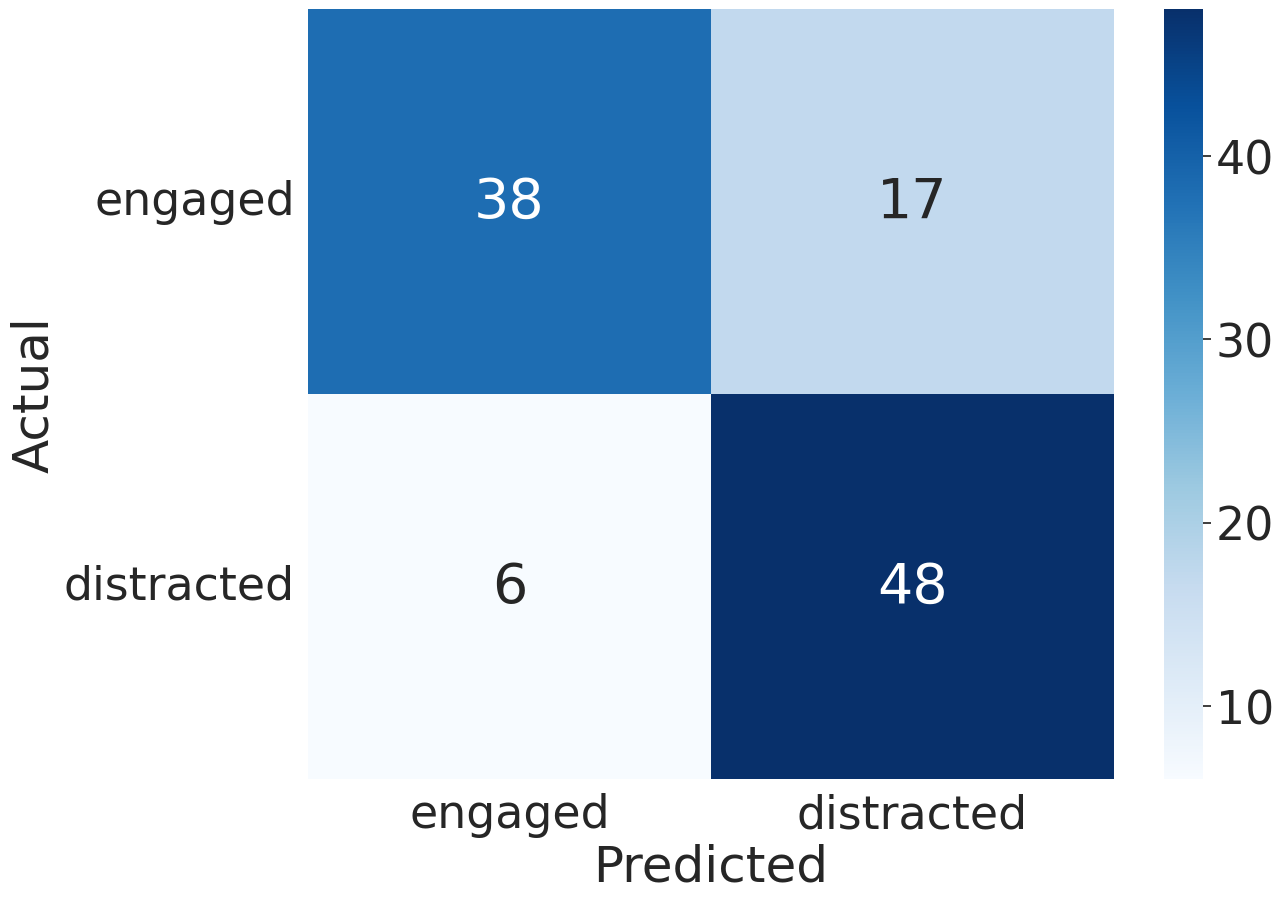

In [68]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [69]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [70]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6636363636363636, MSE: 0.3363636363636363, UAR: 0.6636363636363637, Recall: 0.7090909090909092, Precision: 0.7666666666666666, F1: 0.6853441295546558
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.690909090909091, Recall: 0.7272727272727273, Precision: 0.7766666666666666, F1: 0.7055252274607113
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.690909090909091, Precision: 0.7766666666666666, F1: 0.6844224705684807
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.7090909090909092, Precision: 0.7766666666666666, F1: 0.6960014179369018
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.7090909090909092, Precision: 0.7766666666666666, F1: 0.6939462800922903
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.690909090909091, Precision: 0.7766666666666666, F1: 0.6844224705684807
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.7090909090909092, Precision: 0.7766666666666666, F1: 0.6939462800922903
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.7090909090909092, Precision: 0.7849999999999999, F1: 0.6963882825342929
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.690909090909091, Precision: 0.7766666666666666, F1: 0.6844224705684807
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.690909090909091, Precision: 0.7766666666666666, F1: 0.6844224705684807


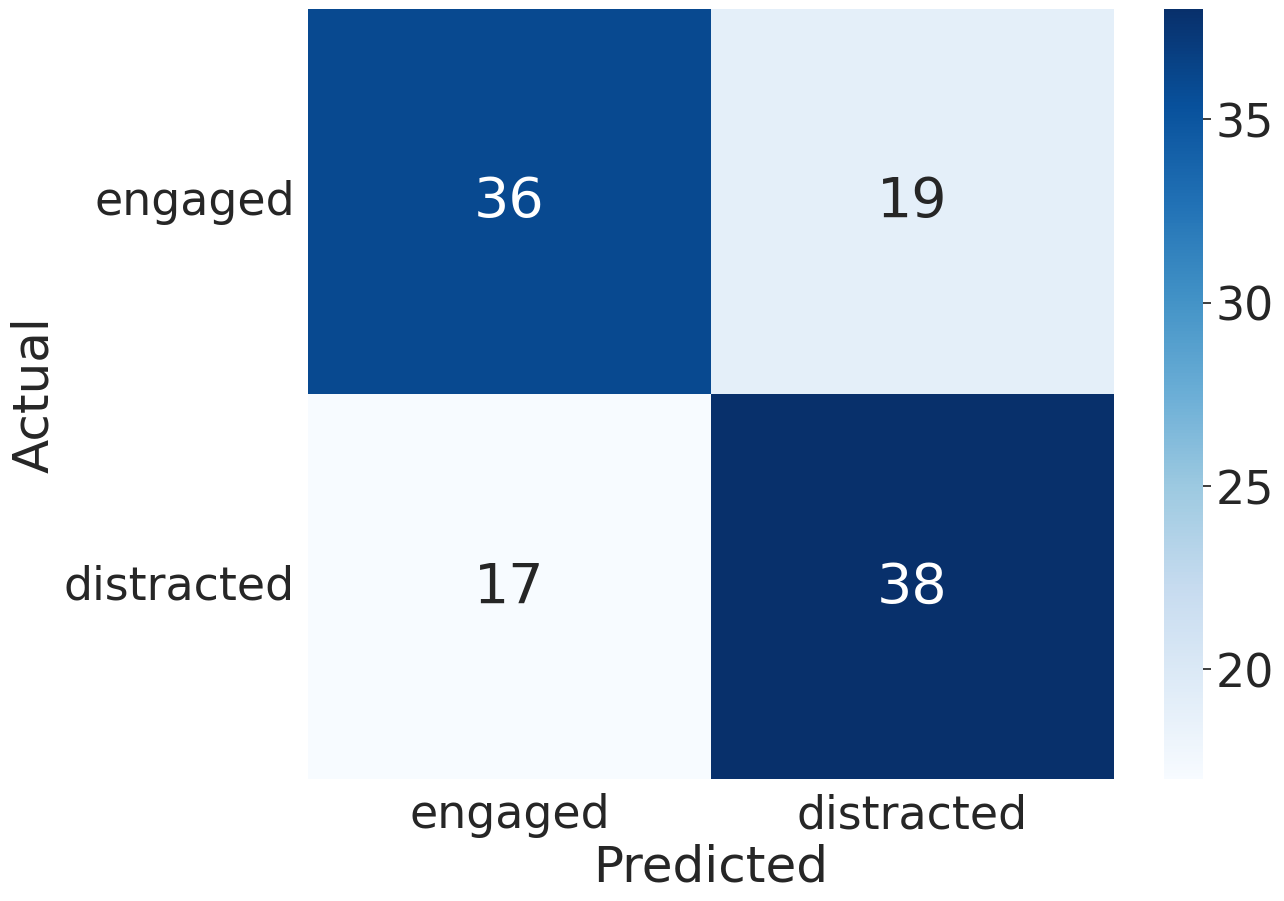

In [71]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [72]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.5454545454545455, Precision: 0.8, F1: 0.6221428571428571
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909092, Precision: 0.8277777777777778, F1: 0.7379710144927536
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.7971428571428572, F1: 0.6876666666666666
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.3363636363636363, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.6, F1: 0.3817543859649123
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.5454545454545455, Precision: 0.8, F1: 0.6221428571428571
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909092, Precision: 0.8277777777777778, F1: 0.7379710144927536
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.8238095238095238, F1: 0.7097254901960784
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6, Precision: 0.8, F1: 0.6622222222222222
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909092, Precision: 0.8277777777777778, F1: 0.7379710144927536
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8038095238095238, F1: 0.7003418803418804
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.5454545454545455, Precision: 0.8, F1: 0.6221428571428571
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.8277777777777778, F1: 0.7170186335403728
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.8133333333333332, F1: 0.7029562594268477
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.5454545454545455, Precision: 0.8, F1: 0.6221428571428571
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909092, Precision: 0.8277777777777778, F1: 0.7379710144927536
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.8133333333333332, F1: 0.7029562594268477
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5636363636363637, Precision: 0.8, F1: 0.6383193277310925
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.8277777777777778, F1: 0.7170186335403728
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8038095238095238, F1: 0.7003418803418804
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6, Precision: 0.8, F1: 0.6655639097744361
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.8277777777777778, F1: 0.7170186335403728
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.8133333333333332, F1: 0.7029562594268477
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.6181818181818182, Precision: 0.8, F1: 0.6750877192982456
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909092, Precision: 0.8277777777777778, F1: 0.7379710144927536
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.8142857142857143, F1: 0.707111111111111
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.5454545454545455, Precision: 0.8, F1: 0.6221428571428571
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.8277777777777778, F1: 0.7170186335403728
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8038095238095238, F1: 0.7003418803418804
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.3090909090909091, Precision: 0.6, F1: 0.36888888888888893
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5636363636363637, Precision: 0.8, F1: 0.6383193277310925
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909092, Precision: 0.8277777777777778, F1: 0.7379710144927536
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.8142857142857143, F1: 0.707111111111111


In [73]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [74]:
split_name = 'balanced_best'

In [75]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [76]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [77]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [78]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [79]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [80]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [81]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [82]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_balanced_best_Den_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_balanced_best_Kate_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.9090909090909091 Precision:  0.6666666666666666 F1:  0.7692307692307692
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_balanced_best_Yana_0 Accuracy:  0.5714285714285714 MSE:  0.42857142857142855 UAR:  0.5863636363636364 Recall:  0.9 Precision:  0.5294117647058824 F1:  0.6666666666666667
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_balanced_best_Egor_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_balanced_best_Katya_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Total, accuracy: 0.787012987012987, MSE: 0.21298701298701297, UAR: 0.79, Recall: 0.889090909090909, Precision: 0.764367201426025, F1: 0.8126829692047084


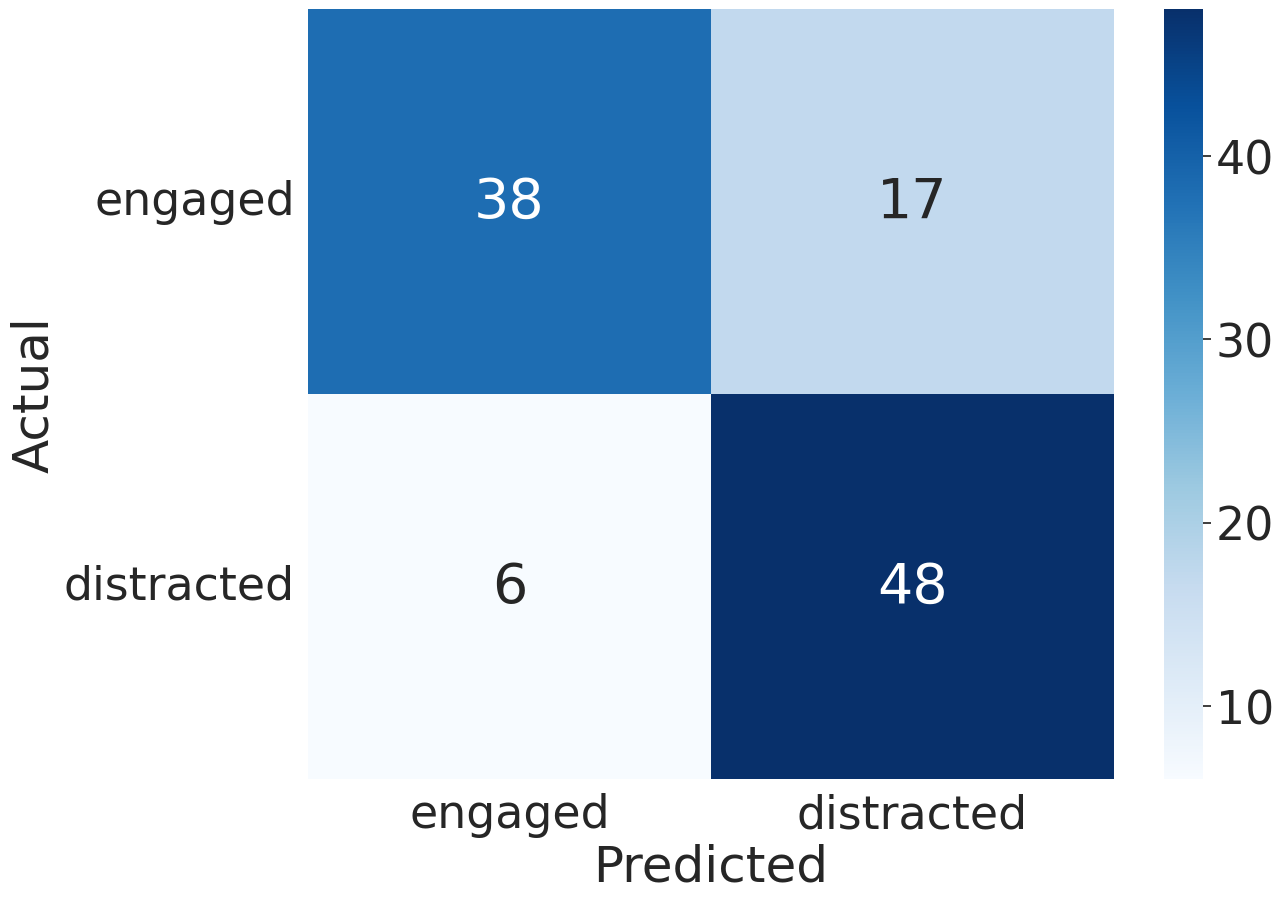

In [83]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [84]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [85]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7272727272727273, Precision: 0.8252913752913752, F1: 0.752364953886693
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7636363636363637, Precision: 0.85, F1: 0.7907416879795396
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8393939393939395, F1: 0.776512438967682


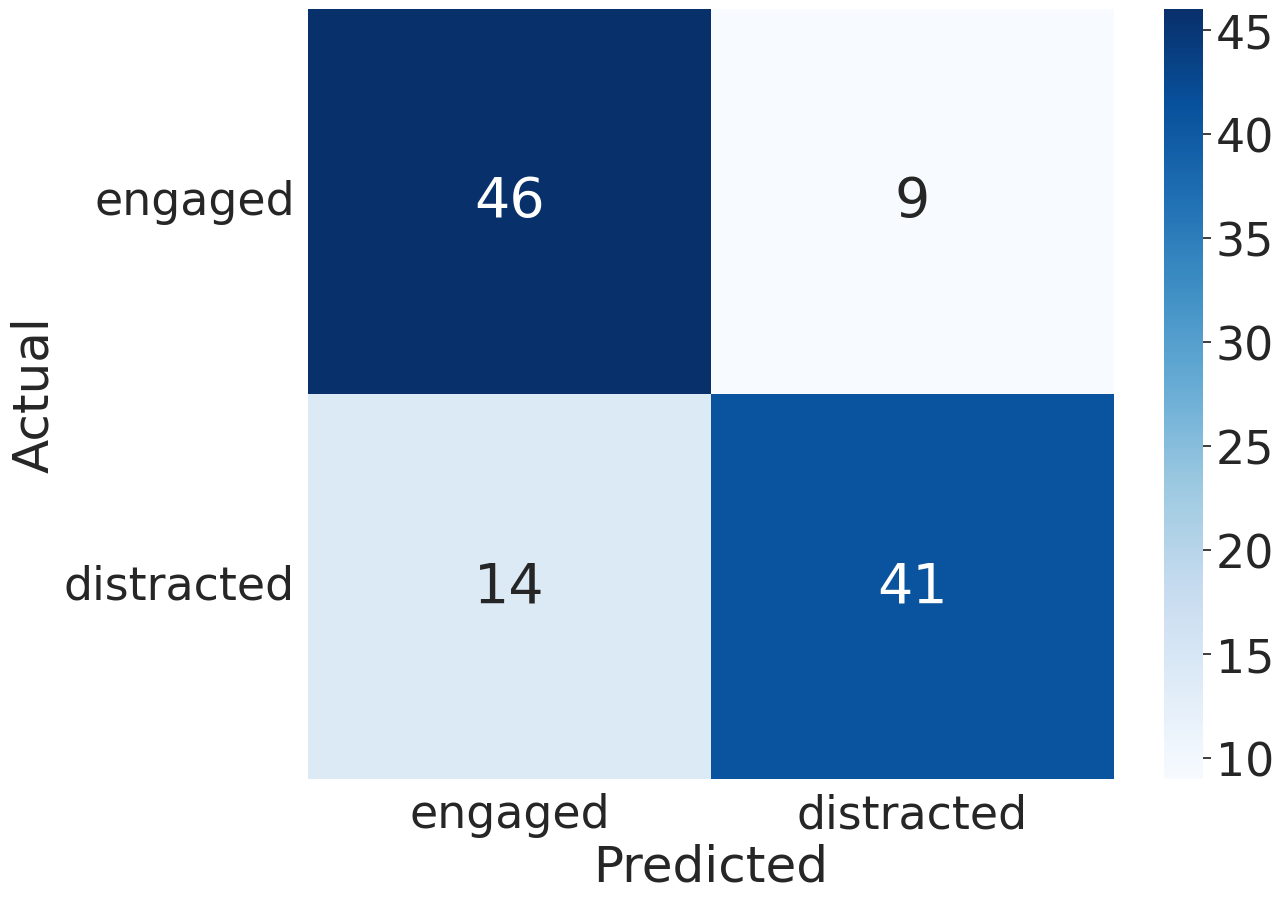

In [86]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [87]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.6363636363636364, Precision: 0.8, F1: 0.6954761904761905
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6727272727272727, Precision: 0.7818181818181819, F1: 0.7134708428826075
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6727272727272727, Precision: 0.7818181818181819, F1: 0.7134708428826075
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.6727272727272727, Precision: 0.7818181818181819, F1: 0.7134708428826075
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.6545454545454545, Precision: 0.8, F1: 0.7116526610644257
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.6545454545454545, Precision: 0.8, F1: 0.7116526610644257
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.7272727272727273, Precision: 0.8166666666666667, F1: 0.750451832907076
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.6545454545454545, Precision: 0.8, F1: 0.7116526610644257
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818183, MSE: 0.18181818181818182, UAR: 0.8181818181818183, Recall: 0.6363636363636364, Precision: 0.8, F1: 0.7000737136960047
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.6545454545454545, Precision: 0.8, F1: 0.7116526610644257
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.2909090909090909, Precision: 0.6, F1: 0.37238095238095237
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818183, MSE: 0.18181818181818182, UAR: 0.8181818181818183, Recall: 0.6363636363636364, Precision: 0.8, F1: 0.7000737136960047
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090908, Precision: 0.8151515151515152, F1: 0.7247891963109355
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6909090909090909, Precision: 0.8166666666666667, F1: 0.7247515527950311


In [88]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### STAT

In [89]:
stat_func = compute_descriptor
stat_name = "STAT"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [90]:
classificator_name = 'single_attention'

#### Traditional split

In [91]:
split_name = 'traditional_best'

In [92]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [93]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [94]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [95]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3840) (88,)


In [96]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3841      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [97]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [98]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [99]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_traditional_best_Den_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_traditional_best_Kate_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.9090909090909091 Precision:  0.7692307692307693 F1:  0.8333333333333333
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_traditional_best_Yana_0 Accuracy:  0.5238095238095238 MSE:  0.47619047619047616 UAR:  0.5409090909090909 Recall:  0.9 Precision:  0.5 F1:  0.6428571428571429
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_traditional_best_Egor_0 Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.8181818181818182 Precision:  0.5294117647058824 F1:  0.6428571428571428
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_traditional_best_Katya_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Total, accuracy: 0.732034632034632, MSE: 0.26796536796536796, UAR: 0.7354545454545455, Recall: 0.9254545454545454, Precision: 0.6897285067873302, F1: 0.78434464086638


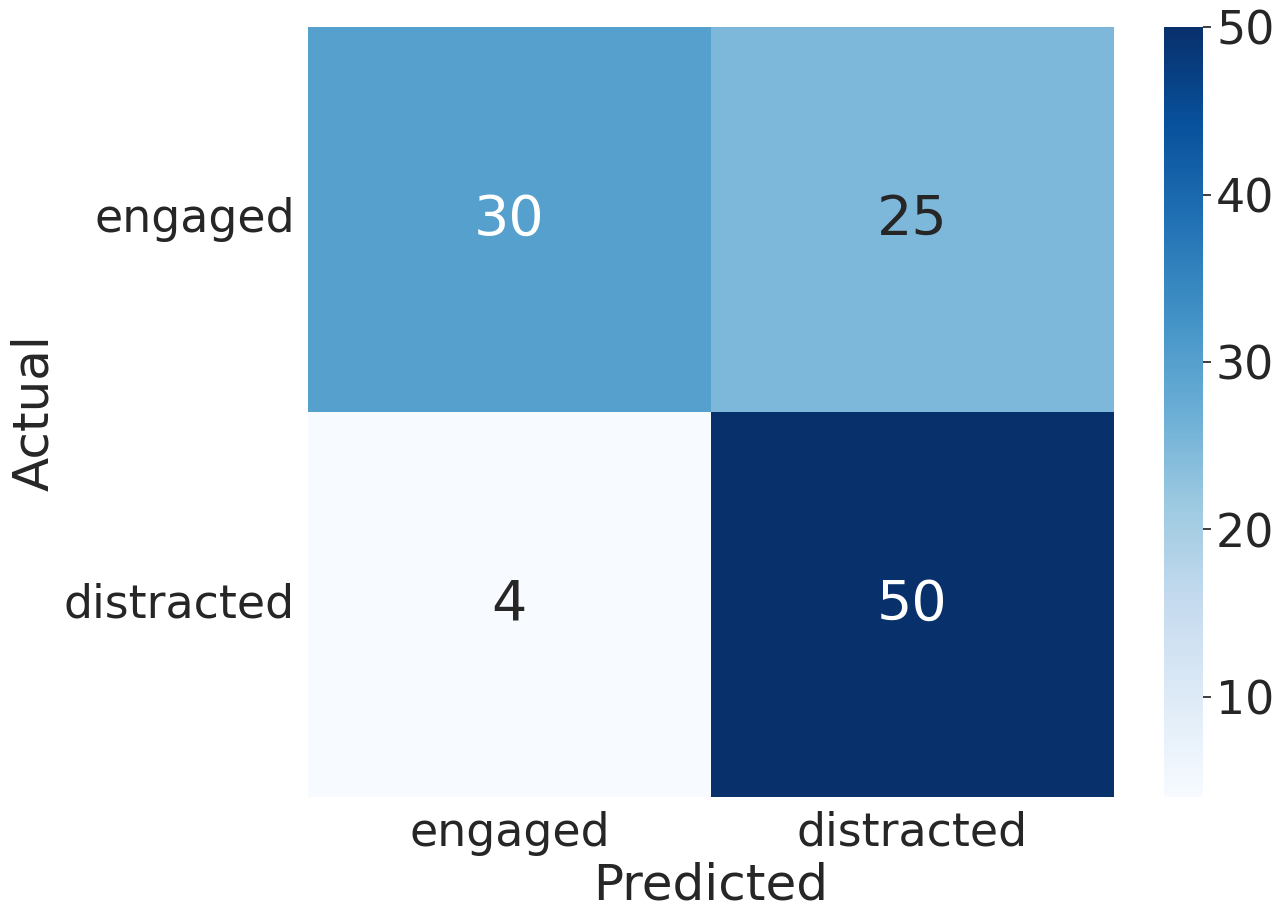

In [100]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [101]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [102]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7454545454545455, Precision: 0.8918181818181818, F1: 0.7554203323558163
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7636363636363637, Precision: 0.8991228070175439, F1: 0.7696376811594202
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7454545454545455, Precision: 0.8933333333333333, F1: 0.746573165030388
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.7636363636363637, Precision: 0.8266666666666665, F1: 0.7523574787558782
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7454545454545455, Precision: 0.8933333333333333, F1: 0.746573165030388
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7272727272727273, Precision: 0.8899999999999999, F1: 0.7450307219662059
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7636363636363637, Precision: 0.8933333333333333, F1: 0.7649064983637214
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7636363636363637, Precision: 0.8933333333333333, F1: 0.7649064983637214
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7454545454545455, Precision: 0.8933333333333333, F1: 0.746573165030388
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7454545454545455, Precision: 0.8933333333333333, F1: 0.746573165030388


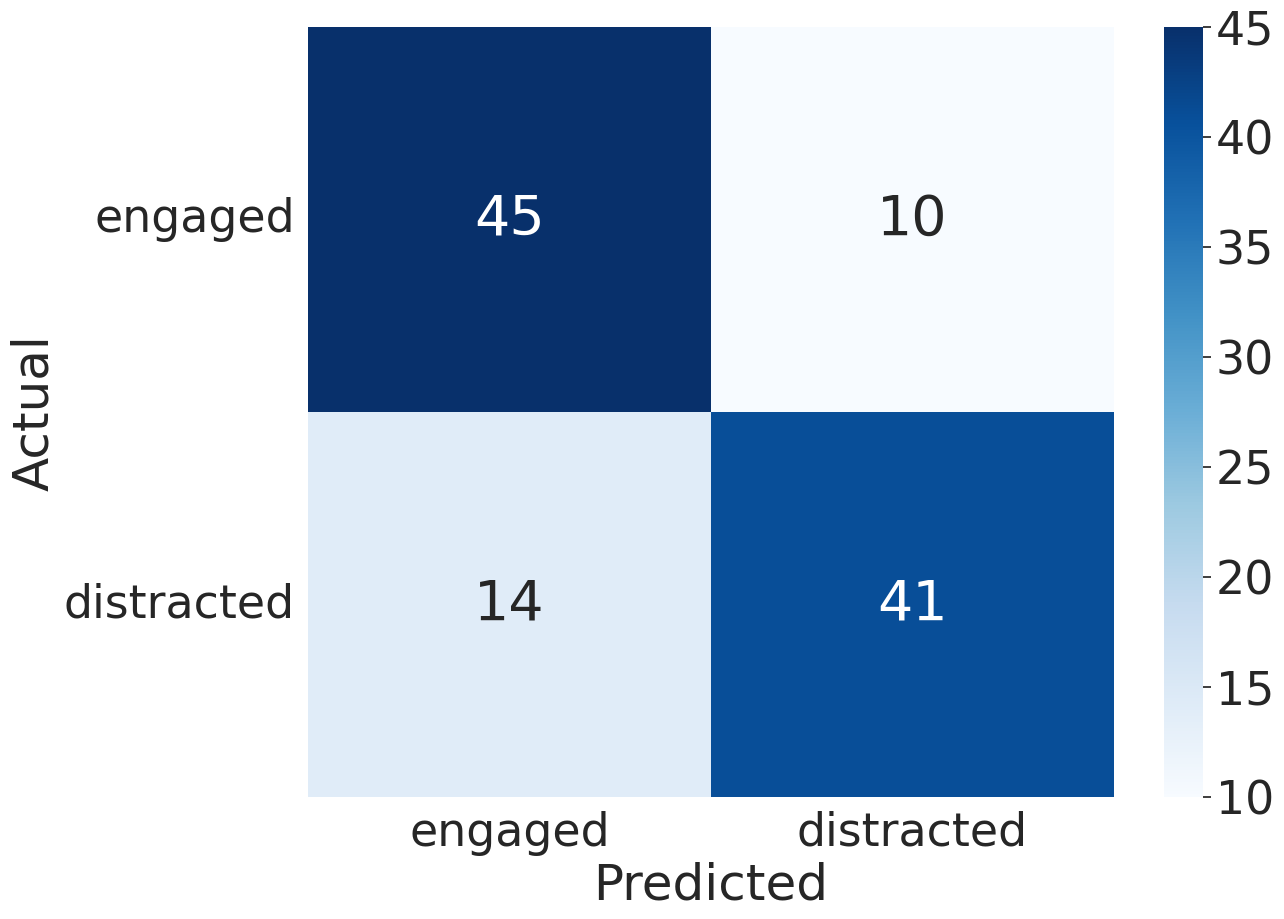

In [103]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [104]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.2, F1: 0.19047619047619047
Videos num:  2_1
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.6909090909090909, Recall: 0.4909090909090909, Precision: 0.725, F1: 0.5163532763532763
Videos num:  3_1
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.26363636363636367, UAR: 0.7363636363636363, Recall: 0.6, Precision: 0.9044117647058822, F1: 0.6275882012724118
Videos num:  4_1
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9157894736842106, F1: 0.6948717948717948
Videos num:  1_2
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.2, F1: 0.19047619047619047
Videos num:  2_2
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.6909090909090909, Recall: 0.47272727272727266, Precision: 0.7333333333333333, F1: 0.5010989010989011
Videos num:  3_2
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.26363636363636367, UAR: 0.7363636363636363, Recall: 0.6, Precision: 0.9044117647058822, F1: 0.6275882012724118
Videos num:  4_2
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.6999292661361627
Videos num:  1_3
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.2, F1: 0.19047619047619047
Videos num:  2_3
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909092, Recall: 0.4909090909090909, Precision: 0.7428571428571429, F1: 0.5282051282051282
Videos num:  3_3
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.6, Precision: 0.9125, F1: 0.6334083070925176
Videos num:  4_3
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.6999292661361627
Videos num:  1_4
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.2, F1: 0.19047619047619047
Videos num:  2_4
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.47272727272727266, Precision: 0.7428571428571429, F1: 0.5072527472527473
Videos num:  3_4
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.6, Precision: 0.9216666666666666, F1: 0.6396761133603238
Videos num:  4_4
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.6717241379310346
Videos num:  1_5
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_5
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.47272727272727266, Precision: 0.7428571428571429, F1: 0.5072527472527473
Videos num:  3_5
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.9288461538461539, F1: 0.6371120107962213
Videos num:  4_5
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.6717241379310346
Videos num:  1_6
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.2, F1: 0.19047619047619047
Videos num:  2_6
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.47272727272727266, Precision: 0.7428571428571429, F1: 0.5072527472527473
Videos num:  3_6
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6181818181818182, Precision: 0.9244444444444444, F1: 0.6523076923076923
Videos num:  4_6
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7090909090909091, Precision: 0.9222222222222222, F1: 0.7344390700577313
Videos num:  1_7
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_7
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.47272727272727266, Precision: 0.7428571428571429, F1: 0.5072527472527473
Videos num:  3_7
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.5818181818181818, Precision: 0.9178571428571429, F1: 0.6304453441295547
Videos num:  4_7
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6909090909090909, Precision: 0.9222222222222222, F1: 0.7182625994694961
Videos num:  1_8
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_8
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.47272727272727266, Precision: 0.7538461538461538, F1: 0.5139194139194139
Videos num:  3_8
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.6, Precision: 0.9125, F1: 0.6334083070925176
Videos num:  4_8
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6909090909090909, Precision: 0.9222222222222222, F1: 0.7182625994694961
Videos num:  1_9
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.2, F1: 0.2
Videos num:  2_9
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.47272727272727266, Precision: 0.7538461538461538, F1: 0.5139194139194139
Videos num:  3_9
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.9288461538461539, F1: 0.6371120107962213
Videos num:  4_9
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.6900574712643679
Videos num:  1_10
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.2, F1: 0.19047619047619047
Videos num:  2_10
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.47272727272727266, Precision: 0.7428571428571429, F1: 0.5072527472527473
Videos num:  3_10
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.6, Precision: 0.9125, F1: 0.6334083070925176
Videos num:  4_10
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.6717241379310346


In [105]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [106]:
split_name = 'balanced_best'

In [107]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [108]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [109]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [110]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3840) (88,)


In [111]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3841      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [112]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [113]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [114]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_balanced_best_Den_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_balanced_best_Kate_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_balanced_best_Yana_0 Accuracy:  0.5238095238095238 MSE:  0.47619047619047616 UAR:  0.5409090909090909 Recall:  0.9 Precision:  0.5 F1:  0.6428571428571429
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_balanced_best_Egor_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.8181818181818182 Precision:  0.6 F1:  0.6923076923076923
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_balanced_best_Katya_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Total, accuracy: 0.6683982683982684, MSE: 0.3316017316017316, UAR: 0.6718181818181819, Recall: 0.9436363636363637, Precision: 0.6111111111111112, F1: 0.7397120121258052


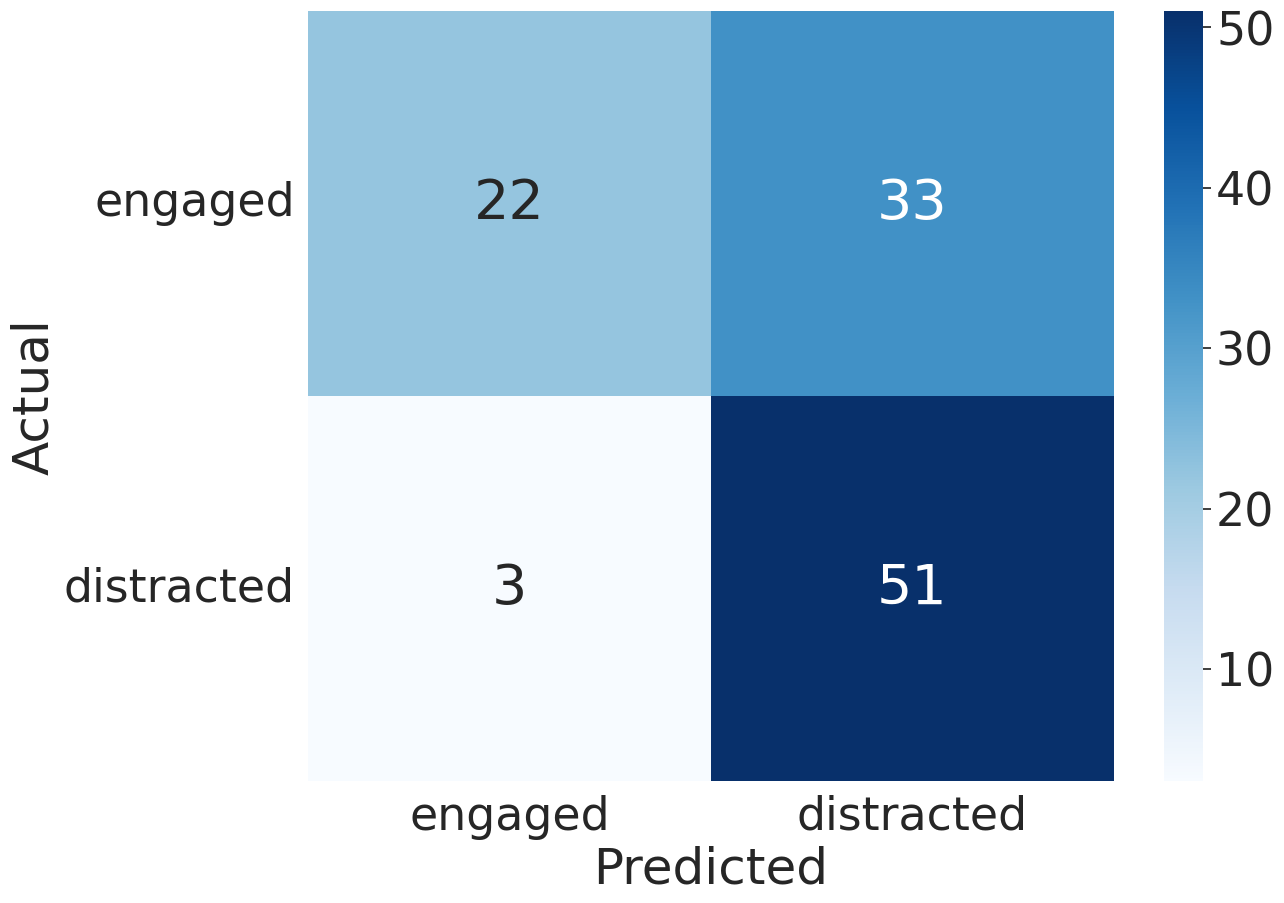

In [115]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [116]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [117]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.8, Precision: 0.8044444444444444, F1: 0.77441630228529
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454545, UAR: 0.7545454545454546, Recall: 0.7818181818181819, Precision: 0.7903418803418804, F1: 0.750268817204301
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.7818181818181819, Precision: 0.8044444444444444, F1: 0.7582398316970547
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454545, UAR: 0.7545454545454546, Recall: 0.7818181818181819, Precision: 0.7903418803418804, F1: 0.750268817204301
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.7818181818181819, Precision: 0.8044444444444444, F1: 0.7582398316970547
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.8, Precision: 0.7992307692307692, F1: 0.7645545314900153
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.7818181818181819, Precision: 0.8044444444444444, F1: 0.7582398316970547
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454545, UAR: 0.7545454545454546, Recall: 0.7818181818181819, Precision: 0.7903418803418804, F1: 0.750268817204301
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.8, Precision: 0.8133333333333332, F1: 0.7725255459827689
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.836190476190476, F1: 0.7693509428081657


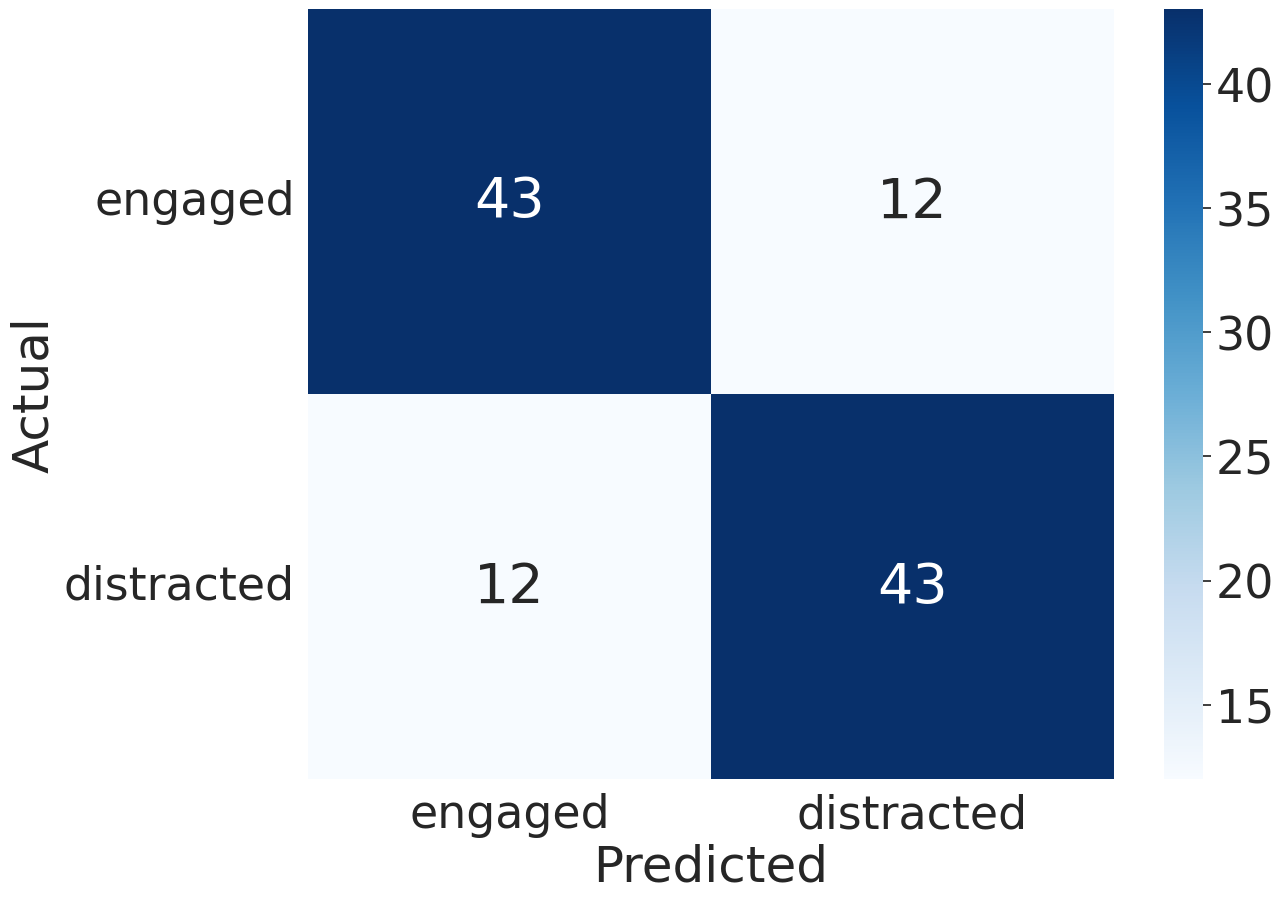

In [118]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [119]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_1
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818183, Recall: 0.5454545454545455, Precision: 0.7208333333333333, F1: 0.5649815965033357
Videos num:  3_1
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.26363636363636367, UAR: 0.7363636363636364, Recall: 0.6909090909090909, Precision: 0.796031746031746, F1: 0.6618856286142643
Videos num:  4_1
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_2
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_2
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.2636363636363636, UAR: 0.7363636363636364, Recall: 0.5454545454545455, Precision: 0.7404761904761904, F1: 0.5780186335403726
Videos num:  3_2
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_2
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_3
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_3
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_3
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_3
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_4
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_4
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_4
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_4
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_5
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_5
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_5
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_5
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_6
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_6
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_6
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_6
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7090909090909091, Precision: 0.9055555555555556, F1: 0.7144570571856929
Videos num:  1_7
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_7
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.5636363636363637, Precision: 0.7525641025641026, F1: 0.606304347826087
Videos num:  3_7
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_7
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.9055555555555556, F1: 0.6902812330098687
Videos num:  1_8
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_8
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_8
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_8
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_9
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.2363636363636364, Precision: 0.4, F1: 0.26153846153846155
Videos num:  2_9
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_9
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_9
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6727272727272727, Precision: 0.9040404040404042, F1: 0.6807950670019636
Videos num:  1_10
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.2545454545454545, Precision: 0.4, F1: 0.2857142857142857
Videos num:  2_10
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.5454545454545455, Precision: 0.7525641025641026, F1: 0.5853519668737059
Videos num:  3_10
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272727, Precision: 0.8204761904761904, F1: 0.6552164357381749
Videos num:  4_10
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.2272727272727273, UAR: 0.7727272727272727, Recall: 0.6909090909090909, Precision: 0.9055555555555556, F1: 0.6902812330098687


In [120]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

## MobileNet

In [121]:
base_model_key = 'mobilenet_7.h5'

In [122]:
engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
eng_file2features = load_features(engaged_pickle)
distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
dis_file2features = load_features(distracted_pickle)

In [123]:
video2label = get_video2label(list(eng_file2features.keys()), list(dis_file2features.keys()))

### Std

In [124]:
stat_func = np.std
stat_name = "std"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [125]:
classificator_name = 'single_attention'

#### Traditional split

In [126]:
split_name = 'traditional_best'

In [127]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [128]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [129]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [130]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [131]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [132]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [133]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [134]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_traditional_best_Den_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_traditional_best_Kate_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_traditional_best_Yana_0 Accuracy:  0.5238095238095238 MSE:  0.47619047619047616 UAR:  0.5363636363636364 Recall:  0.8 Precision:  0.5 F1:  0.6153846153846154
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_traditional_best_Egor_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.7272727272727273 Precision:  0.7272727272727273 F1:  0.7272727272727273
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_traditional_best_Katya_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Total, accuracy: 0.722943722943723, MSE: 0.27705627705627706, UAR: 0.7254545454545455, Recall: 0.9054545454545455, Precision: 0.6804218657159834, F1: 0.768702811431447


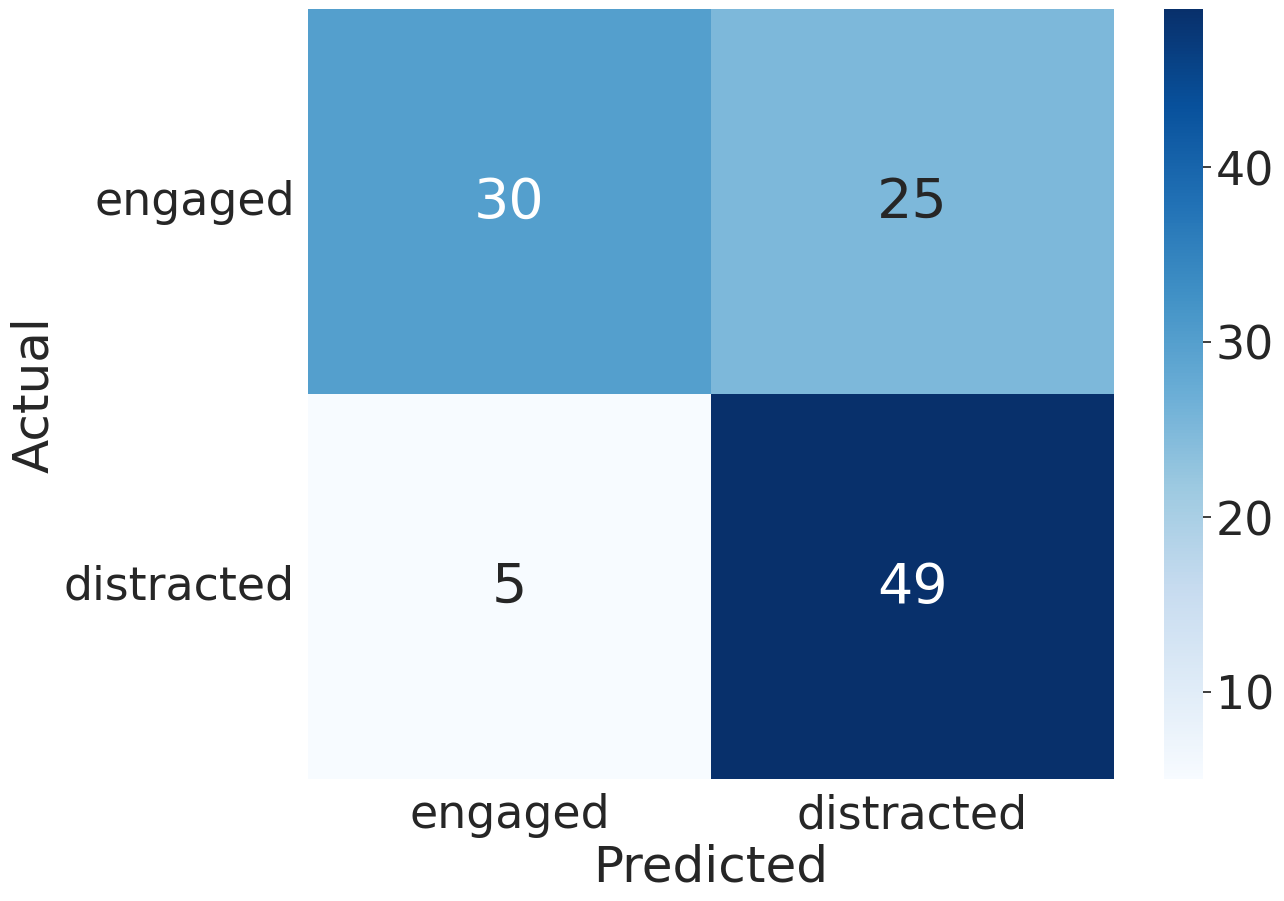

In [135]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [136]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [137]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8618181818181817, F1: 0.8277565571683219
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.8545454545454547, Precision: 0.8833333333333332, F1: 0.8296376811594204
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.8727272727272727, Precision: 0.8651515151515152, F1: 0.831455862977602
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8545454545454547, Precision: 0.8633333333333333, F1: 0.8210662525879918


In [138]:
if False:
    draw_loss_acc_graphs(history)

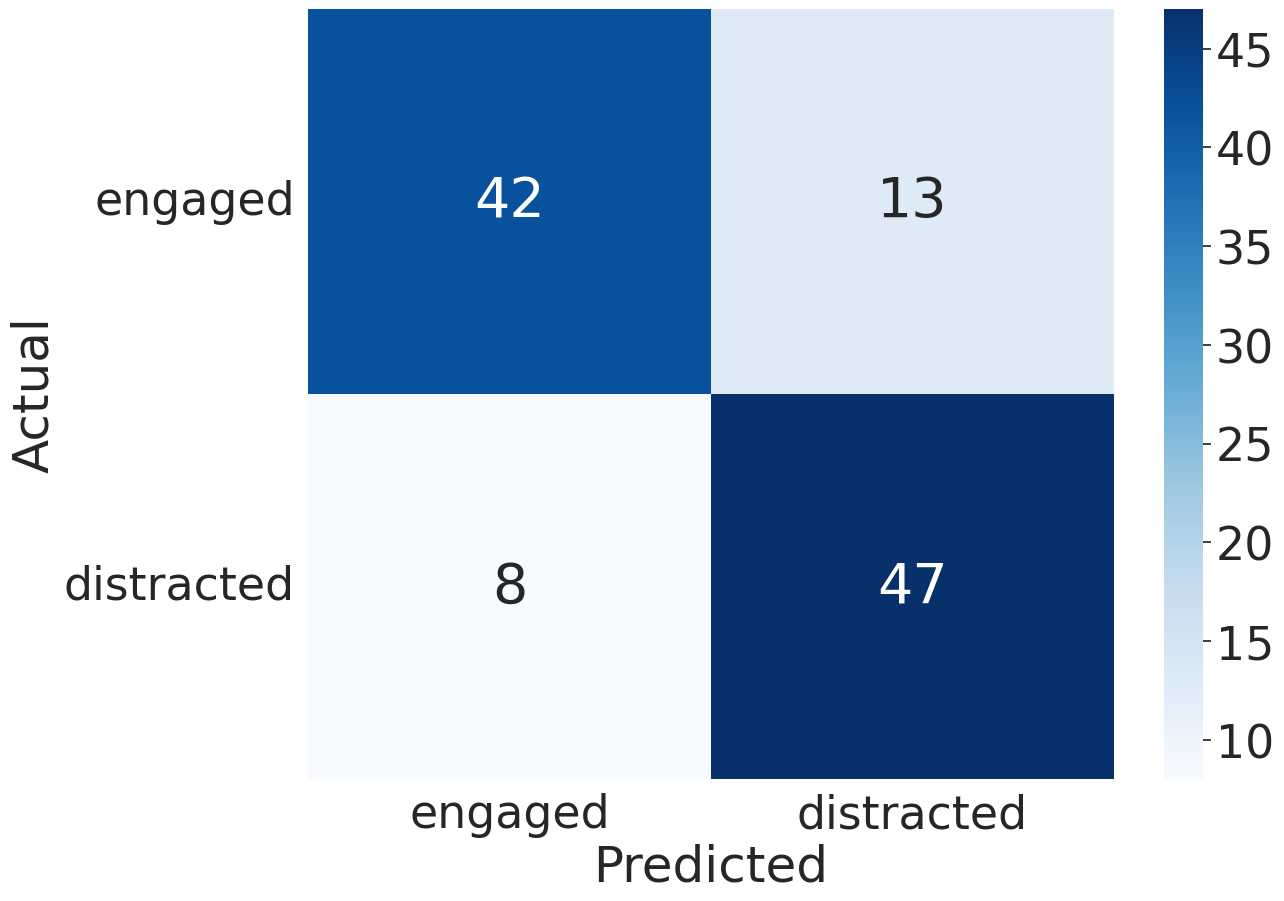

In [139]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [140]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7818181818181819, Precision: 0.8666666666666666, F1: 0.7637851662404092
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.7272727272727273, Precision: 0.8818181818181818, F1: 0.7258658008658009
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.7090909090909091, Precision: 0.86991341991342, F1: 0.6971609911827304
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.7272727272727273, Precision: 0.8880952380952379, F1: 0.7153428093645485
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.7090909090909091, Precision: 0.8865800865800866, F1: 0.7058566433566434
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.7090909090909091, Precision: 0.8865800865800866, F1: 0.7058566433566434
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.6727272727272726, Precision: 0.7047619047619047, F1: 0.6529761904761905
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.7090909090909091, Precision: 0.8865800865800866, F1: 0.7058566433566434
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.7272727272727273, Precision: 0.8880952380952379, F1: 0.7153428093645485
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.7090909090909091, Precision: 0.8865800865800866, F1: 0.7058566433566434
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.6727272727272726, Precision: 0.7047619047619047, F1: 0.6529761904761905
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454545, UAR: 0.7545454545454546, Recall: 0.7454545454545455, Precision: 0.8666666666666666, F1: 0.726656314699793
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.7272727272727273, Precision: 0.8880952380952379, F1: 0.7153428093645485
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.6909090909090909, Recall: 0.38181818181818183, Precision: 0.4, F1: 0.3904761904761905
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6727272727272726, Precision: 0.6880952380952381, F1: 0.6442805383022774
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7636363636363637, Precision: 0.8666666666666666, F1: 0.7428327852880281
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.2363636363636364, UAR: 0.7636363636363636, Recall: 0.7272727272727273, Precision: 0.8865800865800866, F1: 0.7300324675324676


In [141]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [142]:
split_name = 'balanced_best'

In [143]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [144]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [145]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [146]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [147]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [148]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [149]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [150]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_balanced_best_Den_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.7272727272727273 Precision:  0.6153846153846154 F1:  0.6666666666666667
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_balanced_best_Kate_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_balanced_best_Yana_0 Accuracy:  0.5714285714285714 MSE:  0.42857142857142855 UAR:  0.5818181818181818 Recall:  0.8 Precision:  0.5333333333333333 F1:  0.64
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_balanced_best_Egor_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.6363636363636364 Precision:  0.7 F1:  0.6666666666666666
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_balanced_best_Katya_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Total, accuracy: 0.6961038961038961, MSE: 0.3038961038961039, UAR: 0.6981818181818182, Recall: 0.8327272727272728, Precision: 0.6611965811965812, F1: 0.7297241379310344


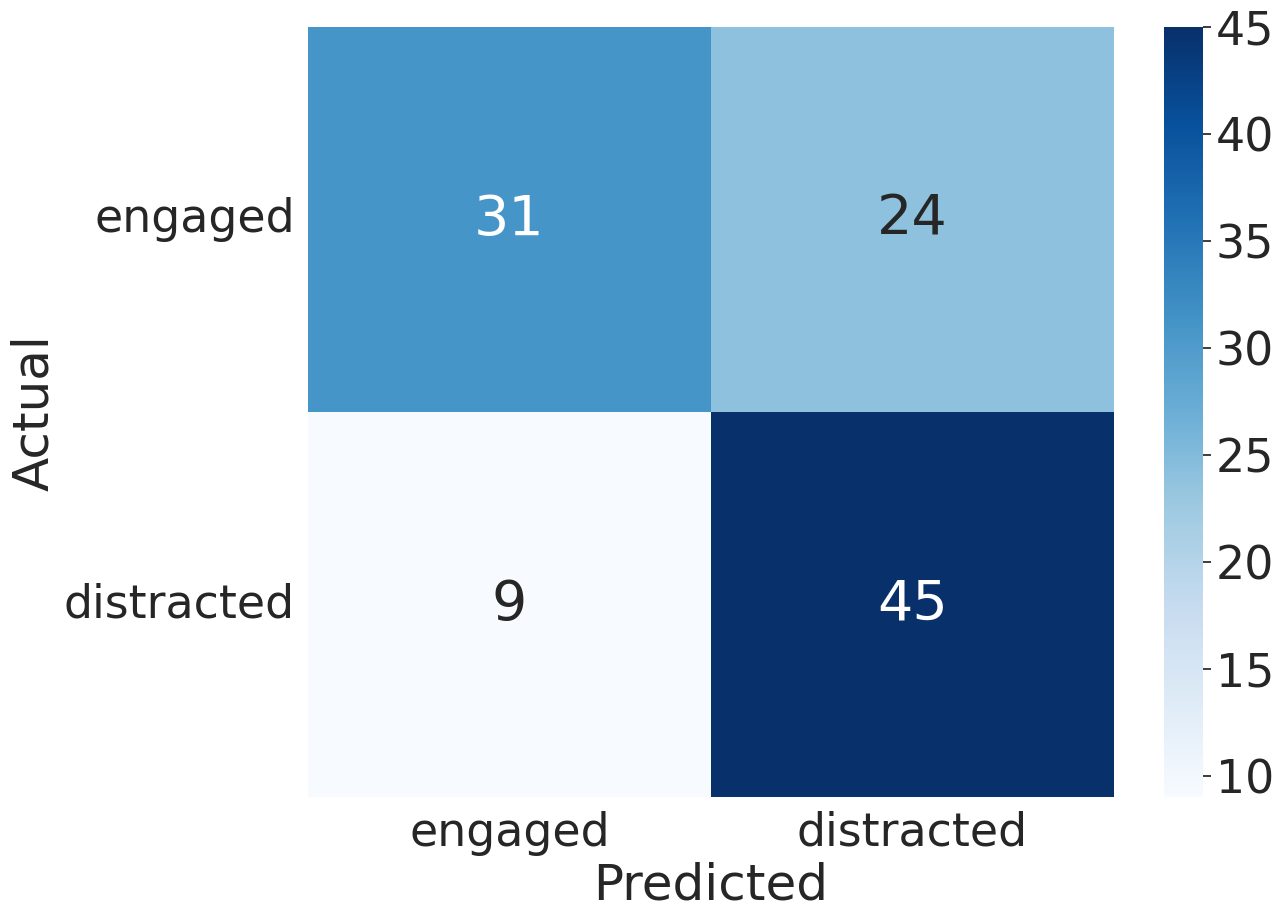

In [151]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [152]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [153]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8416666666666666, F1: 0.8188660055936945
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8416666666666666, F1: 0.8188660055936945
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8727272727272727, Precision: 0.8444444444444444, F1: 0.8314975845410627
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8727272727272727, Precision: 0.8444444444444444, F1: 0.8314975845410627
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8727272727272727, Precision: 0.8444444444444444, F1: 0.8314975845410627
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8727272727272727, Precision: 0.8444444444444444, F1: 0.8314975845410627
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8416666666666666, F1: 0.8188660055936945
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8416666666666666, F1: 0.8188660055936945
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8727272727272727, Precision: 0.8444444444444444, F1: 0.8314975845410627
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8727272727272727, Precision: 0.8444444444444444, F1: 0.8314975845410627


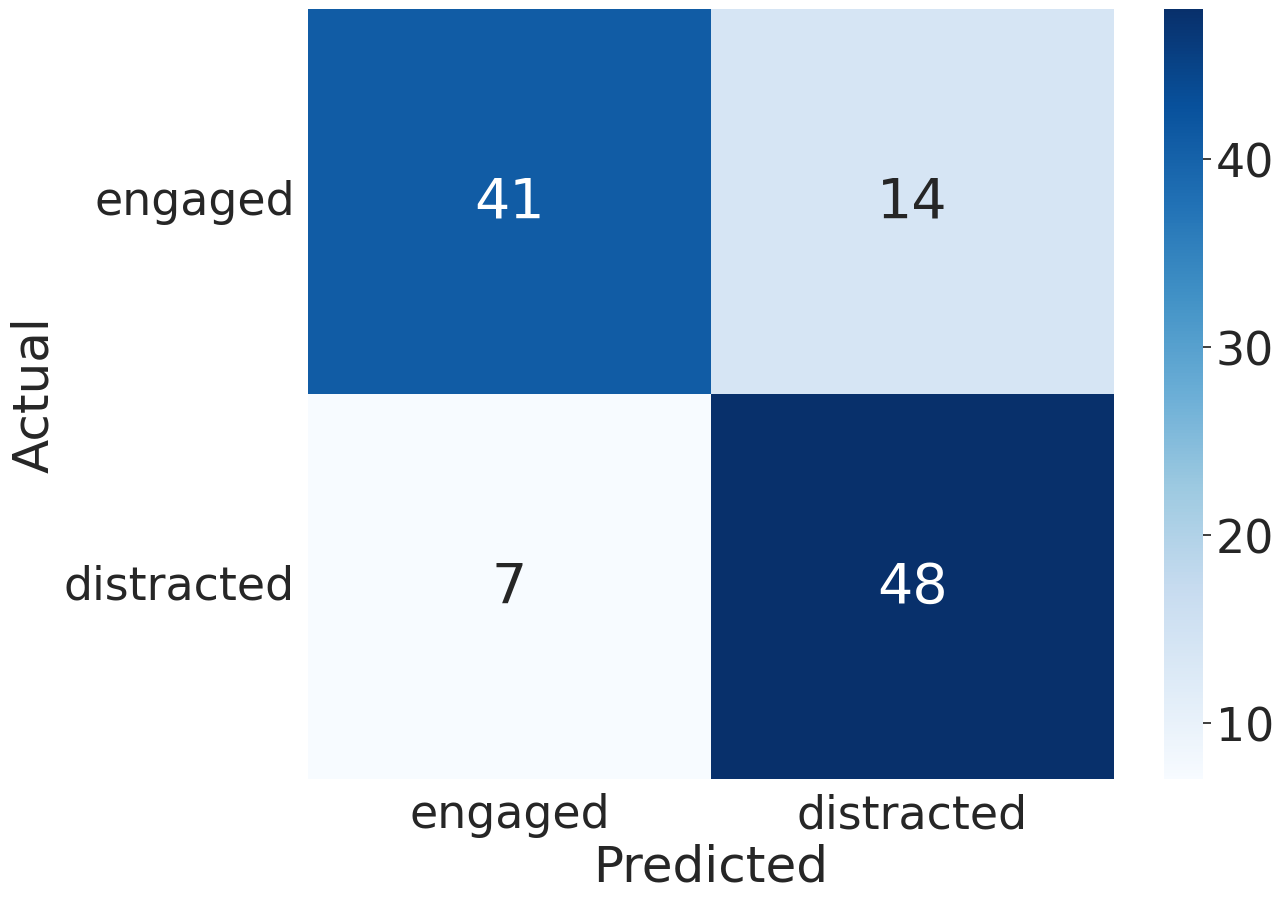

In [154]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [155]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.6545454545454545, Precision: 0.6880952380952381, F1: 0.6384018710459012
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7816563146997929
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.6727272727272727, Precision: 0.6933333333333332, F1: 0.6572164398841892
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8714285714285713, F1: 0.7858229813664597
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.4, Precision: 0.35256410256410253, F1: 0.3746376811594203
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6880952380952381, F1: 0.6255363739698778
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7816563146997929
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.6727272727272727, Precision: 0.6933333333333332, F1: 0.6572164398841892
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7816563146997929
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6880952380952381, F1: 0.6255363739698778
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8714285714285713, F1: 0.7858229813664597
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.6181818181818182, Precision: 0.6880952380952381, F1: 0.6111572890025576
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8714285714285713, F1: 0.7858229813664597
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.4, Precision: 0.36666666666666664, F1: 0.3826086956521739
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6545454545454545, Precision: 0.6933333333333332, F1: 0.6443509428081657
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8714285714285713, F1: 0.7858229813664597
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.6727272727272727, Precision: 0.6933333333333332, F1: 0.6572164398841892
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8714285714285713, F1: 0.7858229813664597
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6545454545454545, Precision: 0.6933333333333332, F1: 0.642837354916869
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8181818181818181, Precision: 0.8714285714285713, F1: 0.7858229813664597
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.4, Precision: 0.35256410256410253, F1: 0.3746376811594203
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6545454545454545, Precision: 0.6933333333333332, F1: 0.6443509428081657
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7816563146997929
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7613785369220152


In [156]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### Max

In [157]:
stat_func = np.max
stat_name = "max"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [158]:
classificator_name = 'single_attention'

#### Traditional split

In [159]:
split_name = 'traditional_best'

In [160]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [161]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [162]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [163]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [164]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [165]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [166]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [167]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_traditional_best_Den_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_traditional_best_Kate_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_traditional_best_Yana_0 Accuracy:  0.6666666666666666 MSE:  0.3333333333333333 UAR:  0.6681818181818182 Recall:  0.7 Precision:  0.6363636363636364 F1:  0.6666666666666666
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_traditional_best_Egor_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Precision:  0.7777777777777778 F1:  0.7000000000000001
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_traditional_best_Katya_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Total, accuracy: 0.8151515151515152, MSE: 0.18484848484848485, UAR: 0.8154545454545457, Recall: 0.849090909090909, Precision: 0.791020091020091, F1: 0.8144848484848485


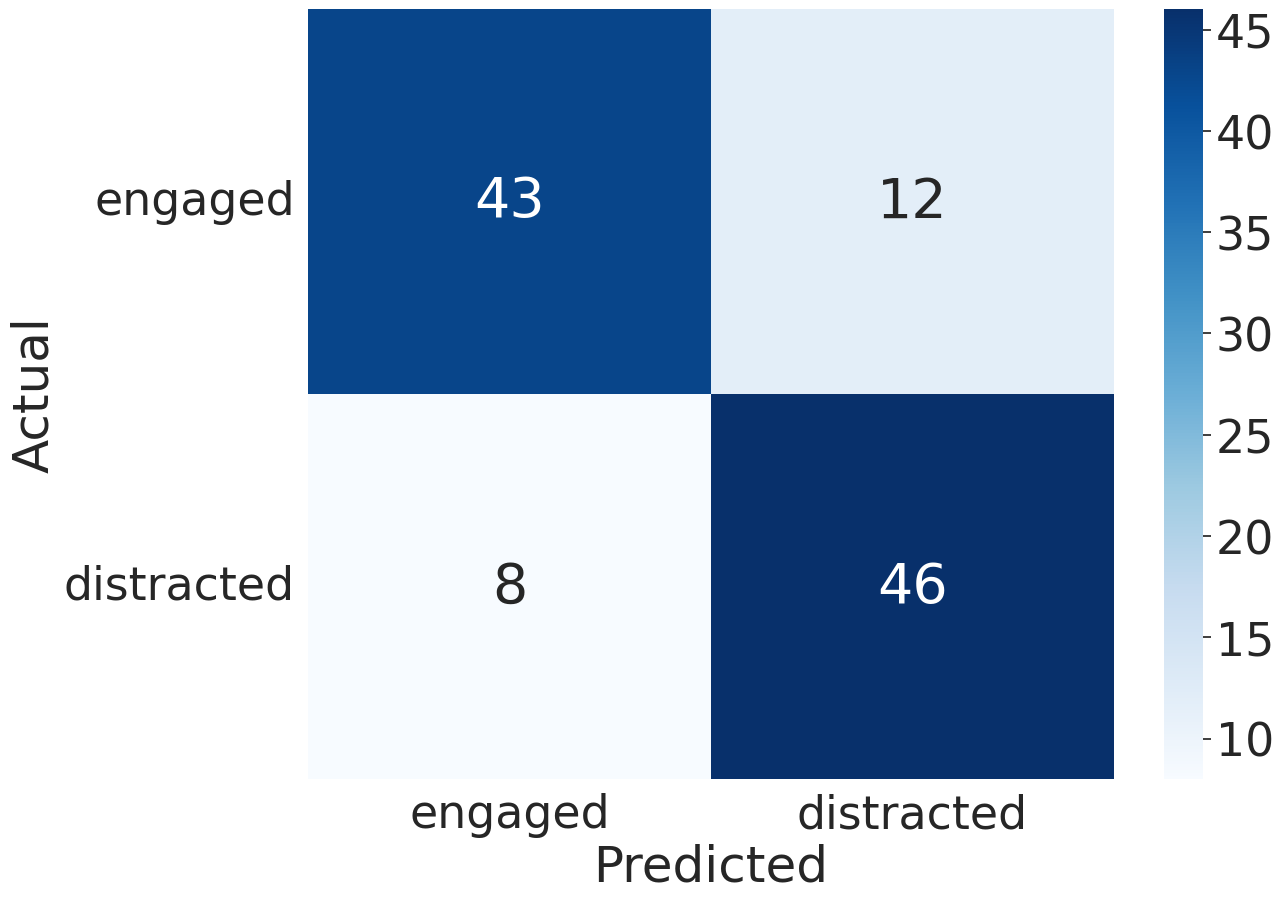

In [168]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [169]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [170]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8545454545454545, Precision: 0.8865546218487396, F1: 0.8427403803626714
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.890909090909091, MSE: 0.1090909090909091, UAR: 0.8909090909090909, Recall: 0.909090909090909, Precision: 0.9026515151515152, F1: 0.8916410481627874
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8727272727272727, Precision: 0.9208333333333332, F1: 0.8782439189761846
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8727272727272727, Precision: 0.9208333333333332, F1: 0.8782439189761846
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.8909090909090909, Recall: 0.890909090909091, Precision: 0.9099999999999999, F1: 0.8875192440409831
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.890909090909091, MSE: 0.1090909090909091, UAR: 0.8909090909090909, Recall: 0.890909090909091, Precision: 0.9208333333333332, F1: 0.8898228663446055
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.8909090909090909, Recall: 0.8727272727272727, Precision: 0.93, F1: 0.8845117252439907
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 0.890909090909091, Precision: 0.93, F1: 0.8960906726124117
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.8909090909090909, Recall: 0.8727272727272727, Precision: 0.93, F1: 0.8845117252439907
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.890909090909091, Precision: 0.9127450980392157, F1: 0.8840027605244997


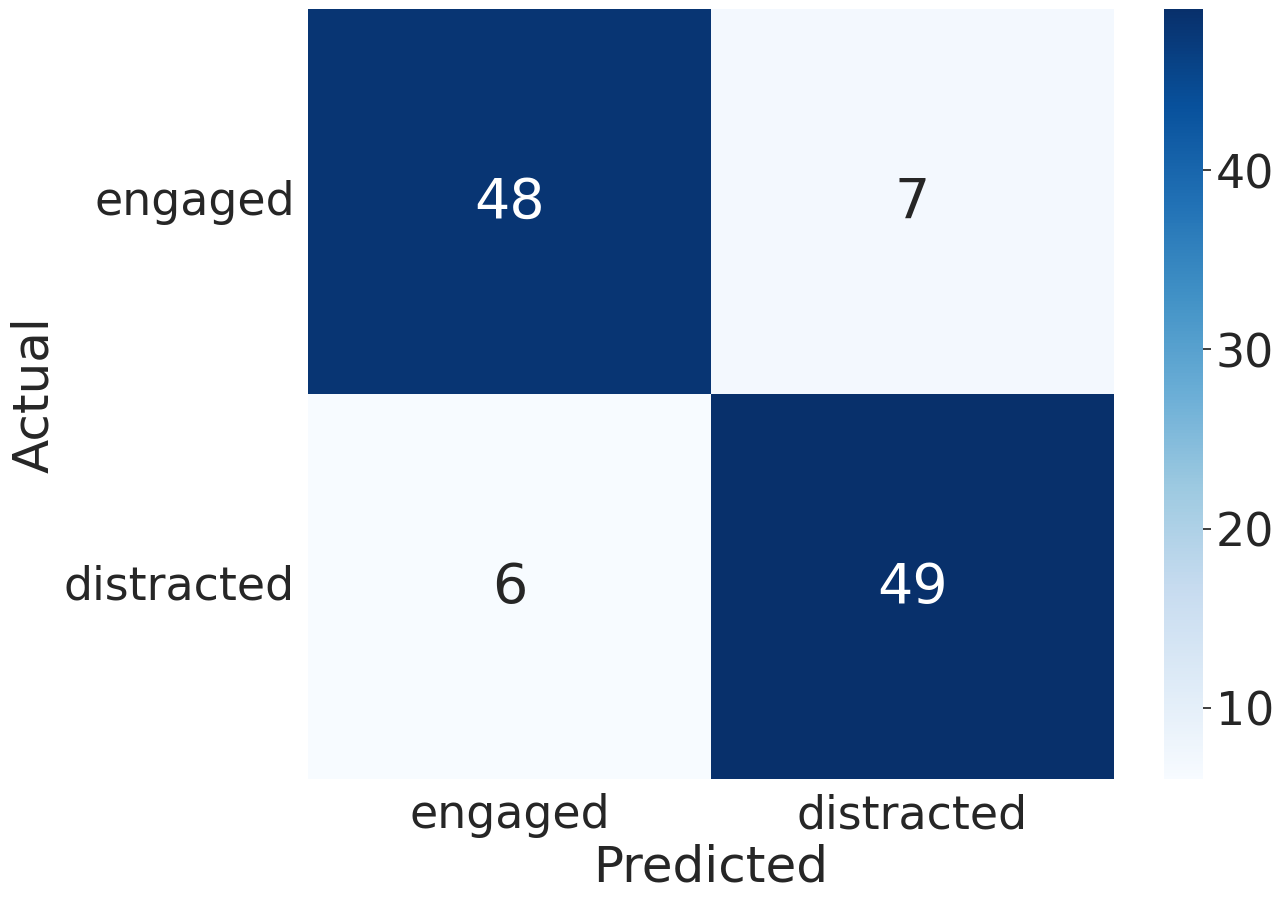

In [171]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [172]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7127450980392156, F1: 0.6639233954451346
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.9040404040404042, F1: 0.8269633723807953
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090908, MSE: 0.20909090909090908, UAR: 0.7909090909090908, Recall: 0.6727272727272726, Precision: 0.7375, F1: 0.6784391534391534
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.9112299465240643, F1: 0.8140487582592846
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090908, MSE: 0.20909090909090908, UAR: 0.7909090909090908, Recall: 0.6727272727272726, Precision: 0.7375, F1: 0.6784391534391534
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.9112299465240643, F1: 0.8323820915926179
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181817, MSE: 0.21818181818181817, UAR: 0.7818181818181817, Recall: 0.6727272727272726, Precision: 0.7208333333333333, F1: 0.6697435012652404
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.9112299465240643, F1: 0.8323820915926179
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7112299465240641, F1: 0.663961038961039
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.9112299465240643, F1: 0.8140487582592846
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090908, MSE: 0.20909090909090908, UAR: 0.7909090909090908, Recall: 0.6727272727272726, Precision: 0.7375, F1: 0.6784391534391534
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.9112299465240643, F1: 0.8323820915926179
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181817, MSE: 0.21818181818181817, UAR: 0.7818181818181817, Recall: 0.6727272727272726, Precision: 0.7208333333333333, F1: 0.6697435012652404
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.9112299465240643, F1: 0.8140487582592846
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272726, Precision: 0.7294117647058823, F1: 0.6726190476190477
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.9112299465240643, F1: 0.8323820915926179
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090908, MSE: 0.20909090909090908, UAR: 0.7909090909090908, Recall: 0.6727272727272726, Precision: 0.7375, F1: 0.6784391534391534
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8363636363636363, Precision: 0.888888888888889, F1: 0.8209995002498751
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.9112299465240643, F1: 0.8323820915926179
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.38181818181818183, Precision: 0.3833333333333333, F1: 0.38178053830227743
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090908, MSE: 0.20909090909090908, UAR: 0.7909090909090908, Recall: 0.6727272727272726, Precision: 0.7375, F1: 0.6784391534391534
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8545454545454547, Precision: 0.888888888888889, F1: 0.8393328335832084
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.9112299465240643, F1: 0.8140487582592846


In [173]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [174]:
split_name = 'balanced_best'

In [175]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [176]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [177]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [178]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [179]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [180]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [181]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [182]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_balanced_best_Den_0 Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.45454545454545453 Precision:  0.5555555555555556 F1:  0.5
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_balanced_best_Kate_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_balanced_best_Yana_0 Accuracy:  0.6190476190476191 MSE:  0.38095238095238093 UAR:  0.6181818181818182 Recall:  0.6 Precision:  0.6 F1:  0.6
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_balanced_best_Egor_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.6363636363636364 Precision:  0.6363636363636364 F1:  0.6363636363636364
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_balanced_best_Katya_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Total, accuracy: 0.7056277056277056, MSE: 0.29437229437229434, UAR: 0.7054545454545454, Recall: 0.7381818181818182, Precision: 0.6742812742812743, F1: 0.6998368298368297


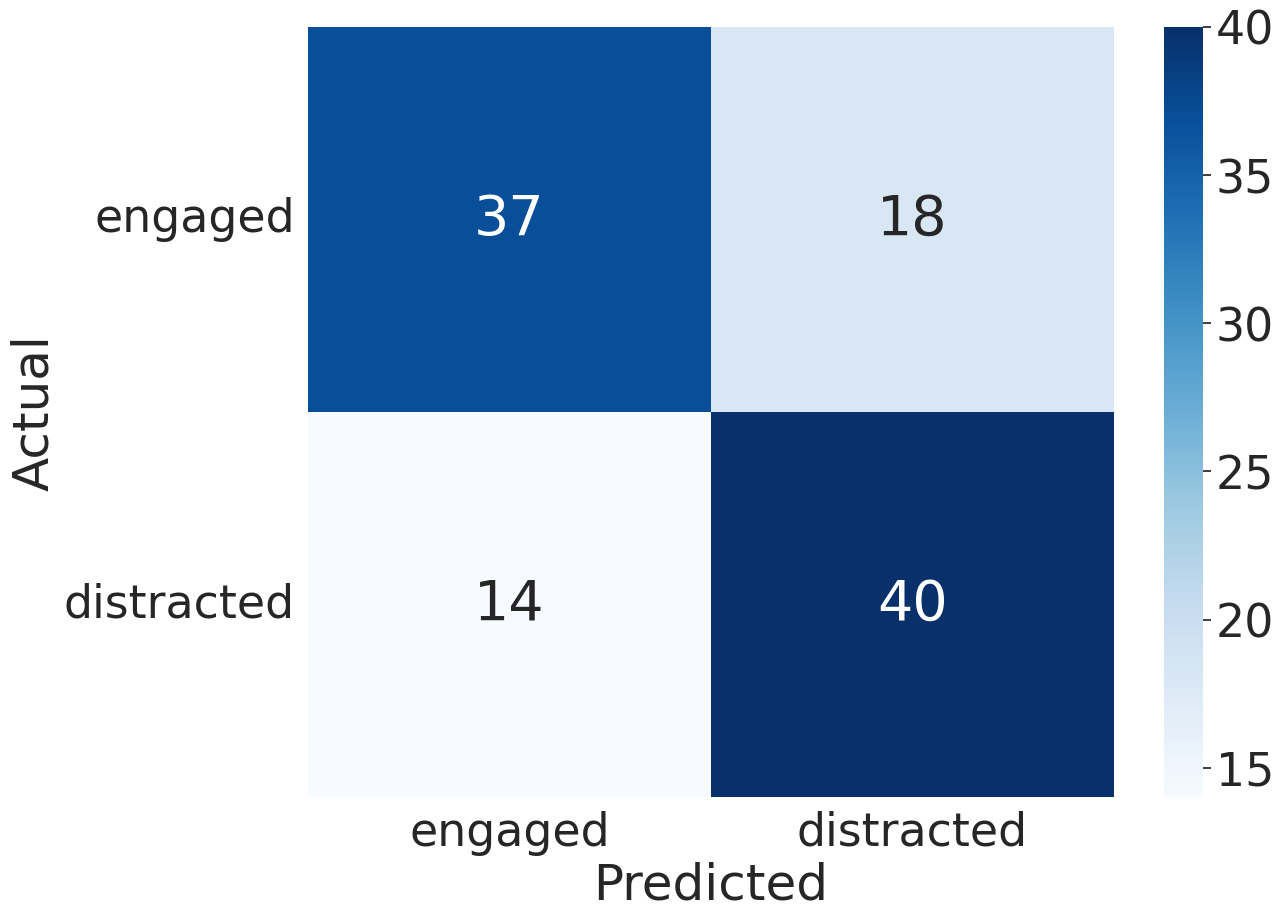

In [183]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [184]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [185]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.818181818181818, MSE: 0.1818181818181818, UAR: 0.818181818181818, Recall: 0.8, Precision: 0.8790404040404042, F1: 0.8125634018662737
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8909090909090909, Precision: 0.8722222222222221, F1: 0.8629732752671284
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8727272727272727, Precision: 0.8691919191919192, F1: 0.8526965954252311
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8727272727272727, Precision: 0.8691919191919192, F1: 0.8526965954252311
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8909090909090909, Precision: 0.8722222222222221, F1: 0.8629732752671284
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8909090909090909, Precision: 0.8722222222222221, F1: 0.8629732752671284
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8727272727272727, Precision: 0.8855555555555554, F1: 0.860488803217439
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8909090909090909, Precision: 0.8722222222222221, F1: 0.8629732752671284
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8727272727272727, Precision: 0.8855555555555554, F1: 0.860488803217439
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8727272727272727, Precision: 0.8855555555555554, F1: 0.860488803217439


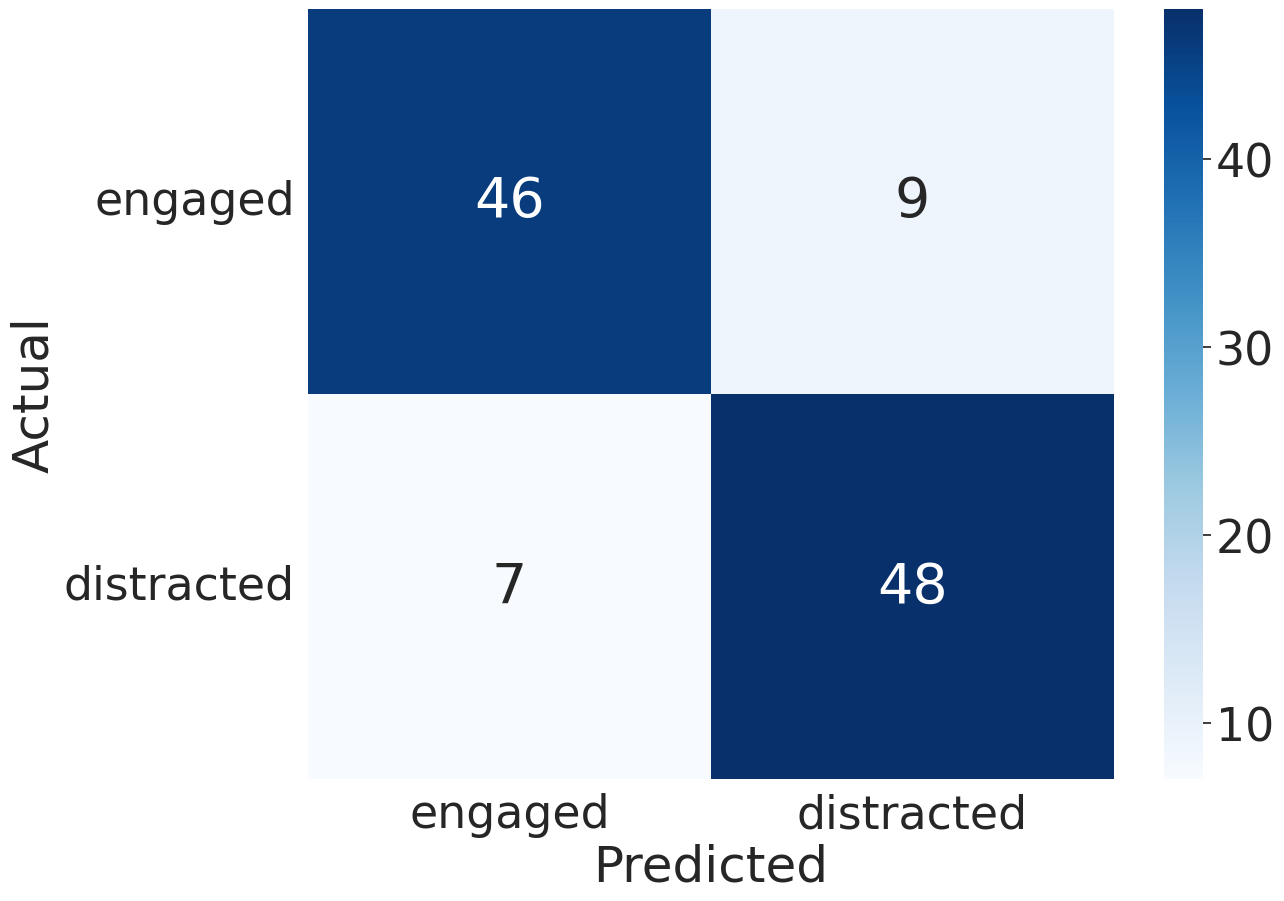

In [186]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [187]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.38181818181818183, Precision: 0.32222222222222224, F1: 0.3422003284072249
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.2636363636363636, UAR: 0.7363636363636364, Recall: 0.6909090909090909, Precision: 0.6699134199134199, F1: 0.651799000232504
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8401515151515151, F1: 0.8222453366618125
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8363636363636363, Precision: 0.8603174603174603, F1: 0.8232217224720972
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636365, MSE: 0.36363636363636365, UAR: 0.6363636363636365, Recall: 0.38181818181818183, Precision: 0.32941176470588235, F1: 0.3476190476190476
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545454, Recall: 0.7090909090909091, Precision: 0.6699134199134199, F1: 0.6661780851998244
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8545454545454545, Precision: 0.817929292929293, F1: 0.8138242840302337
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.38181818181818183, Precision: 0.32222222222222224, F1: 0.3422003284072249
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.6727272727272727, Precision: 0.6683982683982684, F1: 0.642312834224599
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8401515151515151, F1: 0.8222453366618125
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.38181818181818183, Precision: 0.3466666666666667, F1: 0.35970695970695965
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6545454545454545, Precision: 0.6665800865800866, F1: 0.6319232238349886
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.8181818181818181, Precision: 0.8365800865800865, F1: 0.795344751866491
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.38181818181818183, Precision: 0.32222222222222224, F1: 0.3422003284072249
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.6909090909090909, Precision: 0.6683982683982684, F1: 0.6566919191919192
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.8363636363636363, Precision: 0.8365800865800865, F1: 0.8082102489425143
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.38181818181818183, Precision: 0.3466666666666667, F1: 0.35970695970695965
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6545454545454545, Precision: 0.6665800865800866, F1: 0.6319232238349886
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.8363636363636363, Precision: 0.8365800865800865, F1: 0.8082102489425143
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818181, MSE: 0.1818181818181818, UAR: 0.8181818181818183, Recall: 0.8, Precision: 0.888888888888889, F1: 0.7965550558054307
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.3818181818181818, UAR: 0.6181818181818182, Recall: 0.38181818181818183, Precision: 0.30404040404040406, F1: 0.33354231974921633
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6545454545454545, Precision: 0.6665800865800866, F1: 0.6319232238349886
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.8363636363636363, Precision: 0.8365800865800865, F1: 0.8082102489425143
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636365, MSE: 0.36363636363636365, UAR: 0.6363636363636365, Recall: 0.38181818181818183, Precision: 0.32941176470588235, F1: 0.3476190476190476
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6545454545454545, Precision: 0.6665800865800866, F1: 0.6319232238349886
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.8181818181818181, Precision: 0.8365800865800865, F1: 0.795344751866491
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818181, MSE: 0.1818181818181818, UAR: 0.8181818181818183, Recall: 0.8, Precision: 0.888888888888889, F1: 0.7965550558054307
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.38181818181818183, Precision: 0.32222222222222224, F1: 0.3422003284072249
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6545454545454545, Precision: 0.6665800865800866, F1: 0.6319232238349886
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.8363636363636363, Precision: 0.8365800865800865, F1: 0.8082102489425143
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.38181818181818183, Precision: 0.3466666666666667, F1: 0.35970695970695965
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.6363636363636364, Precision: 0.6665800865800866, F1: 0.6157467532467533
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.8363636363636363, Precision: 0.8365800865800865, F1: 0.8082102489425143
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.888888888888889, F1: 0.814888389138764


In [188]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### STAT

In [189]:
stat_func = compute_descriptor
stat_name = "STAT"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [190]:
classificator_name = 'single_attention'

#### Traditional split

In [191]:
split_name = 'traditional_best'

In [192]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [193]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [194]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [195]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3072) (88,)


In [196]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3073      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [197]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [198]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [199]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_traditional_best_Den_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_traditional_best_Kate_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_traditional_best_Yana_0 Accuracy:  0.7142857142857143 MSE:  0.2857142857142857 UAR:  0.7227272727272727 Recall:  0.9 Precision:  0.6428571428571429 F1:  0.75
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_traditional_best_Egor_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.6363636363636364 Precision:  0.7 F1:  0.6666666666666666
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_traditional_best_Katya_0 Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Total, accuracy: 0.8064935064935064, MSE: 0.1935064935064935, UAR: 0.8081818181818182, Recall: 0.9072727272727272, Precision: 0.7586355311355312, F1: 0.8209339774557165


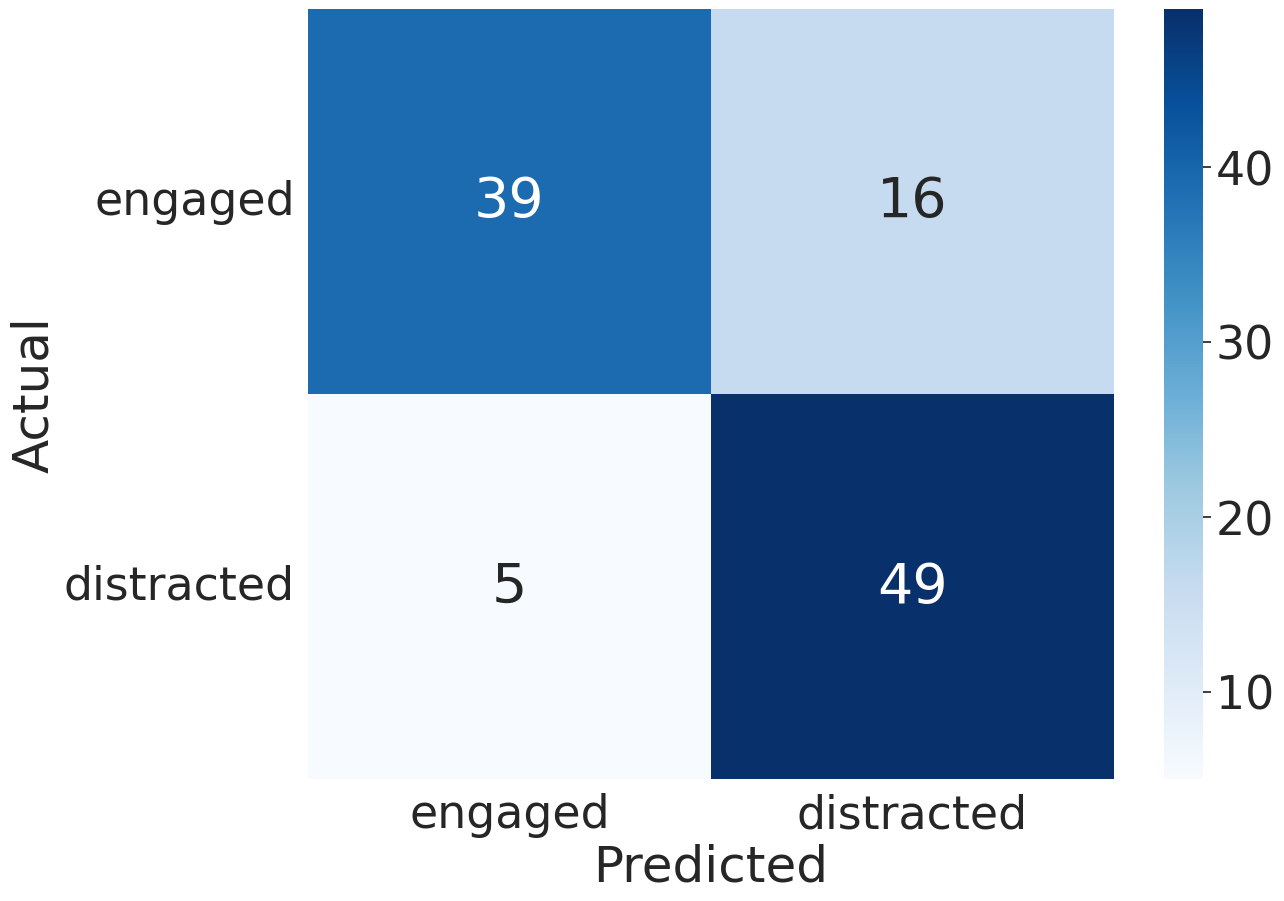

In [200]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [201]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [202]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 0.8181818181818181, Precision: 0.8880952380952379, F1: 0.8093599033816424
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8363636363636363, Precision: 0.8991228070175439, F1: 0.8313920671243327
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8545454545454547, Precision: 0.8933333333333333, F1: 0.8382398316970547
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.8991228070175439, F1: 0.8185265700483093
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.8991228070175439, F1: 0.8185265700483093
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8363636363636363, Precision: 0.8991228070175439, F1: 0.8313920671243327
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.8991228070175439, F1: 0.8185265700483093
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8545454545454547, Precision: 0.8933333333333333, F1: 0.8382398316970547
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.8991228070175439, F1: 0.8185265700483093
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8545454545454547, Precision: 0.8933333333333333, F1: 0.8382398316970547


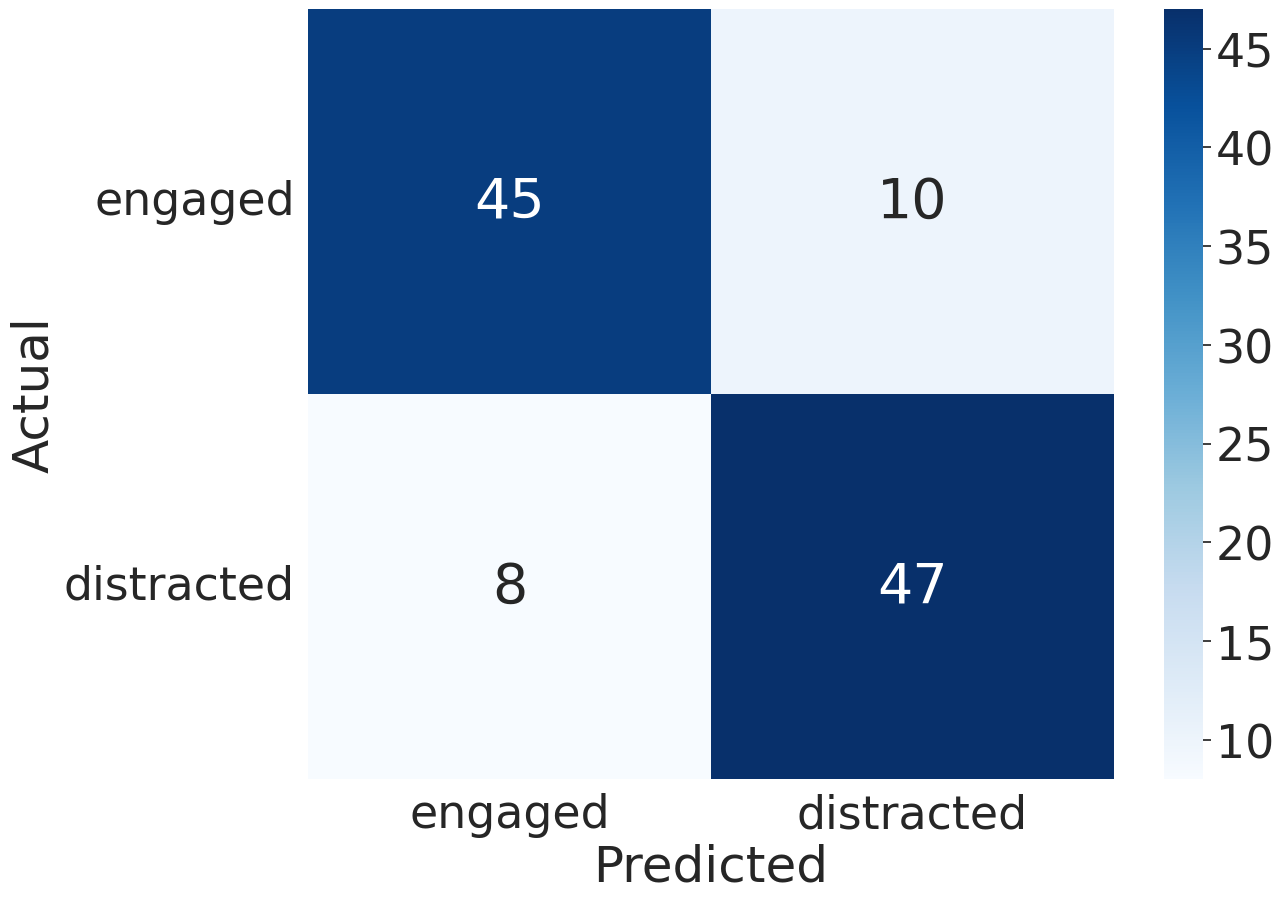

In [203]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [204]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_1
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6909090909090909, Precision: 0.7222222222222222, F1: 0.6767241379310345
Videos num:  3_1
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7701086956521739
Videos num:  4_1
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394
Videos num:  1_2
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_2
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7222222222222222, F1: 0.667200328407225
Videos num:  3_2
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7636363636363637, Precision: 0.8714285714285713, F1: 0.7517753623188407
Videos num:  4_2
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394
Videos num:  1_3
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_3
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7222222222222222, F1: 0.667200328407225
Videos num:  3_3
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7636363636363637, Precision: 0.8714285714285713, F1: 0.7517753623188407
Videos num:  4_3
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7636363636363637, Precision: 0.8991228070175439, F1: 0.7696376811594203
Videos num:  1_4
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_4
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.7222222222222222, F1: 0.6567241379310345
Videos num:  3_4
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7636363636363637, Precision: 0.8766666666666667, F1: 0.7562108461898083
Videos num:  4_4
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394
Videos num:  1_5
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_5
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7222222222222222, F1: 0.667200328407225
Videos num:  3_5
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7636363636363637, Precision: 0.8714285714285713, F1: 0.7517753623188407
Videos num:  4_5
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7454545454545455, Precision: 0.9055555555555556, F1: 0.7537427714714072
Videos num:  1_6
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_6
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7222222222222222, F1: 0.667200328407225
Videos num:  3_6
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7636363636363637, Precision: 0.8766666666666667, F1: 0.7562108461898083
Videos num:  4_6
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394
Videos num:  1_7
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_7
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272726, Precision: 0.7222222222222222, F1: 0.667200328407225
Videos num:  3_7
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7636363636363637, Precision: 0.8766666666666667, F1: 0.7562108461898083
Videos num:  4_7
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.7454545454545455, Precision: 0.9055555555555556, F1: 0.7537427714714072
Videos num:  1_8
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_8
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6909090909090909, Precision: 0.7222222222222222, F1: 0.6767241379310345
Videos num:  3_8
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.7636363636363637, Precision: 0.8714285714285713, F1: 0.7517753623188407
Videos num:  4_8
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394
Videos num:  1_9
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_9
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.7222222222222222, F1: 0.6567241379310345
Videos num:  3_9
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7636363636363637, Precision: 0.8766666666666667, F1: 0.7562108461898083
Videos num:  4_9
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394
Videos num:  1_10
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.36363636363636365, Precision: 0.4, F1: 0.38
Videos num:  2_10
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.6545454545454545, Precision: 0.7222222222222222, F1: 0.6567241379310345
Videos num:  3_10
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7636363636363637, Precision: 0.8766666666666667, F1: 0.7562108461898083
Videos num:  4_10
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.7454545454545455, Precision: 0.8991228070175439, F1: 0.7486853002070394


In [205]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [206]:
split_name = 'balanced_best'

In [207]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [208]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [209]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [210]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3072) (88,)


In [211]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3073      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [212]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [213]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [214]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_balanced_best_Den_0 Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.5454545454545454 Precision:  0.5454545454545454 F1:  0.5454545454545454
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_balanced_best_Kate_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_balanced_best_Yana_0 Accuracy:  0.6190476190476191 MSE:  0.38095238095238093 UAR:  0.6272727272727273 Recall:  0.8 Precision:  0.5714285714285714 F1:  0.6666666666666666
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_balanced_best_Egor_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.8181818181818182 Precision:  0.75 F1:  0.7826086956521738
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_balanced_best_Katya_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Total, accuracy: 0.6965367965367966, MSE: 0.30346320346320343, UAR: 0.6981818181818182, Recall: 0.8327272727272728, Precision: 0.6583968662916031, F1: 0.7289459815546772


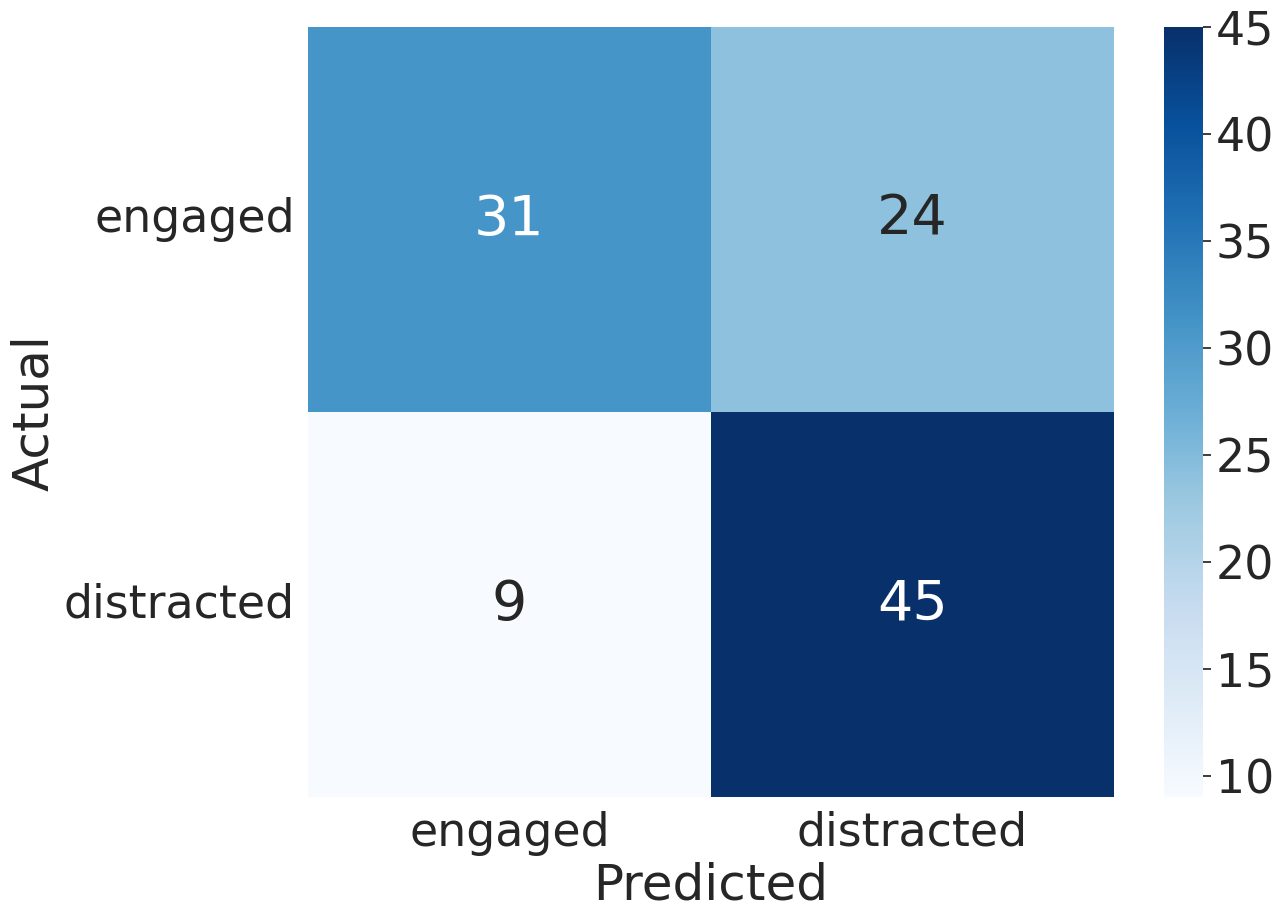

In [215]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [216]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [217]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.890909090909091, Precision: 0.8492063492063492, F1: 0.8485297482837529
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8444444444444444, F1: 0.8171184995737425
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8444444444444444, F1: 0.8171184995737425
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8444444444444444, F1: 0.8171184995737425
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.8545454545454545, Precision: 0.8492063492063492, F1: 0.8212851662404091
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8444444444444444, F1: 0.8171184995737425
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8444444444444444, F1: 0.8171184995737425
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.8545454545454545, Precision: 0.8444444444444444, F1: 0.8171184995737425
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.8545454545454545, Precision: 0.8492063492063492, F1: 0.8212851662404091
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.8545454545454545, Precision: 0.8492063492063492, F1: 0.8212851662404091


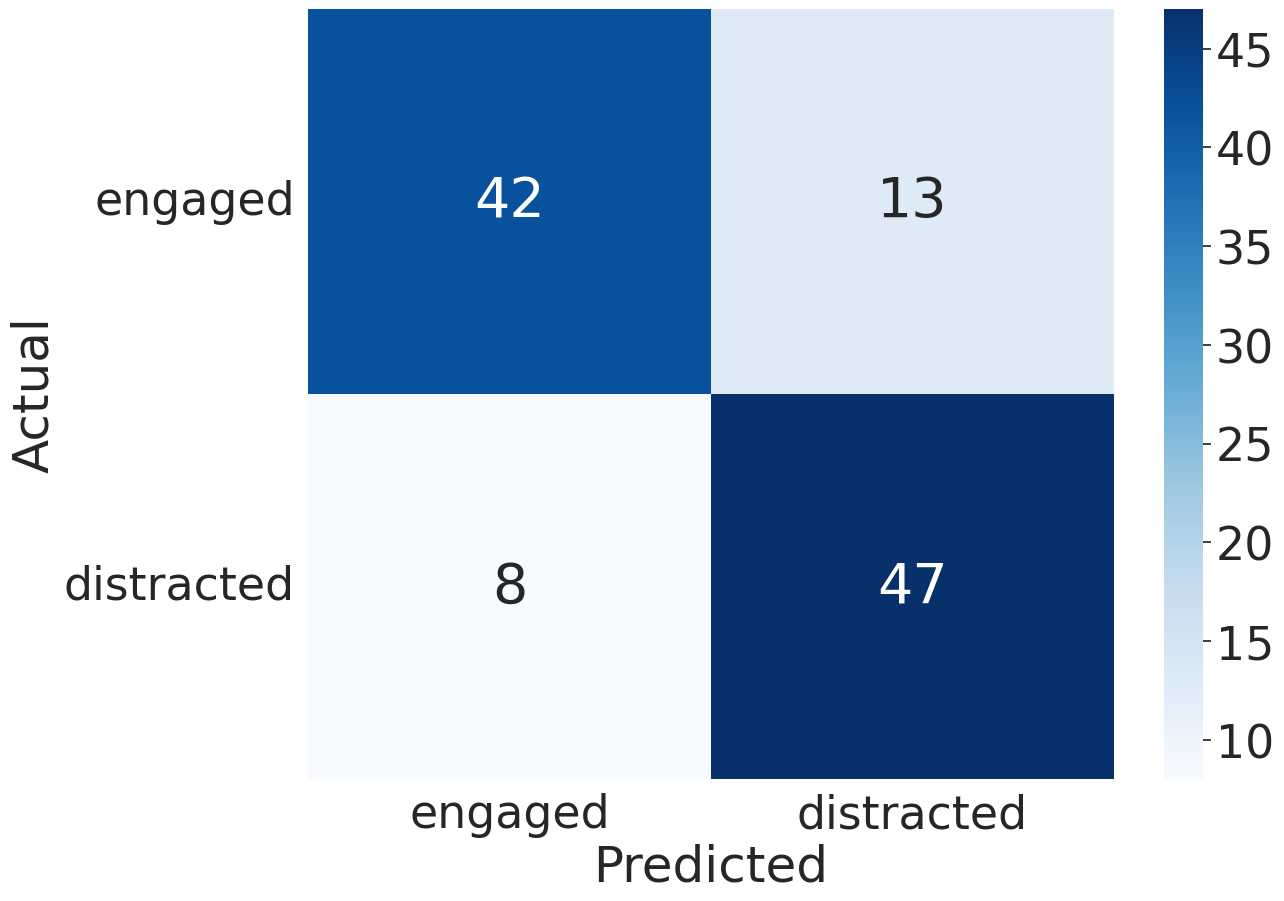

In [218]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [219]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_1
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.6545454545454545, Precision: 0.6865800865800866, F1: 0.6432947900053164
Videos num:  3_1
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_1
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7679518329070758
Videos num:  1_2
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_2
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.630429292929293
Videos num:  3_2
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_2
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_3
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_3
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.6545454545454545, Precision: 0.6865800865800866, F1: 0.6432947900053164
Videos num:  3_3
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_3
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_4
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_4
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.630429292929293
Videos num:  3_4
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_4
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_5
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_5
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.630429292929293
Videos num:  3_5
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.8, Precision: 0.8666666666666666, F1: 0.7781642512077294
Videos num:  4_5
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_6
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_6
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.630429292929293
Videos num:  3_6
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_6
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_7
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_7
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.6289157050379961
Videos num:  3_7
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_7
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_8
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_8
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.6545454545454545, Precision: 0.6865800865800866, F1: 0.6432947900053164
Videos num:  3_8
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_8
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_9
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_9
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.630429292929293
Videos num:  3_9
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_9
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8, Precision: 0.8714285714285713, F1: 0.7823309178743962
Videos num:  1_10
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.38181818181818183, Precision: 0.3651515151515151, F1: 0.37312252964426873
Videos num:  2_10
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818183, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.6363636363636364, Precision: 0.6865800865800866, F1: 0.630429292929293
Videos num:  3_10
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8181818181818181, Precision: 0.8666666666666666, F1: 0.7910297482837528
Videos num:  4_10
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.7818181818181819, Precision: 0.8714285714285713, F1: 0.7679518329070758


In [220]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

# EngageWild

In [20]:
WEIGHTS_DIR = DATA_DIR + "weights_EngageWild/"
DATASET_NAME = 'EngageWild'

## enet_b0_8_best_afew

In [21]:
base_model_key = 'enet_b0_8_best_afew.pt'

In [22]:
engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
eng_file2features = load_features(engaged_pickle)
distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
dis_file2features = load_features(distracted_pickle)

In [23]:
video2label = get_video2label(list(eng_file2features.keys()), list(dis_file2features.keys()))

### Std

In [225]:
stat_func = np.std
stat_name = "std"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [226]:
classificator_name = 'single_attention'

#### Traditional split

In [227]:
split_name = 'traditional_best'

In [228]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [229]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [230]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [231]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [232]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [233]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [234]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [235]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_traditional_best_Den_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_traditional_best_Kate_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_traditional_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8545454545454545 Recall:  0.8 Precision:  0.8888888888888888 F1:  0.8421052631578948
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_traditional_best_Egor_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.9090909090909091 Precision:  0.5882352941176471 F1:  0.7142857142857143
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_traditional_best_Katya_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Total, accuracy: 0.8077922077922077, MSE: 0.19220779220779222, UAR: 0.8072727272727273, Recall: 0.9054545454545455, Precision: 0.7900676937441643, F1: 0.8302411584516849


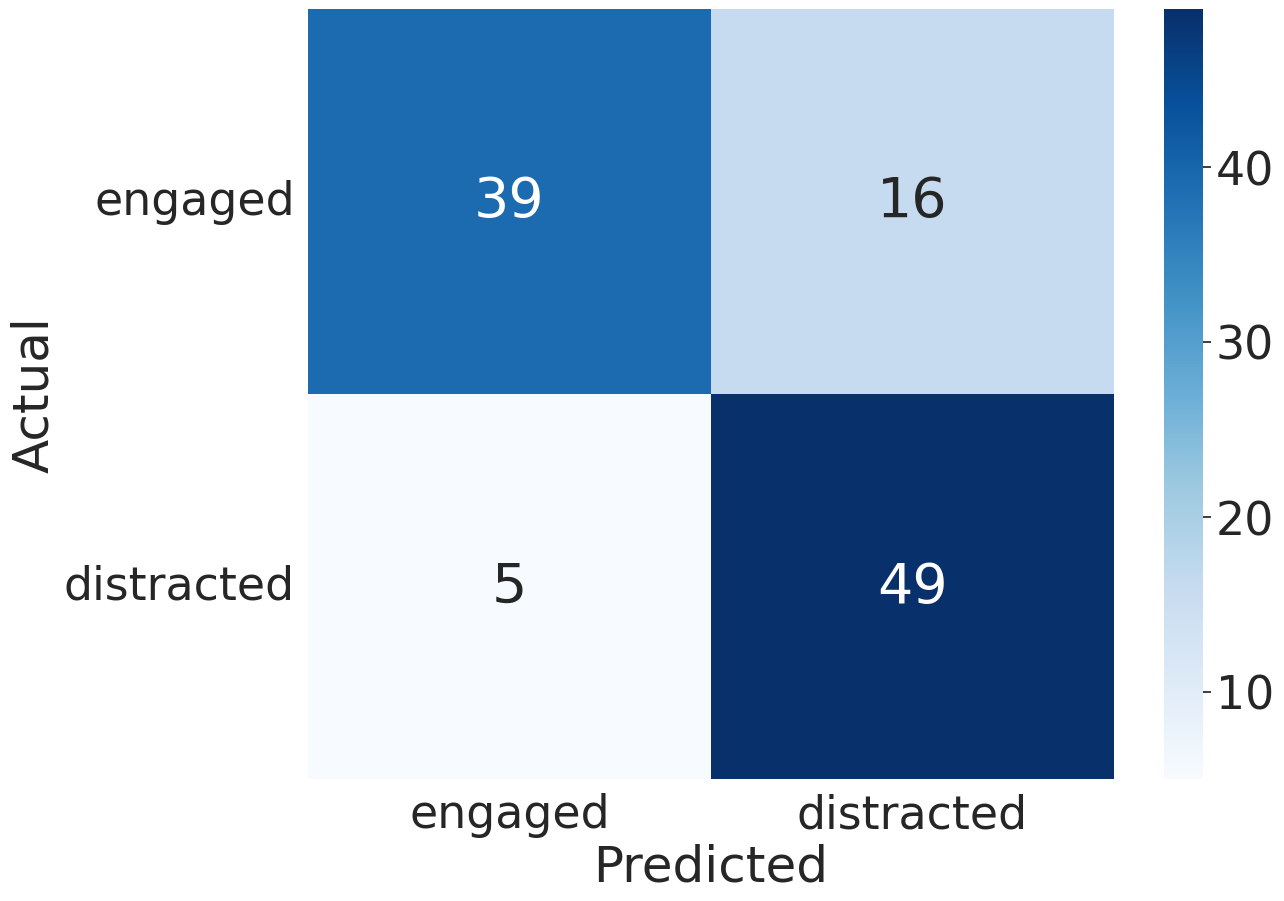

In [236]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [237]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [238]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8545454545454545, Precision: 0.7275, F1: 0.7440779896187866
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8545454545454547, Precision: 0.7328571428571429, F1: 0.7506388361796331
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7, MSE: 0.30000000000000004, UAR: 0.7, Recall: 0.8727272727272727, Precision: 0.7366666666666666, F1: 0.7598696054104023
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8727272727272727, Precision: 0.7275, F1: 0.7536017991425961
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.8727272727272727, Precision: 0.7471428571428571, F1: 0.7666388361796331
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8363636363636363, Precision: 0.7366666666666666, F1: 0.7253598014888338
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8727272727272727, Precision: 0.7275, F1: 0.7536017991425961
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8727272727272727, Precision: 0.7275, F1: 0.7536017991425961
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8545454545454545, Precision: 0.7366666666666666, F1: 0.7503457958865928
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.8727272727272727, Precision: 0.7471428571428571, F1: 0.7666388361796331


In [239]:
if False:
    draw_loss_acc_graphs(history)

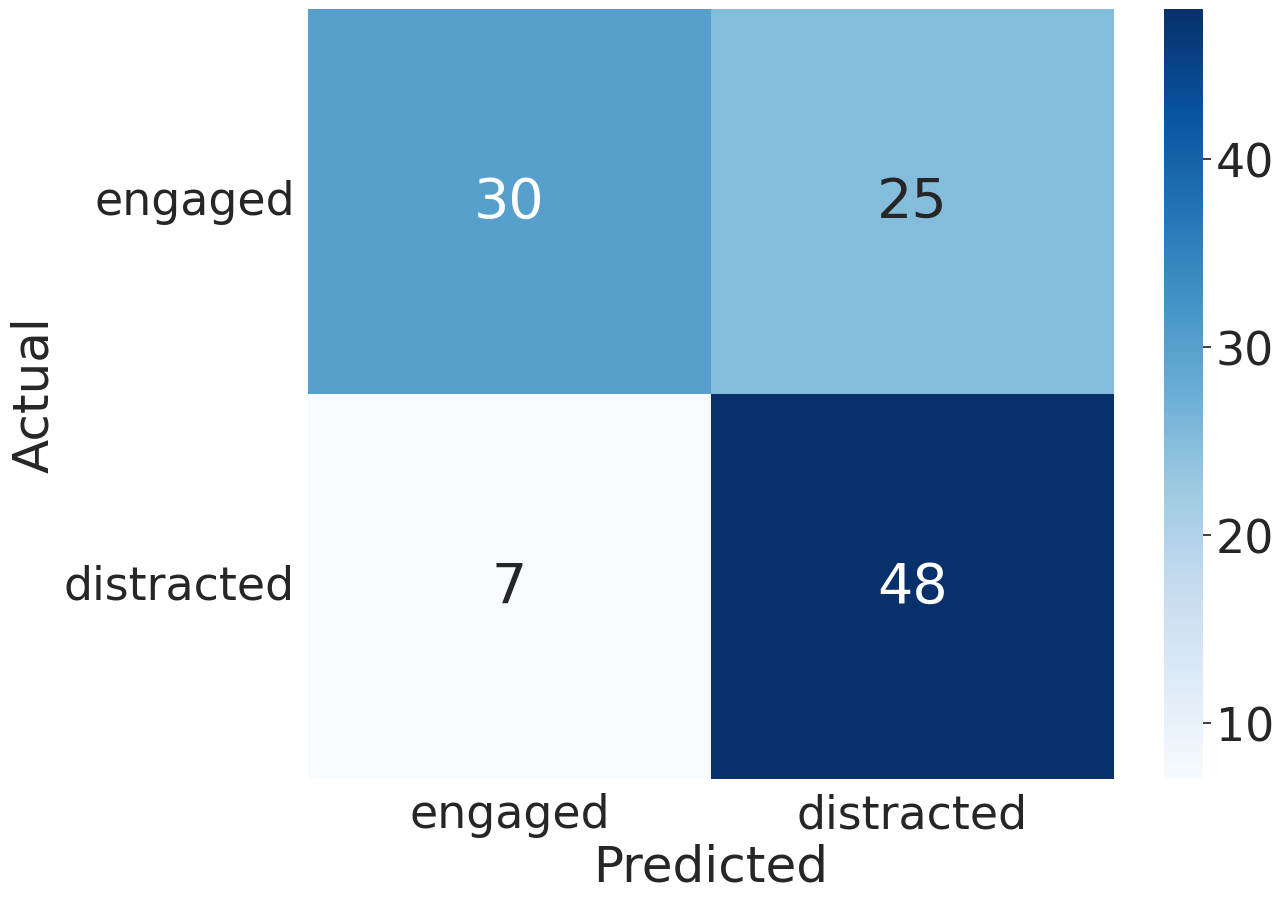

In [240]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [241]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.5454545454545454, Precision: 0.675, F1: 0.5140350877192982
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.5818181818181818, Precision: 0.7369047619047618, F1: 0.5626461988304093
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.6181818181818182, Precision: 0.7171428571428571, F1: 0.6063492063492063
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.4, F1: 0.21333333333333332
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.509090909090909, Precision: 0.6666666666666667, F1: 0.484313725490196
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.5818181818181818, Precision: 0.7322222222222222, F1: 0.5623276407337129
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.5818181818181818, Precision: 0.7126984126984126, F1: 0.5697924297924297
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7, F1: 0.4916666666666666
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.3727272727272727, UAR: 0.6272727272727273, Recall: 0.5818181818181818, Precision: 0.7126984126984126, F1: 0.5511111111111111
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.6363636363636365, Precision: 0.7207792207792207, F1: 0.6176046176046176
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.4, F1: 0.21333333333333332
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.509090909090909, Precision: 0.6666666666666667, F1: 0.484313725490196
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.5636363636363637, Precision: 0.5421428571428571, F1: 0.5337483493680437
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.5818181818181818, Precision: 0.7126984126984126, F1: 0.5697924297924297
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.5454545454545454, Precision: 0.675, F1: 0.5140350877192982
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.3727272727272727, UAR: 0.6272727272727273, Recall: 0.5636363636363637, Precision: 0.5321428571428571, F1: 0.5251461988304094
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636365, MSE: 0.36363636363636365, UAR: 0.6363636363636365, Recall: 0.6, Precision: 0.7171428571428571, F1: 0.5821733821733822
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.509090909090909, Precision: 0.6666666666666667, F1: 0.484313725490196
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.3727272727272727, UAR: 0.6272727272727273, Recall: 0.5818181818181818, Precision: 0.7126984126984126, F1: 0.5511111111111111
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636365, MSE: 0.36363636363636365, UAR: 0.6363636363636365, Recall: 0.6, Precision: 0.7171428571428571, F1: 0.5821733821733822
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.509090909090909, Precision: 0.6666666666666667, F1: 0.484313725490196
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.5818181818181818, Precision: 0.7226984126984127, F1: 0.5597132616487456
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.5818181818181818, Precision: 0.7126984126984126, F1: 0.5697924297924297
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.4, F1: 0.21333333333333332
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7, F1: 0.4916666666666666
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.5818181818181818, Precision: 0.7421428571428572, F1: 0.5670816827013772
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.6181818181818182, Precision: 0.7266666666666667, F1: 0.6089635854341736
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.4, F1: 0.21333333333333332
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7, F1: 0.4916666666666666
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.5818181818181818, Precision: 0.7369047619047618, F1: 0.5626461988304093
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6, Precision: 0.7126984126984126, F1: 0.5793162393162393
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090909, MSE: 0.40909090909090906, UAR: 0.5909090909090909, Recall: 0.18181818181818182, Precision: 0.4, F1: 0.21333333333333332
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7, F1: 0.4916666666666666
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.5818181818181818, Precision: 0.7226984126984127, F1: 0.5597132616487456
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.5818181818181818, Precision: 0.7126984126984126, F1: 0.5697924297924297


In [242]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [243]:
split_name = 'balanced_best'

In [244]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [245]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [246]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [247]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [248]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [249]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [250]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [251]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_balanced_best_Den_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.9090909090909091 Precision:  0.7142857142857143 F1:  0.8
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_balanced_best_Kate_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:  0.9 F1:  0.8571428571428572
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_balanced_best_Yana_0 Accuracy:  0.8095238095238095 MSE:  0.19047619047619047 UAR:  0.8136363636363637 Recall:  0.9 Precision:  0.75 F1:  0.8181818181818182
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_balanced_best_Egor_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.8181818181818182 Precision:  0.5625 F1:  0.6666666666666666
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_balanced_best_Katya_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Total, accuracy: 0.7800865800865802, MSE: 0.2199134199134199, UAR: 0.780909090909091, Recall: 0.889090909090909, Precision: 0.7424999999999999, F1: 0.8043982683982683


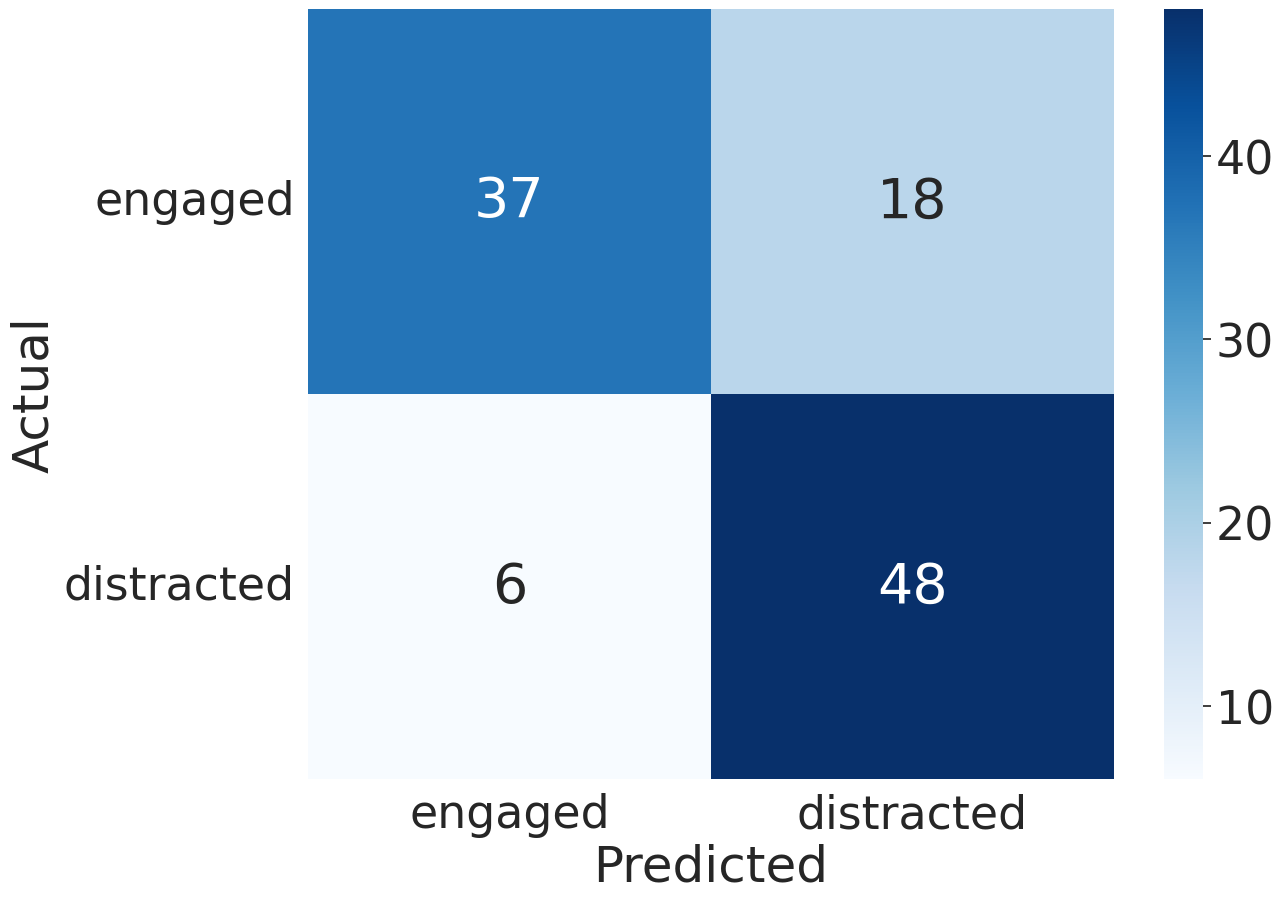

In [252]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [253]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [254]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.7636363636363636, Precision: 0.74, F1: 0.716837846249611
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.7636363636363636, Precision: 0.7622222222222221, F1: 0.7214102564102565
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.7818181818181817, Precision: 0.775, F1: 0.7482573099415204
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.7999999999999999, Precision: 0.775, F1: 0.754775828460039
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.7636363636363636, Precision: 0.775, F1: 0.7338782249742002
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.7999999999999999, Precision: 0.7816666666666666, F1: 0.7593342330184435
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.7999999999999999, Precision: 0.7816666666666666, F1: 0.7593342330184435
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.7999999999999999, Precision: 0.7816666666666666, F1: 0.7593342330184435
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7090909090909092, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.7999999999999999, Precision: 0.7555555555555555, F1: 0.7474074074074075
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.8181818181818181, Precision: 0.75, F1: 0.749550061570522


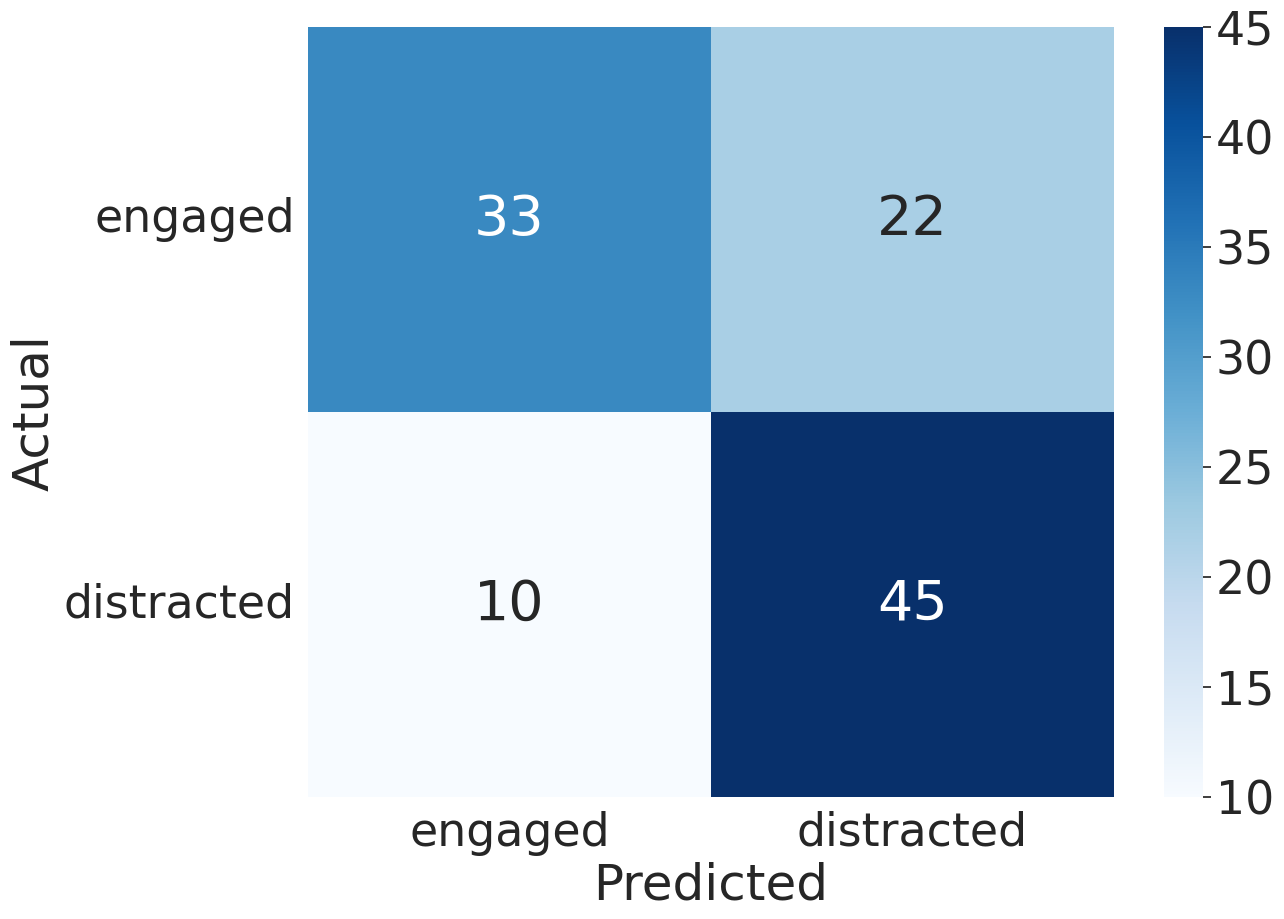

In [255]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [256]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.3090909090909091, Precision: 0.7818181818181819, F1: 0.3833566433566434
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4909090909090909, Precision: 0.9571428571428571, F1: 0.5324102564102564
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.5454545454545455, Precision: 0.8895238095238096, F1: 0.5752136752136752
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.6, Precision: 0.85, F1: 0.5996491228070175
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.2909090909090909, Precision: 0.7818181818181819, F1: 0.35515151515151516
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4909090909090909, Precision: 0.9571428571428571, F1: 0.5324102564102564
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.5454545454545455, Precision: 0.9133333333333333, F1: 0.5817496229260934
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5773809523809523
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.32727272727272727, Precision: 0.9818181818181818, F1: 0.41668997668997665
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.5272727272727272, Precision: 0.9466666666666667, F1: 0.5707692307692308
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181818, Recall: 0.5818181818181818, Precision: 0.8666666666666668, F1: 0.59823313940961
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.3545454545454545, UAR: 0.6454545454545455, Recall: 0.3090909090909091, Precision: 0.9818181818181818, F1: 0.3884848484848485
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.5272727272727272, Precision: 0.9466666666666667, F1: 0.5707692307692308
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5773809523809523
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.3545454545454545, UAR: 0.6454545454545455, Recall: 0.3090909090909091, Precision: 0.9818181818181818, F1: 0.3884848484848485
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.5272727272727272, Precision: 0.9466666666666667, F1: 0.5707692307692308
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5814102564102563
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.3545454545454545, UAR: 0.6454545454545455, Recall: 0.3090909090909091, Precision: 0.9818181818181818, F1: 0.3884848484848485
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909092, Recall: 0.5272727272727272, Precision: 0.9294117647058823, F1: 0.5586813186813188
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5773809523809523
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.2909090909090909, Precision: 0.7818181818181819, F1: 0.35515151515151516
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.5272727272727272, Precision: 0.9466666666666667, F1: 0.5707692307692308
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5454545454545455, Precision: 0.9, F1: 0.563076923076923
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.3090909090909091, Precision: 0.7818181818181819, F1: 0.3833566433566434
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909092, Recall: 0.5272727272727272, Precision: 0.9294117647058823, F1: 0.5586813186813188
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090908, MSE: 0.3090909090909091, UAR: 0.6909090909090908, Recall: 0.5818181818181818, Precision: 0.9, F1: 0.6055860805860805
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.2909090909090909, Precision: 0.7818181818181819, F1: 0.35515151515151516
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9571428571428571, F1: 0.5606153846153846
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636363, MSE: 0.2636363636363636, UAR: 0.7363636363636363, Recall: 0.5454545454545455, Precision: 0.9466666666666667, F1: 0.589102564102564
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181818, Recall: 0.5818181818181818, Precision: 0.8666666666666668, F1: 0.59823313940961
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.2909090909090909, Precision: 0.7818181818181819, F1: 0.35515151515151516
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.30000000000000004, UAR: 0.7, Recall: 0.5090909090909091, Precision: 0.9294117647058823, F1: 0.5417582417582418
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.2727272727272727, UAR: 0.7272727272727273, Recall: 0.5272727272727272, Precision: 0.9466666666666667, F1: 0.5707692307692308
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5814102564102563


In [257]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### Max

In [258]:
stat_func = np.max
stat_name = "max"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [259]:
classificator_name = 'single_attention'

#### Traditional split

In [260]:
split_name = 'traditional_best'

In [261]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [262]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [263]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [264]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [265]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [266]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [267]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [268]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_traditional_best_Den_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_traditional_best_Kate_0 Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.09090909090909091 Precision:  1.0 F1:  0.16666666666666669
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_traditional_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8545454545454545 Recall:  0.8 Precision:  0.8888888888888888 F1:  0.8421052631578948
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_traditional_best_Egor_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.5454545454545454 Precision:  0.6 F1:  0.5714285714285713
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_traditional_best_Katya_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Total, accuracy: 0.6896103896103896, MSE: 0.3103896103896104, UAR: 0.6890909090909091, Recall: 0.4690909090909091, Precision: 0.8977777777777778, F1: 0.5638832375055285


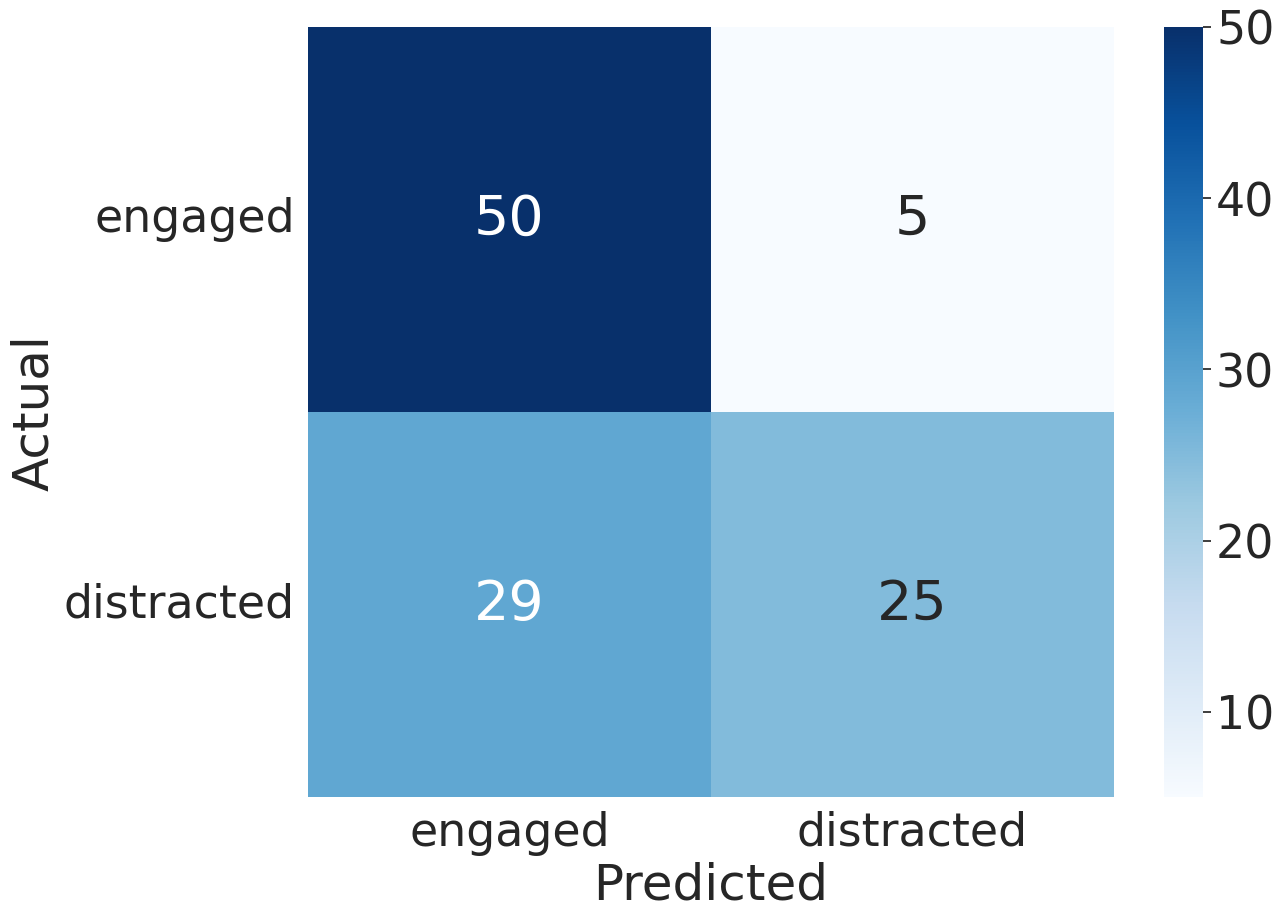

In [269]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [270]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [271]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5454545454545455, MSE: 0.4545454545454545, UAR: 0.5454545454545455, Recall: 0.4909090909090909, Precision: 0.7525000000000001, F1: 0.4892507253797576
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5454545454545455, MSE: 0.4545454545454545, UAR: 0.5454545454545455, Recall: 0.5090909090909091, Precision: 0.7125, F1: 0.5035364396654719
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.5545454545454546, MSE: 0.44545454545454544, UAR: 0.5545454545454546, Recall: 0.5090909090909091, Precision: 0.7525000000000001, F1: 0.5102031063321386


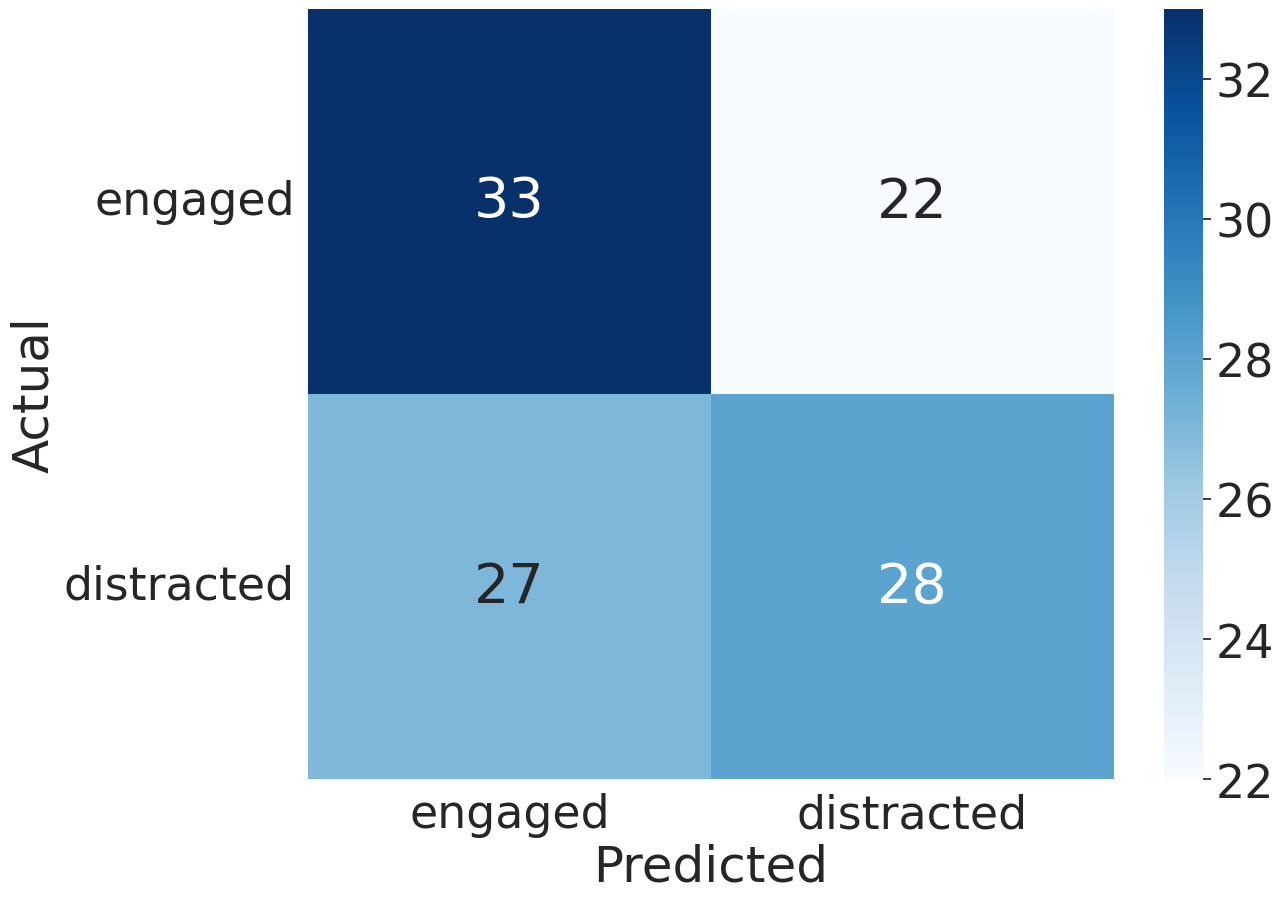

In [272]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [273]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.41818181818181827, Precision: 0.78, F1: 0.49142857142857144
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7938461538461539, F1: 0.5535714285714286
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272728, MSE: 0.42727272727272725, UAR: 0.5727272727272728, Recall: 0.4727272727272728, Precision: 0.7347368421052631, F1: 0.5063003663003662
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.4363636363636364, Precision: 0.78, F1: 0.5019047619047619
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7938461538461539, F1: 0.5535714285714286
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272728, MSE: 0.42727272727272736, UAR: 0.5727272727272728, Recall: 0.4909090909090909, Precision: 0.7363636363636363, F1: 0.5136010226332807
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.41818181818181827, Precision: 0.78, F1: 0.49142857142857144
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.4909090909090909, Precision: 0.7938461538461539, F1: 0.5430952380952381
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.4909090909090909, Precision: 0.74, F1: 0.5153326243648825
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.23636363636363633, Precision: 0.6, F1: 0.31388888888888894
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.6909090909090909, Recall: 0.4, Precision: 0.78, F1: 0.4704761904761905
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.4909090909090909, Precision: 0.7938461538461539, F1: 0.5430952380952381
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.4909090909090909, Precision: 0.74, F1: 0.5153326243648825
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.41818181818181827, Precision: 0.78, F1: 0.49142857142857144
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636365, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.4909090909090909, Precision: 0.7902097902097902, F1: 0.5413636363636364
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272728, MSE: 0.42727272727272736, UAR: 0.5727272727272728, Recall: 0.4909090909090909, Precision: 0.7363636363636363, F1: 0.5136010226332807
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.41818181818181815, Precision: 0.78, F1: 0.480952380952381
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636365, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.4727272727272728, Precision: 0.7938461538461539, F1: 0.5247619047619048
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.4909090909090909, Precision: 0.74, F1: 0.5153326243648825
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.4363636363636364, Precision: 0.78, F1: 0.5019047619047619
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.4909090909090909, Precision: 0.7938461538461539, F1: 0.5430952380952381
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.4909090909090909, Precision: 0.74, F1: 0.5153326243648825
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.6, F1: 0.29555555555555557
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.41818181818181827, Precision: 0.78, F1: 0.49142857142857144
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.4909090909090909, Precision: 0.7938461538461539, F1: 0.5430952380952381
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272728, MSE: 0.42727272727272736, UAR: 0.5727272727272728, Recall: 0.4909090909090909, Precision: 0.7363636363636363, F1: 0.5136010226332807
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.23636363636363633, Precision: 0.6, F1: 0.31388888888888894
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.41818181818181827, Precision: 0.78, F1: 0.49142857142857144
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.4909090909090909, Precision: 0.7938461538461539, F1: 0.5430952380952381
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.4363636363636364, UAR: 0.5636363636363637, Recall: 0.4727272727272728, Precision: 0.7311004784688995, F1: 0.5045687645687645
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.23636363636363633, Precision: 0.6, F1: 0.31388888888888894
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.2818181818181818, UAR: 0.7181818181818181, Recall: 0.4545454545454546, Precision: 0.78, F1: 0.5114285714285715
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.4909090909090909, Precision: 0.7938461538461539, F1: 0.5430952380952381
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.4363636363636364, UAR: 0.5636363636363637, Recall: 0.4727272727272728, Precision: 0.7311004784688995, F1: 0.5045687645687645


In [274]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [275]:
split_name = 'balanced_best'

In [276]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [277]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [278]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [279]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2560) (88,)


In [280]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

In [281]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [282]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [283]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_balanced_best_Den_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.36363636363636365 Precision:  0.6666666666666666 F1:  0.4705882352941177
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_balanced_best_Kate_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_balanced_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8545454545454545 Recall:  0.8 Precision:  0.8888888888888888 F1:  0.8421052631578948
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_balanced_best_Egor_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.5454545454545454 Precision:  0.6666666666666666 F1:  0.6
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_balanced_best_Katya_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Total, accuracy: 0.7077922077922078, MSE: 0.2922077922077922, UAR: 0.7072727272727273, Recall: 0.5236363636363637, Precision: 0.8444444444444443, F1: 0.6303818369453045


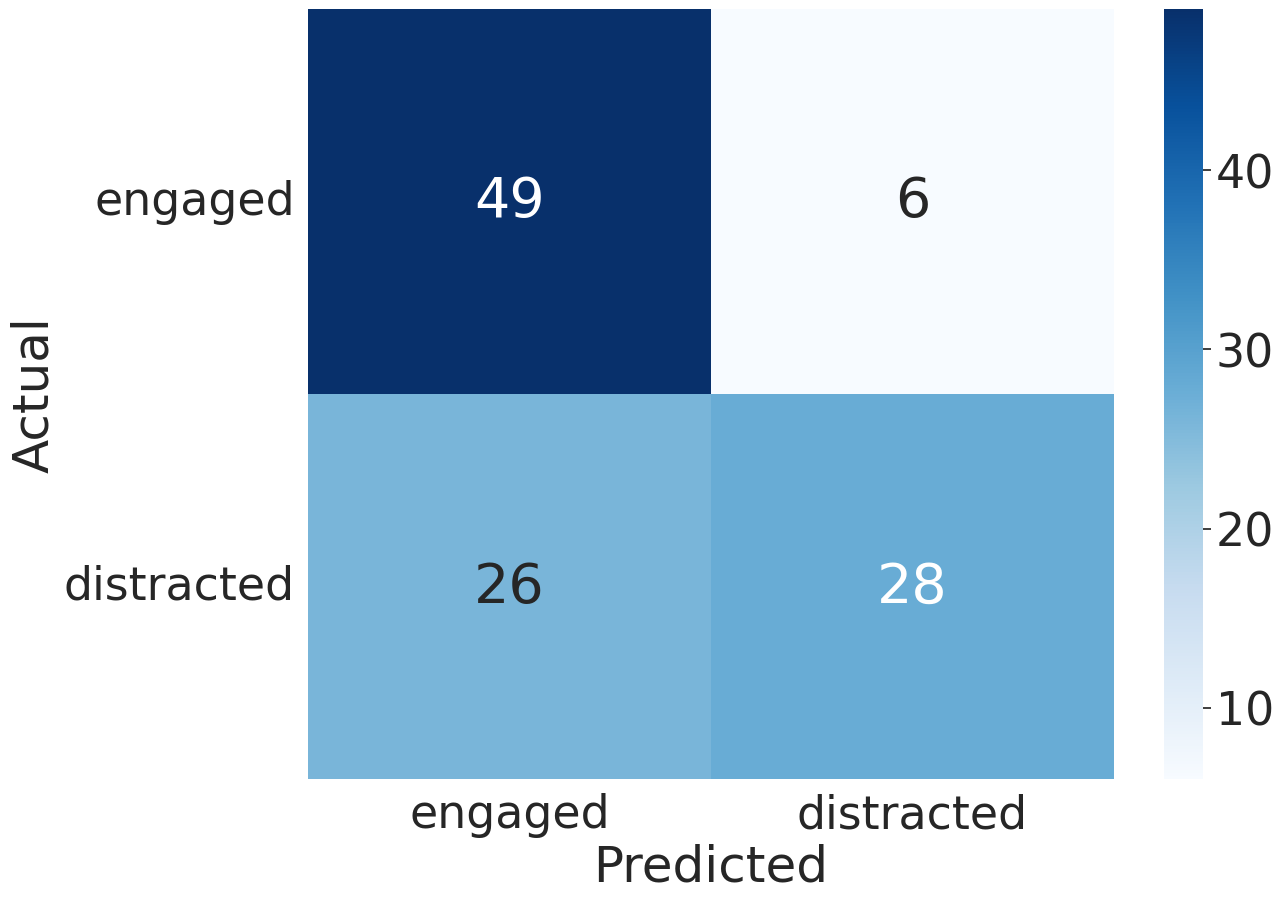

In [284]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [285]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [286]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6181818181818182, MSE: 0.3818181818181818, UAR: 0.6181818181818182, Recall: 0.6, Precision: 0.7483516483516484, F1: 0.5915384615384615
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6, Precision: 0.7535897435897436, F1: 0.6086301617421161
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6181818181818182, Precision: 0.7531135531135531, F1: 0.6198809523809523
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.5818181818181818, Precision: 0.7535897435897436, F1: 0.5844543375662921
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.6181818181818182, Precision: 0.7583516483516484, F1: 0.62431643625192
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6272727272727272, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.5818181818181818, Precision: 0.7535897435897436, F1: 0.5844543375662921
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6, Precision: 0.7535897435897436, F1: 0.6086301617421161
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6, Precision: 0.7535897435897436, F1: 0.6086301617421161
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6, Precision: 0.7535897435897436, F1: 0.6086301617421161
Actor Den
(9, 128, 2560) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2560) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.6, Precision: 0.7535897435897436, F1: 0.6086301617421161


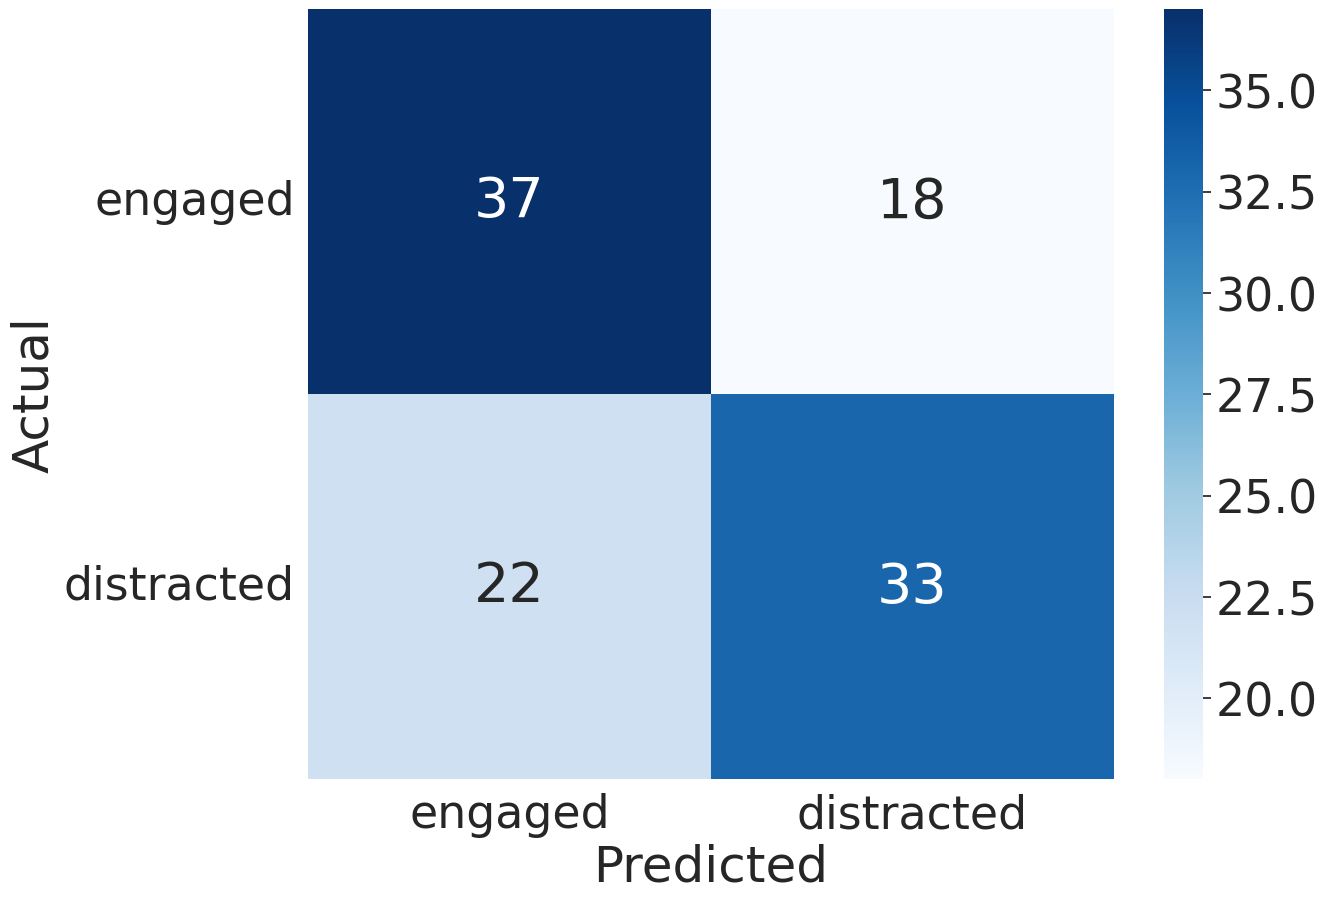

In [287]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [288]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_1
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.41818181818181815, Precision: 0.9777777777777779, F1: 0.48820512820512824
Videos num:  3_1
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.4545454545454546, Precision: 0.85, F1: 0.5548717948717948
Videos num:  4_1
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.5272727272727272, Precision: 0.7576470588235293, F1: 0.5747478991596638
Videos num:  1_2
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_2
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.43636363636363634, Precision: 0.9777777777777779, F1: 0.5164102564102564
Videos num:  3_2
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.4727272727272728, Precision: 0.8166666666666668, F1: 0.5658521870286577
Videos num:  4_2
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.509090909090909, Precision: 0.7576470588235293, F1: 0.5505720749838396
Videos num:  1_3
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_3
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4545454545454545, Precision: 0.9777777777777779, F1: 0.5405860805860806
Videos num:  3_3
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.4727272727272728, Precision: 0.8166666666666668, F1: 0.5658521870286577
Videos num:  4_3
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.509090909090909, Precision: 0.7509803921568627, F1: 0.5491014867485455
Videos num:  1_4
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_4
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4545454545454545, Precision: 0.9777777777777779, F1: 0.5405860805860806
Videos num:  3_4
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.4727272727272728, Precision: 0.8166666666666668, F1: 0.5658521870286577
Videos num:  4_4
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.509090909090909, Precision: 0.7509803921568627, F1: 0.5491014867485455
Videos num:  1_5
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_5
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4545454545454545, Precision: 0.9777777777777779, F1: 0.5405860805860806
Videos num:  3_5
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.309090909090909, UAR: 0.6909090909090909, Recall: 0.4727272727272728, Precision: 0.8066666666666666, F1: 0.564185520361991
Videos num:  4_5
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.3727272727272727, UAR: 0.6272727272727273, Recall: 0.5272727272727272, Precision: 0.7576470588235293, F1: 0.5636673130790777
Videos num:  1_6
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_6
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4545454545454545, Precision: 0.9777777777777779, F1: 0.5405860805860806
Videos num:  3_6
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.309090909090909, UAR: 0.6909090909090909, Recall: 0.4727272727272728, Precision: 0.8066666666666666, F1: 0.564185520361991
Videos num:  4_6
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.509090909090909, Precision: 0.7333333333333334, F1: 0.5406459666094554
Videos num:  1_7
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_7
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.43636363636363634, Precision: 0.9777777777777779, F1: 0.5310622710622711
Videos num:  3_7
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.309090909090909, UAR: 0.6909090909090909, Recall: 0.4727272727272728, Precision: 0.8066666666666666, F1: 0.564185520361991
Videos num:  4_7
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.3727272727272727, UAR: 0.6272727272727272, Recall: 0.509090909090909, Precision: 0.7396825396825397, F1: 0.5428681888316776
Videos num:  1_8
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_8
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7090909090909091, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.43636363636363634, Precision: 0.9777777777777779, F1: 0.5310622710622711
Videos num:  3_8
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.309090909090909, UAR: 0.6909090909090909, Recall: 0.4727272727272728, Precision: 0.8066666666666666, F1: 0.564185520361991
Videos num:  4_8
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.3818181818181818, UAR: 0.6181818181818182, Recall: 0.5272727272727272, Precision: 0.7511111111111111, F1: 0.5587412047046936
Videos num:  1_9
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_9
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4545454545454545, Precision: 0.9777777777777779, F1: 0.5405860805860806
Videos num:  3_9
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090909, MSE: 0.309090909090909, UAR: 0.6909090909090909, Recall: 0.4727272727272728, Precision: 0.8066666666666666, F1: 0.564185520361991
Videos num:  4_9
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.3818181818181818, UAR: 0.6181818181818182, Recall: 0.5272727272727272, Precision: 0.7511111111111111, F1: 0.5587412047046936
Videos num:  1_10
		Actor Den
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 2560) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363637, MSE: 0.33636363636363636, UAR: 0.6636363636363637, Recall: 0.32727272727272727, Precision: 0.8, F1: 0.4160482654600302
Videos num:  2_10
		Actor Den
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2560) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2560) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7181818181818181, MSE: 0.28181818181818186, UAR: 0.7181818181818181, Recall: 0.4545454545454545, Precision: 0.9777777777777779, F1: 0.5405860805860806
Videos num:  3_10
		Actor Den
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2560) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.29999999999999993, UAR: 0.7, Recall: 0.4727272727272728, Precision: 0.8400000000000001, F1: 0.5715384615384616
Videos num:  4_10
		Actor Den
(7, 128, 2560) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2560) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2560) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2560) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_131406/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.3727272727272727, UAR: 0.6272727272727273, Recall: 0.5272727272727272, Precision: 0.7576470588235293, F1: 0.5636673130790777


In [289]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### STAT

In [24]:
stat_func = compute_descriptor
stat_name = "STAT"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [25]:
classificator_name = 'single_attention'

#### Traditional split

In [26]:
split_name = 'traditional_best'

In [27]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [28]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [29]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [30]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3840) (88,)


In [31]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

2024-08-16 05:01:49.630201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 812 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:11:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3841      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

In [32]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [33]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [34]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_traditional_best_Den_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_traditional_best_Kate_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_traditional_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8545454545454545 Recall:  0.8 Precision:  0.8888888888888888 F1:  0.8421052631578948
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_traditional_best_Egor_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.8181818181818182 Precision:  0.6428571428571429 F1:  0.7200000000000001
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_traditional_best_Katya_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.9090909090909091 Precision:  0.7692307692307693 F1:  0.8333333333333333
Total, accuracy: 0.7987012987012987, MSE: 0.2012987012987013, UAR: 0.7981818181818182, Recall: 0.8327272727272728, Precision: 0.8068620268620268, F1: 0.8038740440845704


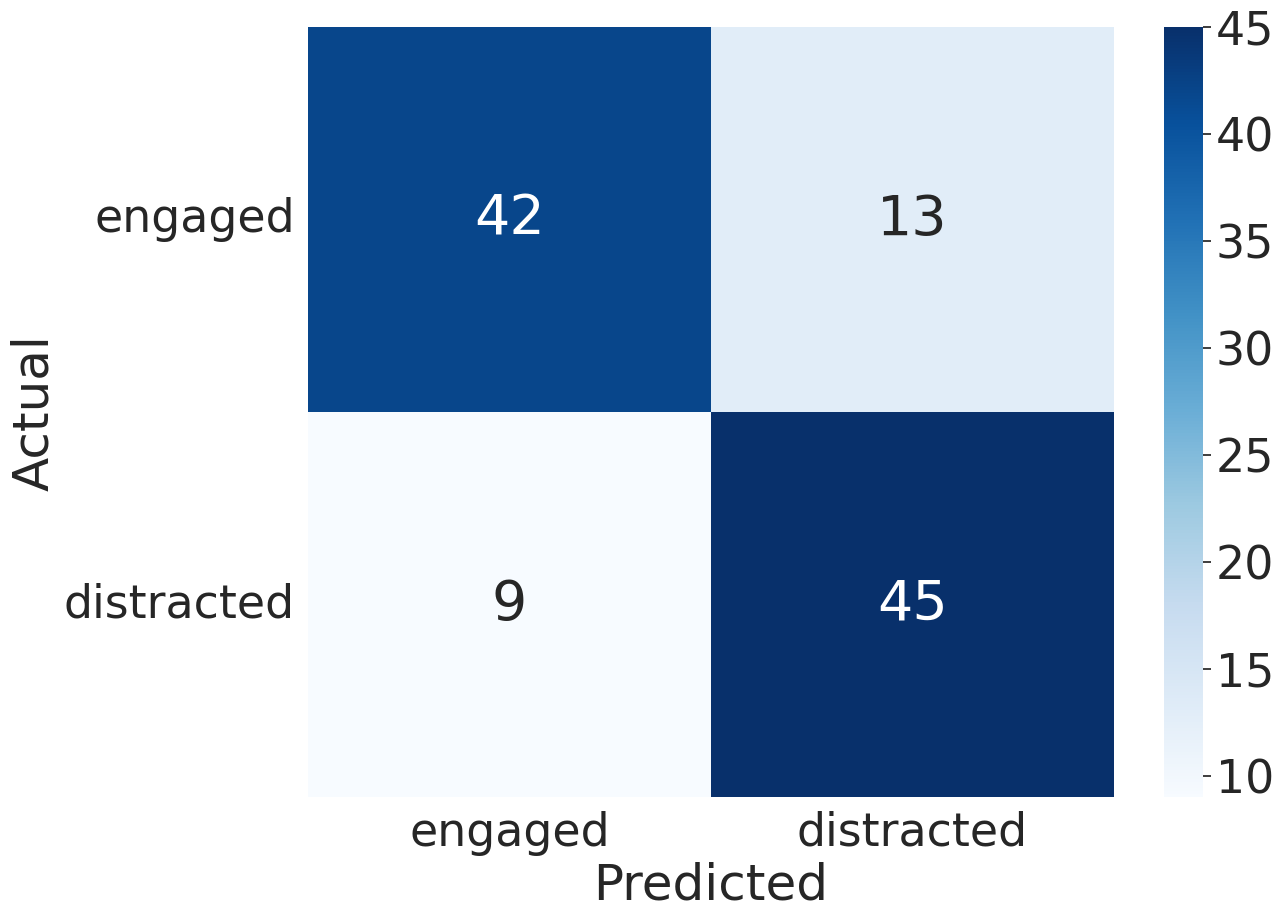

In [35]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [36]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [37]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8, Precision: 0.7478468899521531, F1: 0.7352890247007894
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.8181818181818181, Precision: 0.7660287081339713, F1: 0.7534708428826076
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.8181818181818181, Precision: 0.7660287081339713, F1: 0.7534708428826076
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7000000000000001, MSE: 0.3, UAR: 0.7, Recall: 0.8363636363636363, Precision: 0.7508771929824561, F1: 0.7599447895100069
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7090909090909092, MSE: 0.2909090909090909, UAR: 0.7090909090909091, Recall: 0.8545454545454545, Precision: 0.7508771929824561, F1: 0.7694685990338164
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7000000000000001, MSE: 0.30000000000000004, UAR: 0.7, Recall: 0.8363636363636363, Precision: 0.7478468899521531, F1: 0.7591919191919192
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.6909090909090909, Recall: 0.8, Precision: 0.7642105263157895, F1: 0.7430812324929972
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8181818181818181, Precision: 0.7478468899521531, F1: 0.744812834224599
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6909090909090909, MSE: 0.3090909090909091, UAR: 0.6909090909090909, Recall: 0.8181818181818181, Precision: 0.7508771929824561, F1: 0.7455657045426867
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.8181818181818181, Precision: 0.7660287081339713, F1: 0.7534708428826076


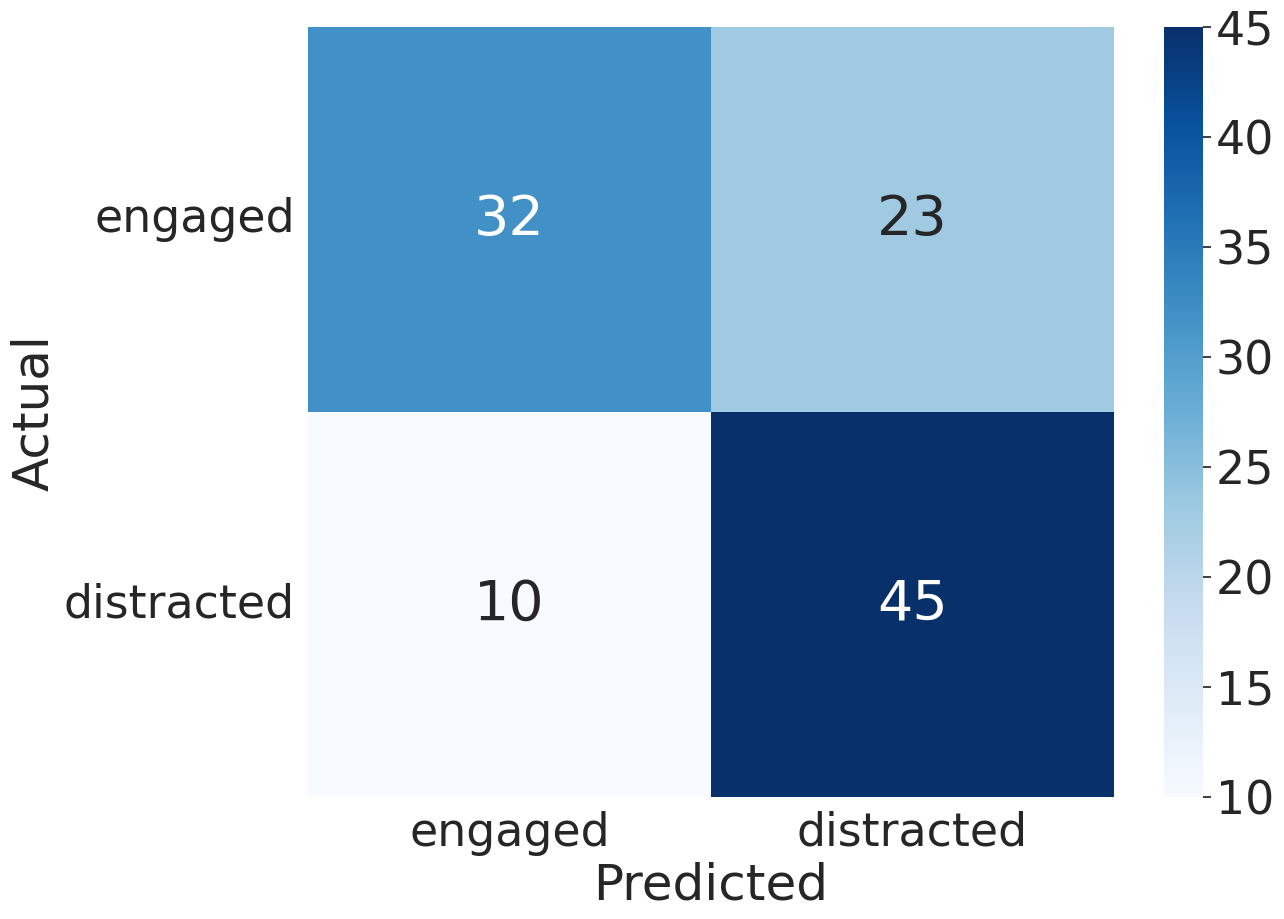

In [38]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [39]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(1, 128, 3840) (1,)


/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(2, 128, 3840) (2,)
		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_1
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)
		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.47272727272727266, Precision: 0.7, F1: 0.4523809523809524
Videos num:  3_1
		Actor Den
(5, 128, 3840) (5,)


2024-08-16 05:03:09.644045: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f63b4002e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-16 05:03:09.644210: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-08-16 05:03:09.648355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 05:03:09.694956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-08-16 05:03:09.758216: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in fu

		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5636363636363637, Precision: 0.775, F1: 0.5646963562753037
Videos num:  4_1
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.5636363636363637, Precision: 0.8, F1: 0.5867787114845937
Videos num:  1_2
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_2
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.4545454545454545, Precision: 0.7, F1: 0.4282051282051282
Videos num:  3_2
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.5454545454545454, Precision: 0.8, F1: 0.5439215686274509
Videos num:  4_2
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363636, MSE: 0.33636363636363636, UAR: 0.6636363636363636, Recall: 0.5818181818181818, Precision: 0.8, F1: 0.605112044817927
Videos num:  1_3
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_3
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.4545454545454545, Precision: 0.7, F1: 0.4282051282051282
Videos num:  3_3
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5454545454545454, Precision: 0.7857142857142858, F1: 0.5399999999999999
Videos num:  4_3
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.5818181818181818, Precision: 0.7523809523809524, F1: 0.5938375350140056
Videos num:  1_4
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_4
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.47272727272727266, Precision: 0.7, F1: 0.4523809523809524
Videos num:  3_4
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5454545454545454, Precision: 0.7857142857142858, F1: 0.5399999999999999
Videos num:  4_4
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.6000000000000001, Precision: 0.788888888888889, F1: 0.6171428571428571
Videos num:  1_5
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_5
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.47272727272727266, Precision: 0.7, F1: 0.4523809523809524
Videos num:  3_5
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5454545454545454, Precision: 0.7857142857142858, F1: 0.5399999999999999
Videos num:  4_5
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.6181818181818182, Precision: 0.7603174603174603, F1: 0.6228571428571428
Videos num:  1_6
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_6
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.4545454545454545, Precision: 0.7, F1: 0.4282051282051282
Videos num:  3_6
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.5454545454545454, Precision: 0.7457142857142858, F1: 0.5333333333333333
Videos num:  4_6
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363636, MSE: 0.33636363636363636, UAR: 0.6636363636363636, Recall: 0.5818181818181818, Precision: 0.8, F1: 0.605112044817927
Videos num:  1_7
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.2657142857142857
Videos num:  2_7
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.4545454545454545, Precision: 0.7, F1: 0.4282051282051282
Videos num:  3_7
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5454545454545454, Precision: 0.7857142857142858, F1: 0.5399999999999999
Videos num:  4_7
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.5818181818181818, Precision: 0.7857142857142858, F1: 0.601190476190476
Videos num:  1_8
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_8
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.47272727272727266, Precision: 0.7, F1: 0.4523809523809524
Videos num:  3_8
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5454545454545454, Precision: 0.7857142857142858, F1: 0.5399999999999999
Videos num:  4_8
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363636, MSE: 0.3363636363636363, UAR: 0.6636363636363637, Recall: 0.6, Precision: 0.7857142857142858, F1: 0.6221428571428571
Videos num:  1_9
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.21818181818181817, Precision: 0.4, F1: 0.2657142857142857
Videos num:  2_9
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.47272727272727266, Precision: 0.7, F1: 0.4523809523809524
Videos num:  3_9
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.5454545454545454, Precision: 0.7457142857142858, F1: 0.5333333333333333
Videos num:  4_9
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.5818181818181818, Precision: 0.7666666666666667, F1: 0.5977591036414566
Videos num:  1_10
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.2, Precision: 0.4, F1: 0.24153846153846156
Videos num:  2_10
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727272, MSE: 0.37272727272727274, UAR: 0.6272727272727272, Recall: 0.4545454545454545, Precision: 0.7, F1: 0.4282051282051282
Videos num:  3_10
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.5636363636363637, Precision: 0.7523809523809524, F1: 0.5509803921568628
Videos num:  4_10
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.5818181818181818, Precision: 0.7857142857142858, F1: 0.601190476190476


In [40]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [41]:
split_name = 'balanced_best'

In [42]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [43]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [44]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [45]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3840) (88,)


In [46]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3841      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [47]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [48]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [49]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_balanced_best_Den_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.9090909090909091 Precision:  0.625 F1:  0.7407407407407406
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_balanced_best_Kate_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_balanced_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7692307692307693 F1:  0.8695652173913044
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_balanced_best_Egor_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  1.0 Precision:  0.55 F1:  0.7096774193548387
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_balanced_best_Katya_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Total, accuracy: 0.7623376623376623, MSE: 0.23766233766233769, UAR: 0.7636363636363637, Recall: 0.9454545454545455, Precision: 0.7263461538461538, F1: 0.8069596384603397


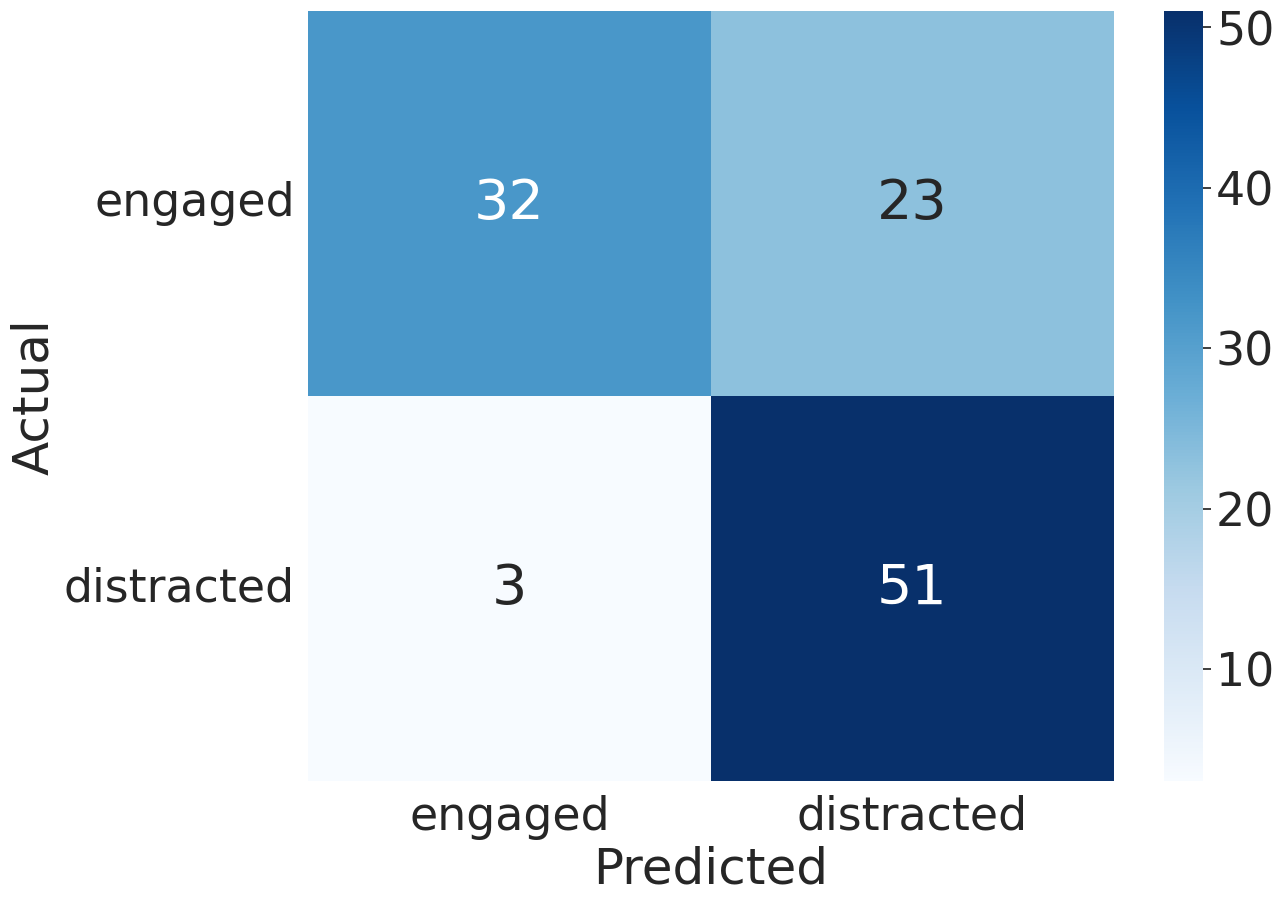

In [50]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [51]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [52]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.7818181818181819, Precision: 0.74, F1: 0.7169546256533174
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8, Precision: 0.74, F1: 0.7313337106206376
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.8363636363636363, Precision: 0.7401913875598086, F1: 0.7543434343434343
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6727272727272727, MSE: 0.3272727272727273, UAR: 0.6727272727272727, Recall: 0.8, Precision: 0.7233333333333334, F1: 0.7250179211469534
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.690909090909091, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8181818181818181, Precision: 0.7455555555555555, F1: 0.7450179211469534
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8, Precision: 0.74, F1: 0.7313337106206376
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8181818181818181, Precision: 0.73, F1: 0.7383512544802867
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.690909090909091, MSE: 0.30909090909090914, UAR: 0.6909090909090909, Recall: 0.8363636363636363, Precision: 0.7354545454545455, F1: 0.7504724666014988
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.8181818181818181, Precision: 0.73, F1: 0.7383512544802867
Actor Den
(9, 128, 3840) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3840) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.6818181818181819, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.8, Precision: 0.7280701754385965, F1: 0.7288888888888889


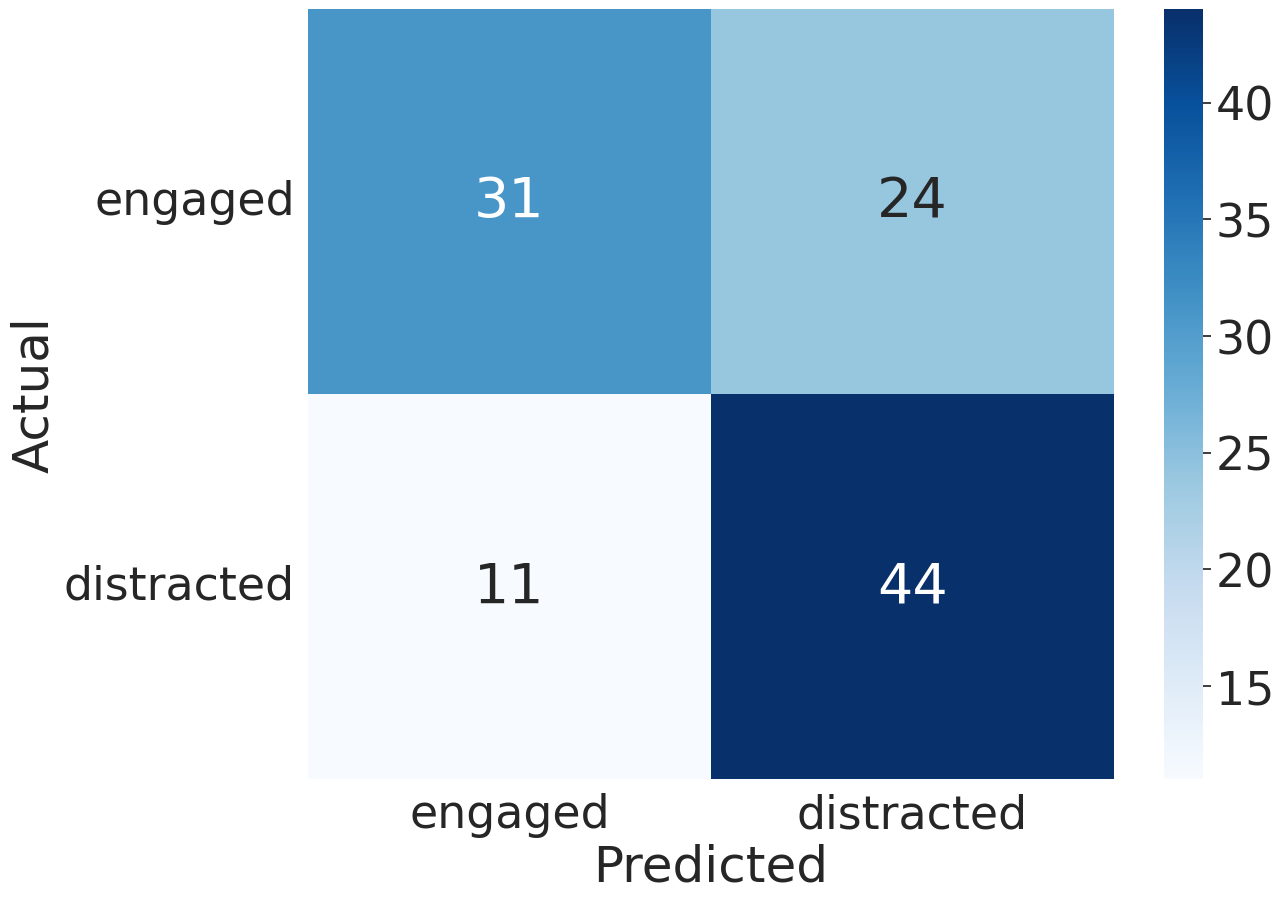

In [53]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [54]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_1
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5272727272727273, Precision: 0.9047619047619048, F1: 0.5462912087912087
Videos num:  3_1
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.5454545454545454, Precision: 0.838095238095238, F1: 0.5241666666666667
Videos num:  4_1
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5636363636363637, Precision: 0.8666666666666668, F1: 0.5740573152337858
Videos num:  1_2
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_2
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5272727272727273, Precision: 0.9047619047619048, F1: 0.5462912087912087
Videos num:  3_2
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.509090909090909, Precision: 0.9099999999999999, F1: 0.5152688172043012
Videos num:  4_2
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5636363636363637, Precision: 0.8666666666666668, F1: 0.5740573152337858
Videos num:  1_3
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_3
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5272727272727273, Precision: 0.9047619047619048, F1: 0.5462912087912087
Videos num:  3_3
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.509090909090909, Precision: 0.9099999999999999, F1: 0.5152688172043012
Videos num:  4_3
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5636363636363637, Precision: 0.8666666666666668, F1: 0.5740573152337858
Videos num:  1_4
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_4
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5454545454545455, Precision: 0.9047619047619048, F1: 0.5672435897435897
Videos num:  3_4
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.509090909090909, Precision: 0.9099999999999999, F1: 0.5152688172043012
Videos num:  4_4
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5636363636363637, Precision: 0.8666666666666668, F1: 0.5740573152337858
Videos num:  1_5
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_5
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090908, MSE: 0.3090909090909091, UAR: 0.6909090909090908, Recall: 0.5636363636363637, Precision: 0.9047619047619048, F1: 0.5855769230769231
Videos num:  3_5
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.509090909090909, Precision: 0.9099999999999999, F1: 0.5152688172043012
Videos num:  4_5
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272726, MSE: 0.32727272727272727, UAR: 0.6727272727272726, Recall: 0.5636363636363637, Precision: 0.8666666666666668, F1: 0.5740573152337858
Videos num:  1_6
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_6
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5454545454545455, Precision: 0.9047619047619048, F1: 0.5672435897435897
Videos num:  3_6
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5272727272727272, Precision: 0.9099999999999999, F1: 0.5434739454094293
Videos num:  4_6
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5814102564102563
Videos num:  1_7
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_7
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5454545454545455, Precision: 0.9047619047619048, F1: 0.5672435897435897
Videos num:  3_7
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5272727272727272, Precision: 0.9099999999999999, F1: 0.5434739454094293
Videos num:  4_7
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5814102564102563
Videos num:  1_8
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_8
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5454545454545455, Precision: 0.9047619047619048, F1: 0.5672435897435897
Videos num:  3_8
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5272727272727272, Precision: 0.9099999999999999, F1: 0.5434739454094293
Videos num:  4_8
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181819, MSE: 0.31818181818181823, UAR: 0.6818181818181819, Recall: 0.5636363636363637, Precision: 0.9, F1: 0.5814102564102563
Videos num:  1_9
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_9
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6909090909090908, MSE: 0.3090909090909091, UAR: 0.6909090909090908, Recall: 0.5636363636363637, Precision: 0.9047619047619048, F1: 0.5855769230769231
Videos num:  3_9
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7, Recall: 0.5636363636363637, Precision: 0.9099999999999999, F1: 0.5779837493309979
Videos num:  4_9
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363636, MSE: 0.3363636363636364, UAR: 0.6636363636363636, Recall: 0.5636363636363637, Precision: 0.8428571428571429, F1: 0.5675213675213675
Videos num:  1_10
		Actor Den
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3840) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.27272727272727276, Precision: 0.5666666666666667, F1: 0.3139130434782609
Videos num:  2_10
		Actor Den
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3840) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3840) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5454545454545455, Precision: 0.9047619047619048, F1: 0.5672435897435897
Videos num:  3_10
		Actor Den
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3840) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6818181818181818, MSE: 0.3181818181818182, UAR: 0.6818181818181819, Recall: 0.5272727272727272, Precision: 0.9099999999999999, F1: 0.5434739454094293
Videos num:  4_10
		Actor Den
(7, 128, 3840) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3840) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3840) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3840) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363636, MSE: 0.3363636363636364, UAR: 0.6636363636363636, Recall: 0.5636363636363637, Precision: 0.8428571428571429, F1: 0.5675213675213675


In [55]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

## MobileNet

In [56]:
base_model_key = 'mobilenet_7.h5'

In [57]:
engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
eng_file2features = load_features(engaged_pickle)
distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
dis_file2features = load_features(distracted_pickle)

In [58]:
video2label = get_video2label(list(eng_file2features.keys()), list(dis_file2features.keys()))

### Std

In [59]:
stat_func = np.std
stat_name = "std"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [60]:
classificator_name = 'single_attention'

#### Traditional split

In [61]:
split_name = 'traditional_best'

In [62]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [63]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [64]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [65]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [66]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [67]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [68]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [69]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_traditional_best_Den_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_traditional_best_Kate_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_traditional_best_Yana_0 Accuracy:  0.7619047619047619 MSE:  0.23809523809523808 UAR:  0.75 Recall:  0.5 Precision:  1.0 F1:  0.6666666666666666
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_traditional_best_Egor_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_traditional_best_Katya_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Total, accuracy: 0.7523809523809523, MSE: 0.24761904761904763, UAR: 0.7499999999999999, Recall: 0.5363636363636364, Precision: 0.96, F1: 0.6681605975723622


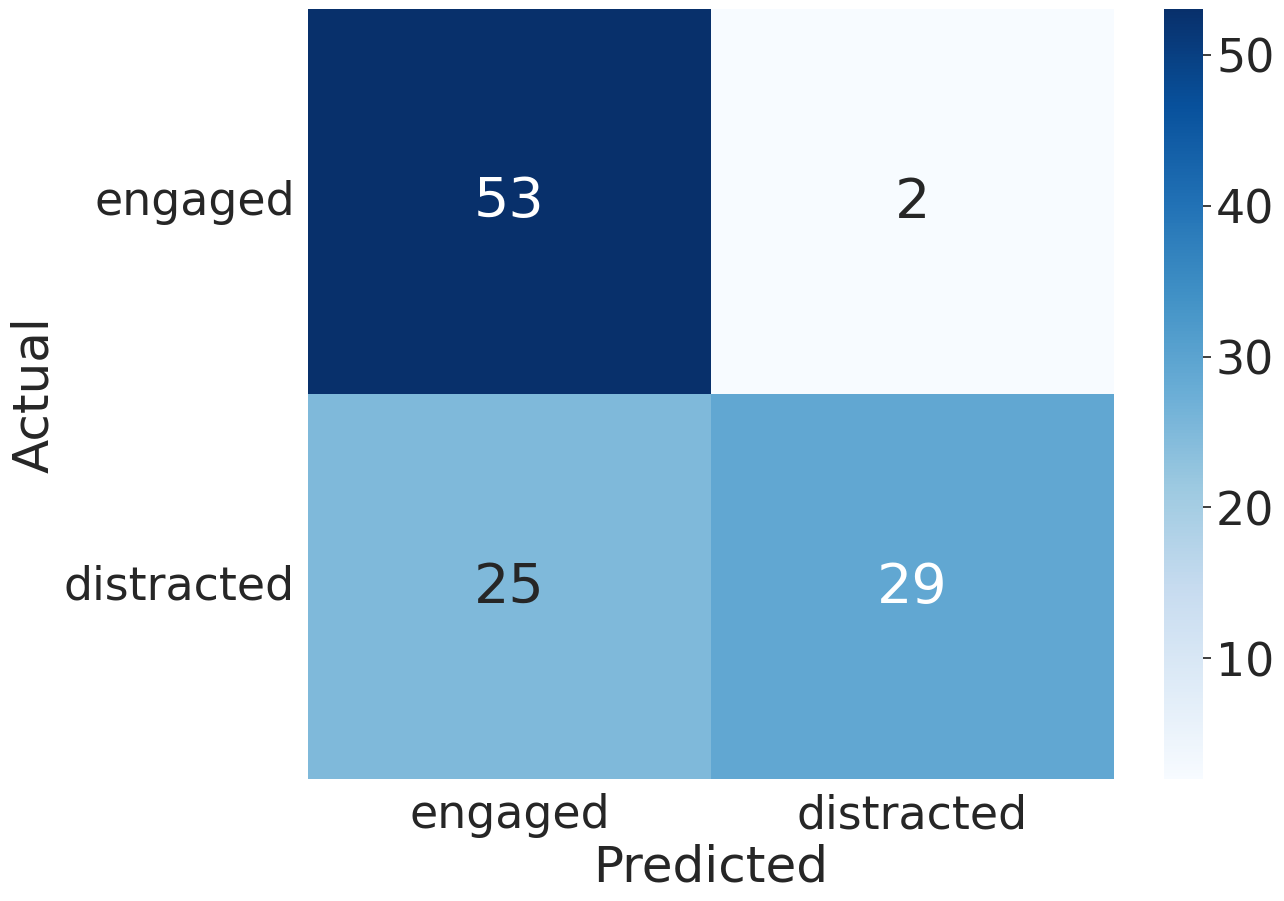

In [70]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [71]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [72]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8090909090909092, MSE: 0.19090909090909092, UAR: 0.8090909090909092, Recall: 0.8, Precision: 0.8597069597069597, F1: 0.7788937728937728
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454545, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8363636363636363, Precision: 0.9041666666666666, F1: 0.8322383252818035
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8363636363636363, Precision: 0.8900641025641025, F1: 0.82426731078905
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.8363636363636363, Precision: 0.93, F1: 0.847201783723523
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8909090909090909, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 0.8363636363636363, Precision: 0.9571428571428571, F1: 0.8626666666666667
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8363636363636363, Precision: 0.9404761904761905, F1: 0.8539710144927536
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.8363636363636363, Precision: 0.9133333333333333, F1: 0.8385061315496098
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8363636363636363, Precision: 0.9404761904761905, F1: 0.8539710144927536
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454545, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8363636363636363, Precision: 0.9041666666666666, F1: 0.8322383252818035
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.8363636363636363, Precision: 0.93, F1: 0.847201783723523


In [73]:
if False:
    draw_loss_acc_graphs(history)

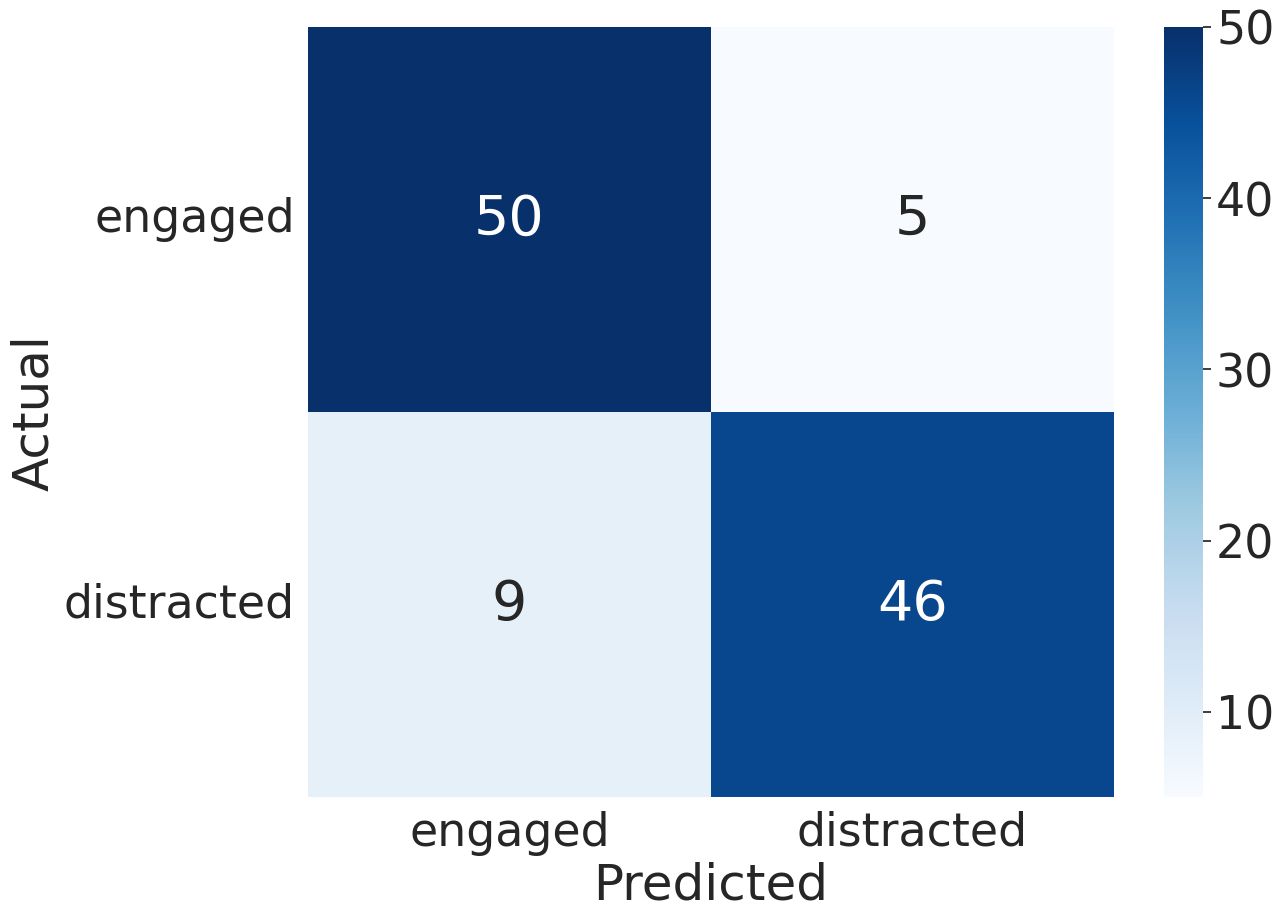

In [74]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [75]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8363636363636363, Precision: 0.8576556776556776, F1: 0.8090402930402931
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8909090909090909, MSE: 0.1090909090909091, UAR: 0.890909090909091, Recall: 0.8181818181818181, Precision: 0.9692307692307693, F1: 0.874985994397759
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8363636363636363, Precision: 0.8923076923076924, F1: 0.8304761904761904
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9692307692307693, F1: 0.863407047029338
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8363636363636363, Precision: 0.8576556776556776, F1: 0.8090402930402931
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9692307692307693, F1: 0.8529308565531476
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.1545454545454545, UAR: 0.8454545454545455, Recall: 0.8363636363636363, Precision: 0.8802197802197803, F1: 0.8231428571428572
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9692307692307693, F1: 0.863407047029338
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.6181818181818182, Precision: 0.7666666666666667, F1: 0.6615320910973084
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.1545454545454545, UAR: 0.8454545454545455, Recall: 0.8363636363636363, Precision: 0.8802197802197803, F1: 0.8231428571428572
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9692307692307693, F1: 0.8529308565531476
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.790909090909091, Recall: 0.6181818181818182, Precision: 0.7666666666666667, F1: 0.6615320910973084
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818183, MSE: 0.1818181818181818, UAR: 0.8181818181818183, Recall: 0.8181818181818181, Precision: 0.8561904761904764, F1: 0.8002866698518872
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8909090909090909, MSE: 0.1090909090909091, UAR: 0.890909090909091, Recall: 0.8181818181818181, Precision: 0.9692307692307693, F1: 0.874985994397759
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.8776556776556778, F1: 0.8137225672877847
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8455975232198142
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.8776556776556778, F1: 0.8137225672877847
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9692307692307693, F1: 0.8645098039215686
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.8776556776556778, F1: 0.8137225672877847
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9692307692307693, F1: 0.8529308565531476
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6363636363636364, MSE: 0.36363636363636365, UAR: 0.6363636363636364, Recall: 0.36363636363636365, Precision: 0.3375, F1: 0.34296296296296297
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6542857142857142
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.1545454545454545, UAR: 0.8454545454545455, Recall: 0.8363636363636363, Precision: 0.8802197802197803, F1: 0.8231428571428572
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9692307692307693, F1: 0.863407047029338


In [76]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [77]:
split_name = 'balanced_best'

In [78]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [79]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [80]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [81]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [82]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [83]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [84]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [85]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_balanced_best_Den_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_balanced_best_Kate_0 Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_balanced_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8545454545454545 Recall:  0.8 Precision:  0.8888888888888888 F1:  0.8421052631578948
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_balanced_best_Egor_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_balanced_best_Katya_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.6363636363636364 Precision:  0.875 F1:  0.7368421052631579
Total, accuracy: 0.8259740259740258, MSE: 0.17402597402597403, UAR: 0.8254545454545454, Recall: 0.7418181818181819, Precision: 0.8905555555555555, F1: 0.8081704260651629


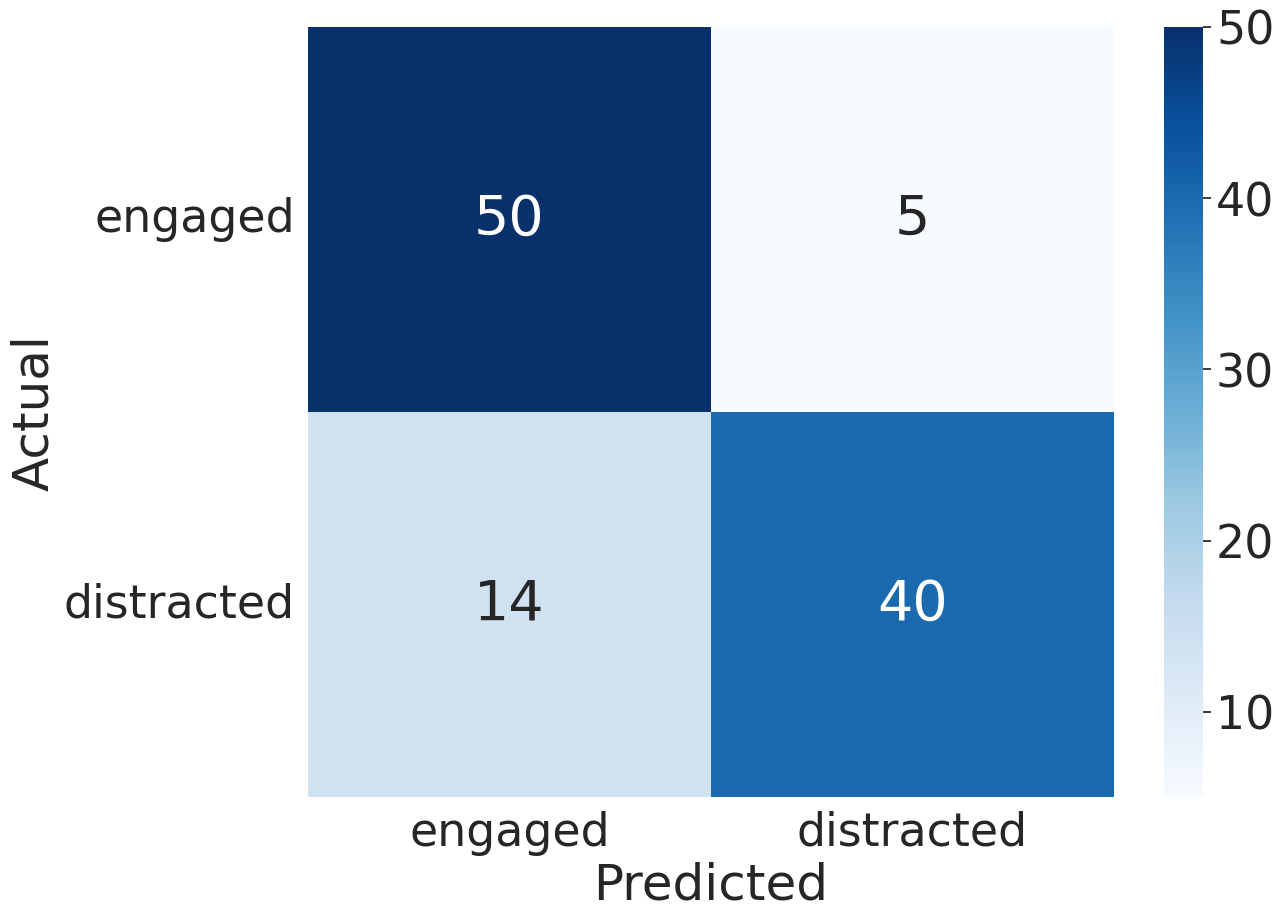

In [86]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [87]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [88]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.8181818181818181, Precision: 0.8609890109890109, F1: 0.805855072463768
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.873076923076923, F1: 0.8131884057971014
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.882867132867133, F1: 0.8101581027667983
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727276, UAR: 0.8272727272727274, Recall: 0.7818181818181819, Precision: 0.8867132867132866, F1: 0.8003030303030302
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545457, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.8867132867132866, F1: 0.8203030303030303
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545457, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.8867132867132866, F1: 0.8203030303030303
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545457, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.8867132867132866, F1: 0.8203030303030303
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727276, UAR: 0.8272727272727274, Recall: 0.7818181818181819, Precision: 0.8867132867132866, F1: 0.8003030303030302
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727276, UAR: 0.8272727272727274, Recall: 0.7818181818181819, Precision: 0.8867132867132866, F1: 0.8003030303030302
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.7636363636363637, Precision: 0.882867132867133, F1: 0.7901581027667983


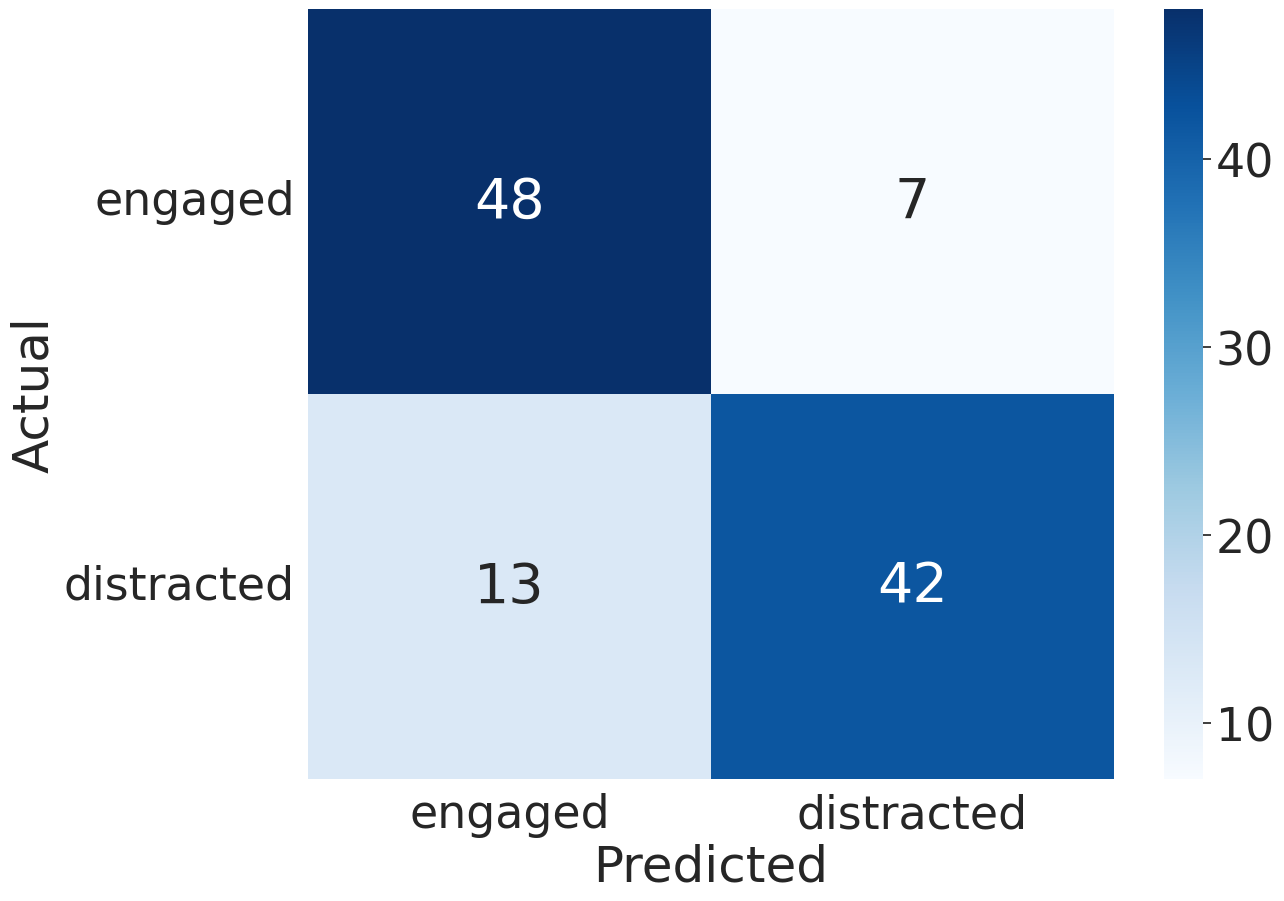

In [89]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [90]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6181818181818182, Precision: 0.7428571428571429, F1: 0.6466666666666667
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8363636363636363, Precision: 0.932867132867133, F1: 0.8709463051568314
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 0.8181818181818181, Precision: 0.9818181818181818, F1: 0.8857947900053164
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6, Precision: 0.76, F1: 0.6495238095238095
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 0.8363636363636363, Precision: 0.9692307692307693, F1: 0.8873099415204677
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9666666666666668, F1: 0.8539867571742656
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.3545454545454545, UAR: 0.6454545454545455, Recall: 0.34545454545454546, Precision: 0.3571428571428571, F1: 0.34442105263157896
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6181818181818182, Precision: 0.7538461538461538, F1: 0.6533333333333333
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.8363636363636363, Precision: 0.932867132867133, F1: 0.8709463051568314
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9666666666666668, F1: 0.8473340961098398
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6, Precision: 0.78, F1: 0.6580952380952381
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.8181818181818181, Precision: 0.937142857142857, F1: 0.8618813700918964
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7636363636363637, Precision: 0.9818181818181818, F1: 0.8369059011164275
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6371428571428572
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.8181818181818181, Precision: 0.932867132867133, F1: 0.8614224956330219
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9818181818181818, F1: 0.8552392344497608
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6181818181818182, Precision: 0.7428571428571429, F1: 0.6466666666666667
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9666666666666668, F1: 0.8683658421415859
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 0.8, Precision: 0.9818181818181818, F1: 0.871415705037996
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6, Precision: 0.78, F1: 0.6580952380952381
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9666666666666668, F1: 0.8683658421415859
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 0.8, Precision: 0.9818181818181818, F1: 0.871415705037996
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.3545454545454545, UAR: 0.6454545454545455, Recall: 0.34545454545454546, Precision: 0.3571428571428571, F1: 0.34442105263157896
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6181818181818182, Precision: 0.7466666666666667, F1: 0.6520082815734989
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 0.8181818181818181, Precision: 0.9692307692307693, F1: 0.8777861319966582
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9818181818181818, F1: 0.8618918955141865
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545455, MSE: 0.3545454545454545, UAR: 0.6454545454545455, Recall: 0.34545454545454546, Precision: 0.3571428571428571, F1: 0.34442105263157896
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6, Precision: 0.76, F1: 0.6495238095238095
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9666666666666668, F1: 0.8635105666980751
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7636363636363637, Precision: 0.9818181818181818, F1: 0.8457154249259512
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.34545454545454546, Precision: 0.36923076923076925, F1: 0.35175438596491226
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6, Precision: 0.76, F1: 0.6495238095238095
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 0.8363636363636363, Precision: 0.9692307692307693, F1: 0.8873099415204677
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9818181818181818, F1: 0.8552392344497608


In [91]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### Max

In [92]:
stat_func = np.max
stat_name = "max"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [93]:
classificator_name = 'single_attention'

#### Traditional split

In [94]:
split_name = 'traditional_best'

In [95]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [96]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [97]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [98]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [99]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [100]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [101]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [102]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_traditional_best_Den_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_traditional_best_Kate_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_traditional_best_Yana_0 Accuracy:  0.7142857142857143 MSE:  0.2857142857142857 UAR:  0.7 Recall:  0.4 Precision:  1.0 F1:  0.5714285714285715
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_traditional_best_Egor_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.45454545454545453 Precision:  0.7142857142857143 F1:  0.5555555555555556
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_traditional_best_Katya_0 Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.09090909090909091 Precision:  1.0 F1:  0.16666666666666669
Total, accuracy: 0.6428571428571428, MSE: 0.35714285714285715, UAR: 0.64, Recall: 0.31636363636363635, Precision: 0.9428571428571428, F1: 0.451111111111111


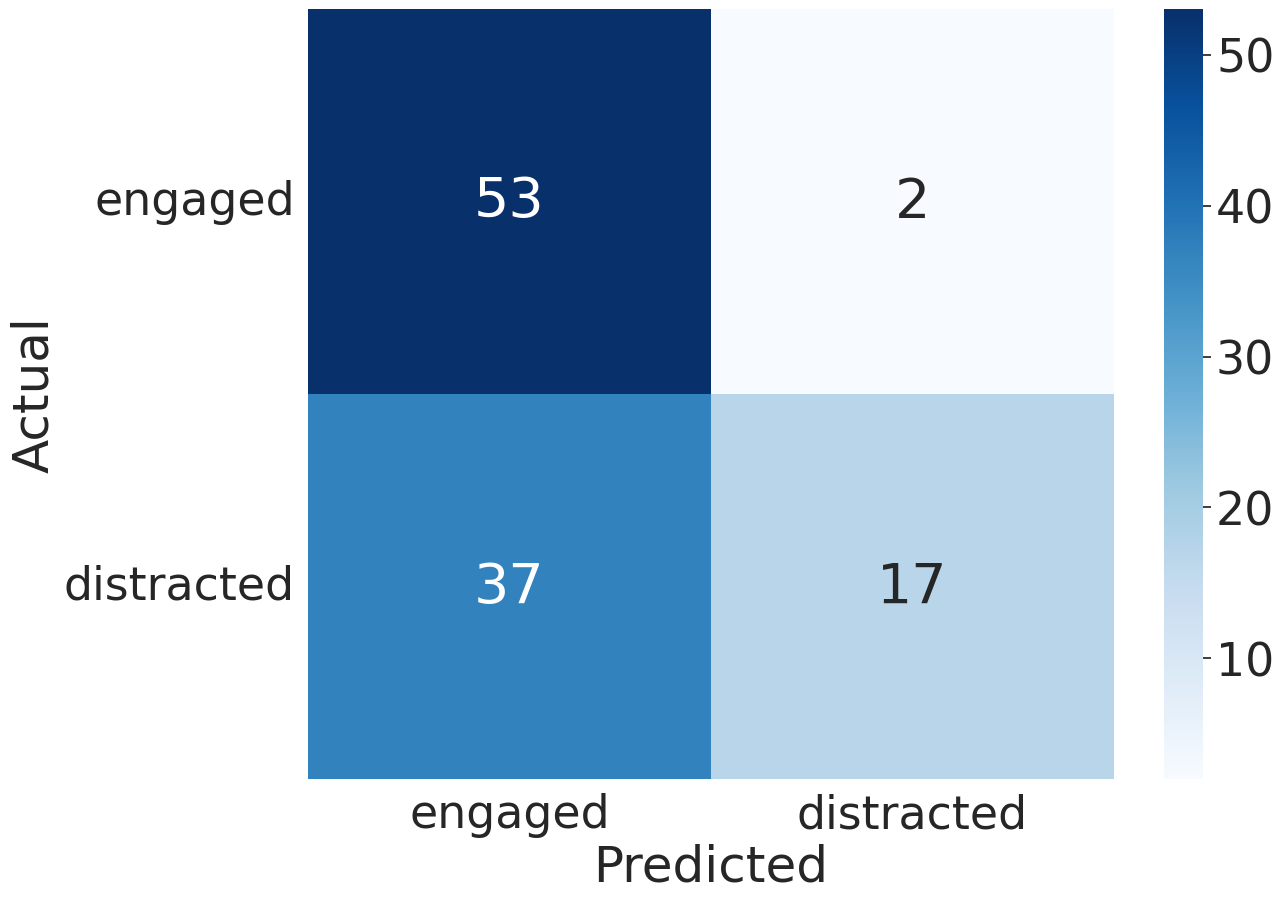

In [103]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [104]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [105]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.7090909090909092, Precision: 0.8190909090909091, F1: 0.7051617313077415
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.6545454545454545, Precision: 0.9157894736842106, F1: 0.7006027890238417
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.690909090909091, Precision: 0.9157894736842106, F1: 0.7250472334682861
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.6727272727272728, Precision: 0.9099999999999999, F1: 0.7087371033041661
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.6545454545454545, Precision: 0.9157894736842106, F1: 0.7006027890238417
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.690909090909091, Precision: 0.9157894736842106, F1: 0.7250472334682861
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.6545454545454545, Precision: 0.9157894736842106, F1: 0.7006027890238417
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.6545454545454545, Precision: 0.9157894736842106, F1: 0.7006027890238417
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.690909090909091, Precision: 0.9157894736842106, F1: 0.7250472334682861
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.690909090909091, Precision: 0.9099999999999999, F1: 0.7203160506725872


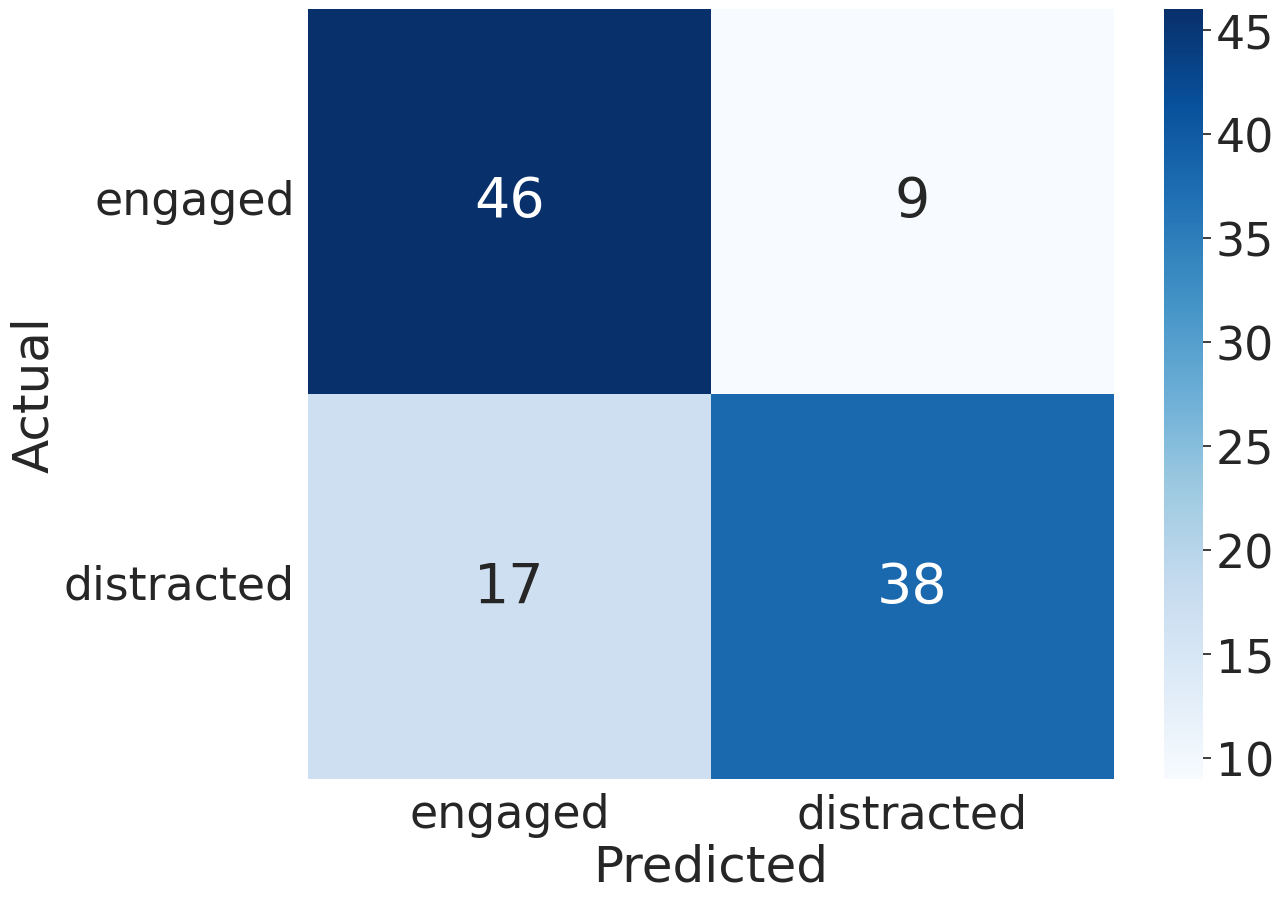

In [106]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [107]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.590909090909091, MSE: 0.40909090909090906, UAR: 0.590909090909091, Recall: 0.2909090909090909, Precision: 0.32941176470588235, F1: 0.28214285714285714
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6636363636363636, MSE: 0.3363636363636363, UAR: 0.6636363636363636, Recall: 0.4727272727272728, Precision: 0.7058823529411764, F1: 0.4935574229691877
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7272727272727273, Precision: 0.8612440191387559, F1: 0.7367327409432672
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6909090909090909, Precision: 0.9294117647058823, F1: 0.7510177404295051
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.2909090909090909, Precision: 0.32222222222222224, F1: 0.2767241379310345
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.4727272727272728, Precision: 0.7125, F1: 0.49831932773109244
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.23636363636363633, UAR: 0.7636363636363637, Recall: 0.7454545454545455, Precision: 0.854251012145749, F1: 0.7412781954887219
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090908, MSE: 0.40909090909090906, UAR: 0.5909090909090908, Recall: 0.3090909090909091, Precision: 0.32222222222222224, F1: 0.29290060851926975
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.4545454545454546, Precision: 0.7058823529411764, F1: 0.47738095238095235
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272728, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.6545454545454545, Precision: 0.9294117647058823, F1: 0.7261624649859943
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272726, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.3090909090909091, Precision: 0.31, F1: 0.283111954459203
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.4909090909090909, Precision: 0.711111111111111, F1: 0.5029170288805178
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.2909090909090909, Precision: 0.32222222222222224, F1: 0.2767241379310345
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.4363636363636364, Precision: 0.7125, F1: 0.4638095238095238
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090908, MSE: 0.40909090909090906, UAR: 0.5909090909090908, Recall: 0.3090909090909091, Precision: 0.32222222222222224, F1: 0.29290060851926975
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.4363636363636364, Precision: 0.7125, F1: 0.4638095238095238
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272728, MSE: 0.22727272727272724, UAR: 0.7727272727272728, Recall: 0.6545454545454545, Precision: 0.9294117647058823, F1: 0.7261624649859943
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.2909090909090909, Precision: 0.32222222222222224, F1: 0.2767241379310345
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.4545454545454546, Precision: 0.711111111111111, F1: 0.4684072249589491
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.43636363636363634, UAR: 0.5636363636363637, Recall: 0.2909090909090909, Precision: 0.31, F1: 0.26693548387096777
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.4545454545454546, Precision: 0.711111111111111, F1: 0.4684072249589491
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5909090909090908, MSE: 0.40909090909090906, UAR: 0.5909090909090908, Recall: 0.3090909090909091, Precision: 0.32222222222222224, F1: 0.29290060851926975
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.4727272727272728, Precision: 0.7125, F1: 0.49831932773109244
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272726, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.3090909090909091, Precision: 0.31, F1: 0.283111954459203
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.34545454545454546, UAR: 0.6545454545454545, Recall: 0.4545454545454546, Precision: 0.711111111111111, F1: 0.4684072249589491
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.7454545454545455, Precision: 0.8443609022556391, F1: 0.7352781954887219
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.6727272727272727, Precision: 0.9294117647058823, F1: 0.7405415499533146


In [108]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [109]:
split_name = 'balanced_best'

In [110]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [111]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [112]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [113]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 2048) (88,)


In [114]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [115]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [116]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [117]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_balanced_best_Den_0 Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923077
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_balanced_best_Kate_0 Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_balanced_best_Yana_0 Accuracy:  0.9047619047619048 MSE:  0.09523809523809523 UAR:  0.9 Recall:  0.8 Precision:  1.0 F1:  0.888888888888889
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_balanced_best_Egor_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.5454545454545454 Precision:  0.8571428571428571 F1:  0.6666666666666665
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_balanced_best_Katya_0 Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Total, accuracy: 0.7082251082251083, MSE: 0.2917748917748918, UAR: 0.7072727272727273, Recall: 0.43272727272727274, Precision: 0.9714285714285715, F1: 0.565030525030525


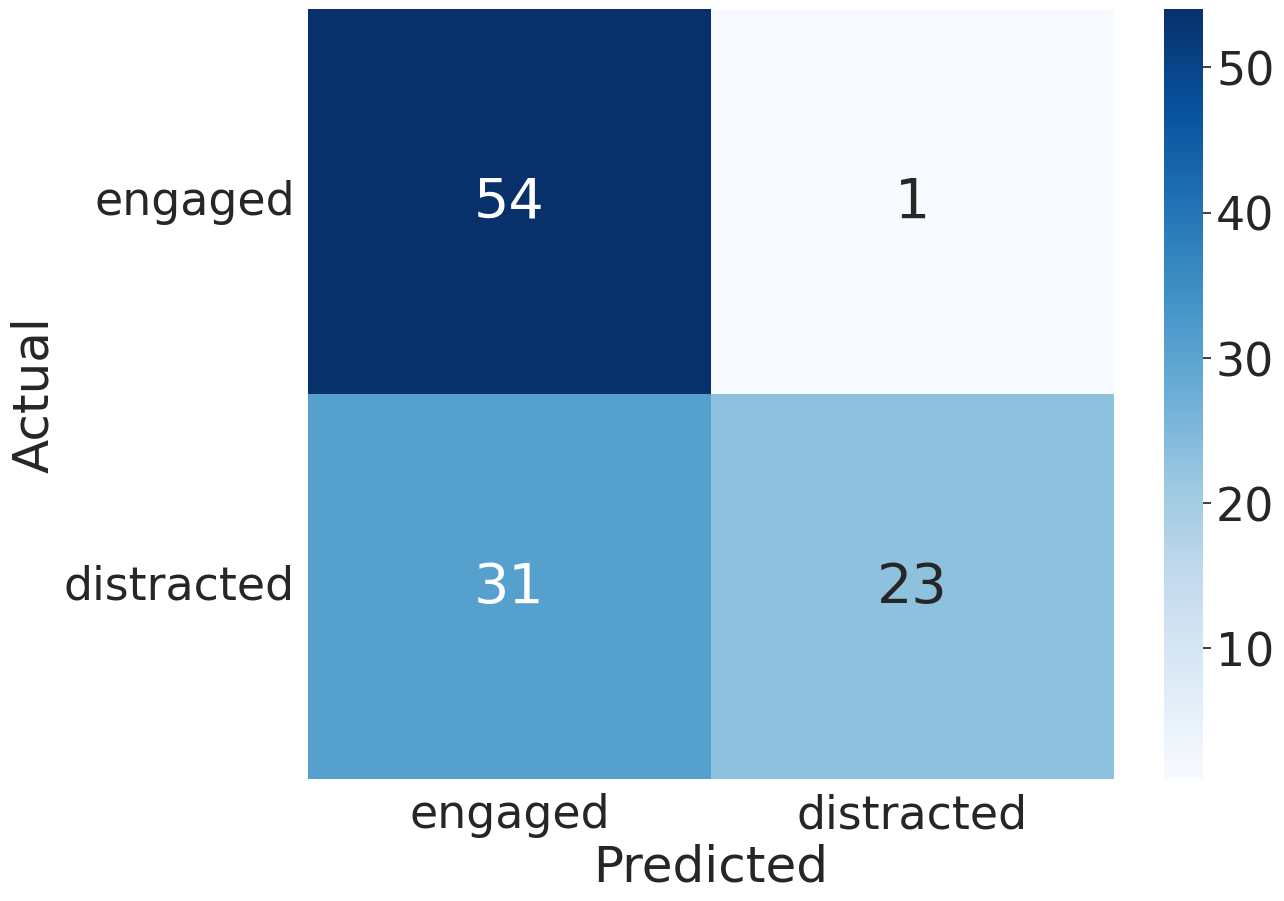

In [118]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [119]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [120]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454545, Recall: 0.6727272727272726, Precision: 0.8935672514619883, F1: 0.7163575605680869
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.781818181818182, MSE: 0.21818181818181817, UAR: 0.7818181818181817, Recall: 0.6727272727272726, Precision: 0.9175000000000001, F1: 0.7199066041171305
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6545454545454545, Precision: 0.9466666666666667, F1: 0.720366753989045
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6727272727272726, Precision: 0.9375, F1: 0.728478032688559
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.781818181818182, MSE: 0.21818181818181817, UAR: 0.781818181818182, Recall: 0.6363636363636364, Precision: 0.9466666666666667, F1: 0.7087878066206239
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6727272727272726, Precision: 0.9266666666666665, F1: 0.7261744103849367
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8, MSE: 0.2, UAR: 0.8, Recall: 0.6727272727272726, Precision: 0.9466666666666667, F1: 0.7347458389563652
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.781818181818182, MSE: 0.21818181818181817, UAR: 0.7818181818181817, Recall: 0.6727272727272726, Precision: 0.9175000000000001, F1: 0.7199066041171305
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6545454545454545, Precision: 0.9466666666666667, F1: 0.720366753989045
Actor Den
(9, 128, 2048) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 2048) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.790909090909091, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.6545454545454545, Precision: 0.9466666666666667, F1: 0.7231668915879442


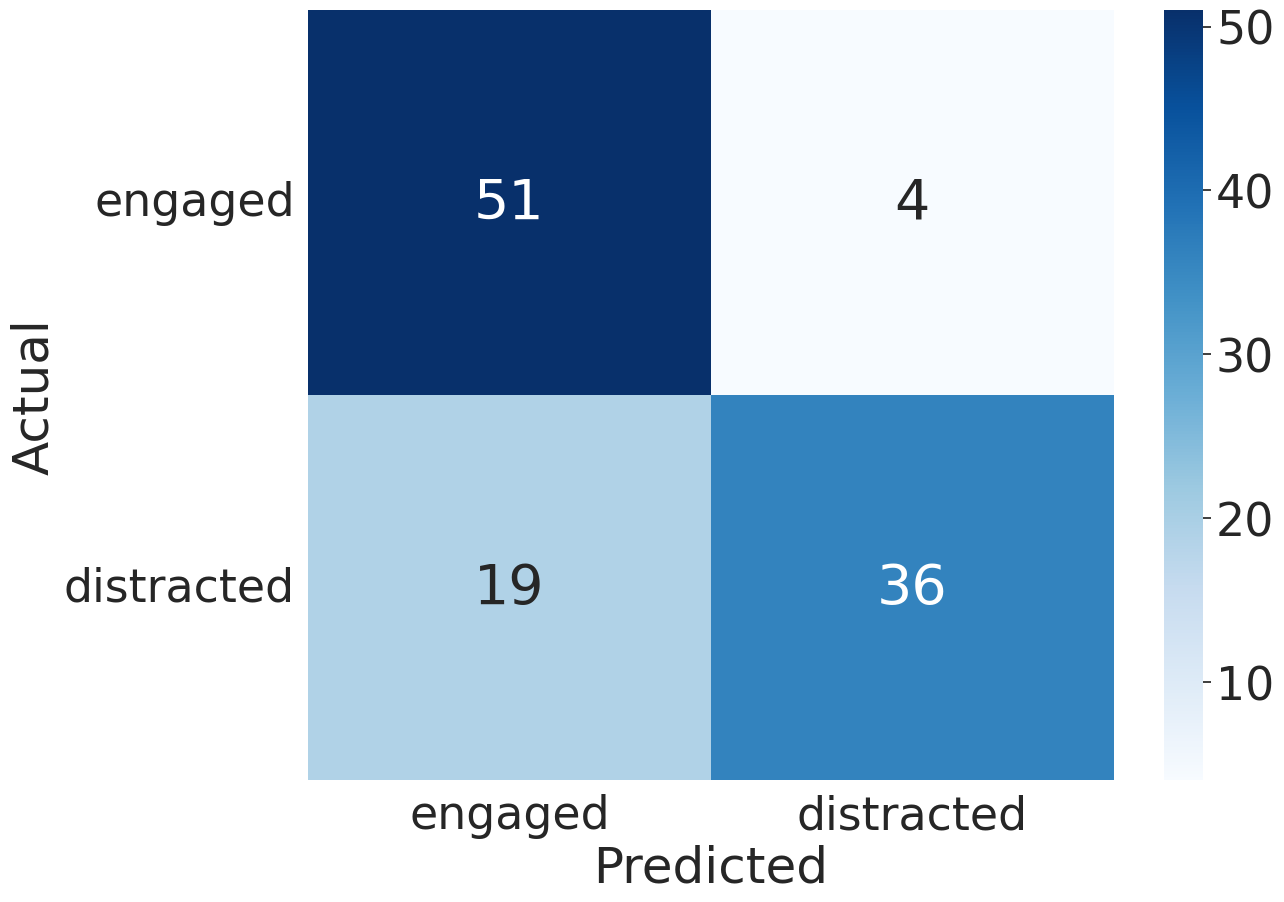

In [121]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [122]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272726, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.3090909090909091, Precision: 0.31, F1: 0.283111954459203
Videos num:  2_1
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.41818181818181815, Precision: 0.7125, F1: 0.4428571428571429
Videos num:  3_1
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.7270359468651344
Videos num:  4_1
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363638, MSE: 0.23636363636363633, UAR: 0.7636363636363638, Recall: 0.5818181818181818, Precision: 0.9538461538461538, F1: 0.6917543859649122
Videos num:  1_2
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272726, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.3090909090909091, Precision: 0.31, F1: 0.283111954459203
Videos num:  2_2
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.41818181818181815, Precision: 0.7384615384615385, F1: 0.4595238095238095
Videos num:  3_2
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363636, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.7154569994967134
Videos num:  4_2
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7272727272727273, MSE: 0.27272727272727276, UAR: 0.7272727272727273, Recall: 0.5090909090909091, Precision: 0.9538461538461538, F1: 0.6073404665509928
Videos num:  1_3
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5818181818181818, MSE: 0.41818181818181815, UAR: 0.5818181818181818, Recall: 0.32727272727272727, Precision: 0.31, F1: 0.29749103942652333
Videos num:  2_3
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6545454545454545, MSE: 0.3454545454545454, UAR: 0.6545454545454545, Recall: 0.41818181818181815, Precision: 0.72, F1: 0.447985347985348
Videos num:  3_3
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363636, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.7154569994967134
Videos num:  4_3
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.26363636363636367, UAR: 0.7363636363636364, Recall: 0.5272727272727273, Precision: 0.9538461538461538, F1: 0.631516290726817
Videos num:  1_4
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272728, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.32727272727272727, Precision: 0.30476190476190473, F1: 0.29305555555555557
Videos num:  2_4
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.41818181818181815, Precision: 0.7125, F1: 0.4428571428571429
Videos num:  3_4
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363636, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.7154569994967134
Videos num:  4_4
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.5636363636363637, Precision: 0.9538461538461538, F1: 0.6708020050125313
Videos num:  1_5
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.43636363636363634, UAR: 0.5636363636363637, Recall: 0.3090909090909091, Precision: 0.30476190476190473, F1: 0.2786764705882353
Videos num:  2_5
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.41818181818181815, Precision: 0.7125, F1: 0.4428571428571429
Videos num:  3_5
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.7270359468651344
Videos num:  4_5
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.26363636363636367, UAR: 0.7363636363636364, Recall: 0.5272727272727273, Precision: 0.9538461538461538, F1: 0.6282928475033738
Videos num:  1_6
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.43636363636363634, UAR: 0.5636363636363637, Recall: 0.3090909090909091, Precision: 0.30476190476190473, F1: 0.2786764705882353
Videos num:  2_6
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.41818181818181815, Precision: 0.7384615384615385, F1: 0.4595238095238095
Videos num:  3_6
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.7270359468651344
Videos num:  4_6
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454546, UAR: 0.7454545454545456, Recall: 0.5454545454545455, Precision: 0.9538461538461538, F1: 0.652468671679198
Videos num:  1_7
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272726, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.3090909090909091, Precision: 0.31, F1: 0.283111954459203
Videos num:  2_7
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.41818181818181815, Precision: 0.7384615384615385, F1: 0.4595238095238095
Videos num:  3_7
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.7270359468651344
Videos num:  4_7
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7, MSE: 0.3, UAR: 0.7000000000000001, Recall: 0.5272727272727273, Precision: 0.9222222222222222, F1: 0.5923979378153608
Videos num:  1_8
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.43636363636363634, UAR: 0.5636363636363637, Recall: 0.3090909090909091, Precision: 0.30476190476190473, F1: 0.2786764705882353
Videos num:  2_8
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.41818181818181815, Precision: 0.7384615384615385, F1: 0.4595238095238095
Videos num:  3_8
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.7270359468651344
Videos num:  4_8
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7454545454545455, MSE: 0.2545454545454545, UAR: 0.7454545454545455, Recall: 0.5272727272727273, Precision: 0.9666666666666668, F1: 0.6387626675384113
Videos num:  1_9
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5727272727272726, MSE: 0.42727272727272725, UAR: 0.5727272727272726, Recall: 0.3090909090909091, Precision: 0.31, F1: 0.283111954459203
Videos num:  2_9
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6727272727272727, MSE: 0.32727272727272727, UAR: 0.6727272727272727, Recall: 0.41818181818181815, Precision: 0.7384615384615385, F1: 0.4595238095238095
Videos num:  3_9
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7727272727272727, MSE: 0.22727272727272724, UAR: 0.7727272727272727, Recall: 0.6727272727272727, Precision: 0.9222222222222222, F1: 0.7270359468651344
Videos num:  4_9
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454546, MSE: 0.24545454545454543, UAR: 0.7545454545454546, Recall: 0.5636363636363637, Precision: 0.9538461538461538, F1: 0.6708020050125313
Videos num:  1_10
		Actor Den
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 2048) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.5636363636363637, MSE: 0.43636363636363634, UAR: 0.5636363636363637, Recall: 0.3090909090909091, Precision: 0.30476190476190473, F1: 0.2786764705882353
Videos num:  2_10
		Actor Den
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 2048) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 2048) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6454545454545454, MSE: 0.35454545454545455, UAR: 0.6454545454545454, Recall: 0.41818181818181815, Precision: 0.7125, F1: 0.4428571428571429
Videos num:  3_10
		Actor Den
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 2048) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363636, MSE: 0.23636363636363633, UAR: 0.7636363636363636, Recall: 0.6545454545454545, Precision: 0.9222222222222222, F1: 0.7154569994967134
Videos num:  4_10
		Actor Den
(7, 128, 2048) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 2048) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 2048) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 2048) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7363636363636364, MSE: 0.26363636363636367, UAR: 0.7363636363636364, Recall: 0.5272727272727273, Precision: 0.9538461538461538, F1: 0.6282928475033738


In [123]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

### STAT

In [124]:
stat_func = compute_descriptor
stat_name = "STAT"
TABLE_NAME = "04_User-adaptation-{}-{}-{}.xlsx".format(DATASET_NAME, base_model_key, stat_name)

***Single attention***

In [125]:
classificator_name = 'single_attention'

#### Traditional split

In [126]:
split_name = 'traditional_best'

In [127]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [128]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [129]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [130]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3072) (88,)


In [131]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3073      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [132]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [133]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [134]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_traditional_best_Den_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_traditional_best_Kate_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_traditional_best_Yana_0 Accuracy:  0.7619047619047619 MSE:  0.23809523809523808 UAR:  0.75 Recall:  0.5 Precision:  1.0 F1:  0.6666666666666666
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_traditional_best_Egor_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_traditional_best_Katya_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Total, accuracy: 0.7705627705627706, MSE: 0.2294372294372294, UAR: 0.7681818181818182, Recall: 0.5727272727272728, Precision: 0.96, F1: 0.7041353383458646


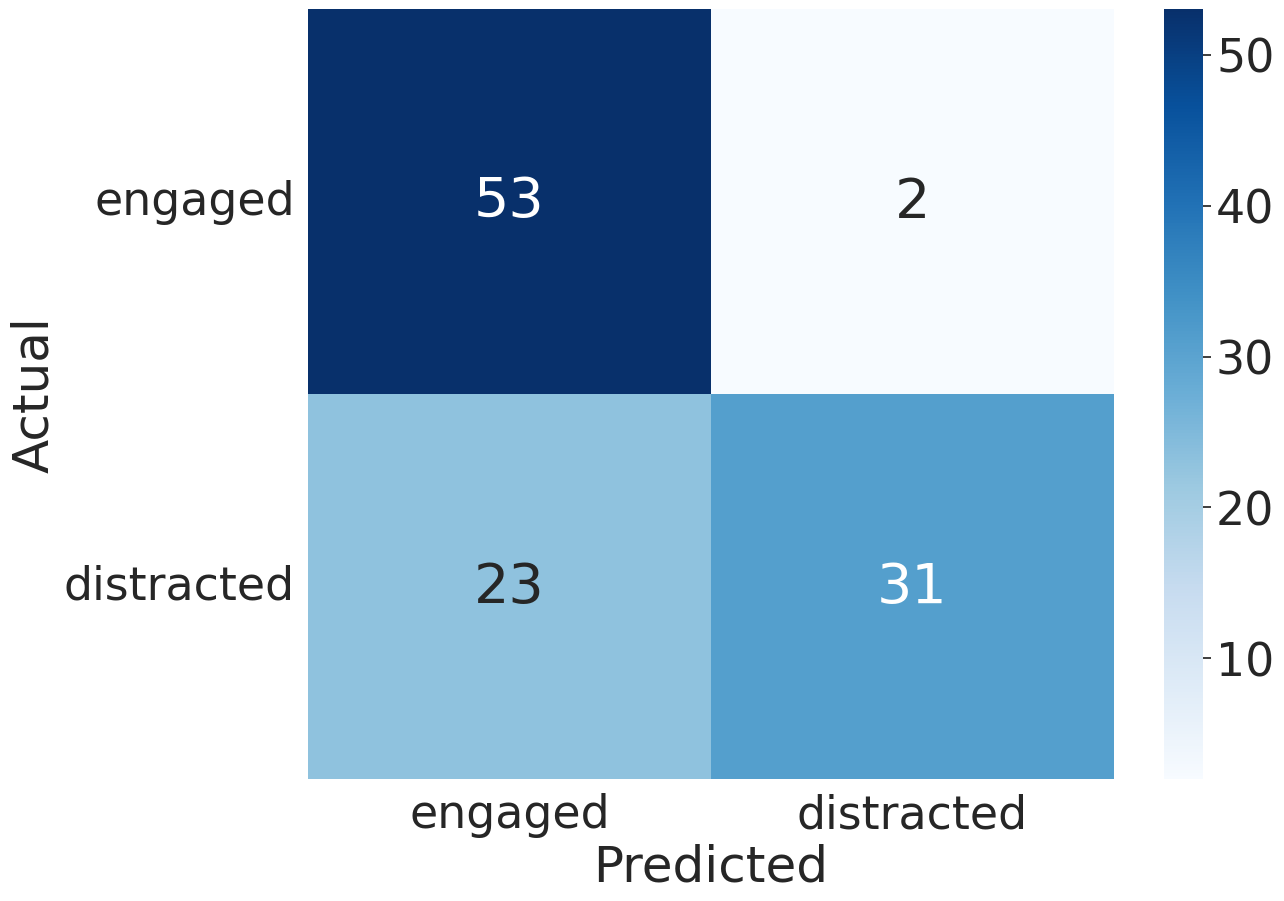

In [135]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [136]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [137]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.7454545454545454, MSE: 0.2545454545454545, UAR: 0.7454545454545456, Recall: 0.7272727272727273, Precision: 0.8127450980392157, F1: 0.7048096830705527
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8, Precision: 0.9175000000000001, F1: 0.8344652480875391
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8, Precision: 0.9175000000000001, F1: 0.8344652480875391
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.7818181818181819, Precision: 0.9375, F1: 0.8314577292905467
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7818181818181819, Precision: 0.9175000000000001, F1: 0.8239890576113487
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.7454545454545455, Precision: 0.9375, F1: 0.7980506822612086
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8272727272727274, MSE: 0.17272727272727273, UAR: 0.8272727272727274, Recall: 0.7454545454545455, Precision: 0.9375, F1: 0.804805068226121
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7636363636363637, Precision: 0.9375, F1: 0.8085268727373991
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8, Precision: 0.9375, F1: 0.8430366766589676
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7818181818181819, Precision: 0.9375, F1: 0.8325604861827772


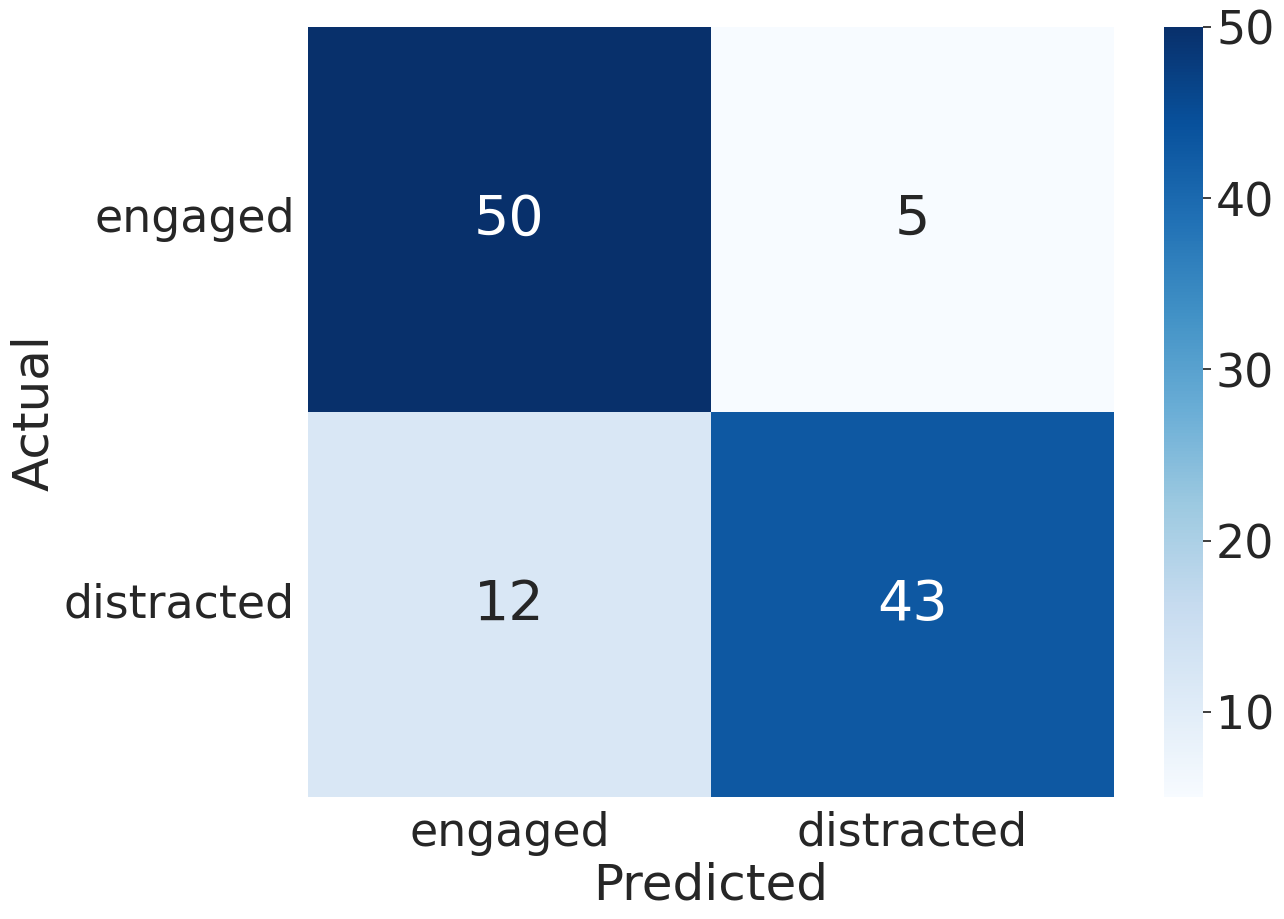

In [138]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [139]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_1
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_1
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8181818181818183, MSE: 0.1818181818181818, UAR: 0.8181818181818183, Recall: 0.8, Precision: 0.8605128205128205, F1: 0.8037545787545788
Videos num:  4_1
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7272727272727273, Precision: 0.95, F1: 0.812151008381995
Videos num:  1_2
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_2
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_2
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.7818181818181819, Precision: 0.888080808080808, F1: 0.8083433233433233
Videos num:  4_2
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7636363636363637, Precision: 0.9538461538461538, F1: 0.8351614329942503
Videos num:  1_3
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_3
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_3
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7818181818181819, Precision: 0.9103030303030304, F1: 0.8167643759749023
Videos num:  4_3
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.7454545454545455, Precision: 0.9538461538461538, F1: 0.8222959359182269
Videos num:  1_4
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818183, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.34545454545454546, Precision: 0.32941176470588235, F1: 0.32556390977443617
Videos num:  2_4
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_4
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.8, Precision: 0.9133333333333333, F1: 0.8270410558167995
Videos num:  4_4
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.7636363636363637, Precision: 0.9466666666666667, F1: 0.8248600384823295
Videos num:  1_5
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818183, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.34545454545454546, Precision: 0.32941176470588235, F1: 0.32556390977443617
Videos num:  2_5
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_5
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.7818181818181819, Precision: 0.9103030303030304, F1: 0.8167643759749023
Videos num:  4_5
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.7636363636363637, Precision: 0.9428571428571428, F1: 0.8284947663275837
Videos num:  1_6
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_6
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_6
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8, Precision: 0.8703030303030304, F1: 0.8102480852480852
Videos num:  4_6
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7818181818181819, Precision: 0.9428571428571428, F1: 0.8428738512949041
Videos num:  1_7
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_7
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_7
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.888080808080808, F1: 0.8178671328671328
Videos num:  4_7
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7636363636363637, Precision: 0.9538461538461538, F1: 0.8351614329942503
Videos num:  1_8
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818183, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.34545454545454546, Precision: 0.32941176470588235, F1: 0.32556390977443617
Videos num:  2_8
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_8
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8, Precision: 0.888080808080808, F1: 0.8178671328671328
Videos num:  4_8
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7818181818181819, Precision: 0.9428571428571428, F1: 0.8428738512949041
Videos num:  1_9
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818183, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.34545454545454546, Precision: 0.32941176470588235, F1: 0.32556390977443617
Videos num:  2_9
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_9
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8272727272727274, MSE: 0.1727272727272727, UAR: 0.8272727272727274, Recall: 0.8, Precision: 0.8703030303030304, F1: 0.8102480852480852
Videos num:  4_9
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7818181818181819, Precision: 0.9428571428571428, F1: 0.8428738512949041
Videos num:  1_10
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818183, MSE: 0.38181818181818183, UAR: 0.6181818181818183, Recall: 0.34545454545454546, Precision: 0.32941176470588235, F1: 0.32556390977443617
Videos num:  2_10
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.5818181818181818, Precision: 0.7428571428571429, F1: 0.6141353383458646
Videos num:  3_10
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8, Precision: 0.9103030303030304, F1: 0.8262881854987117
Videos num:  4_10
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.7636363636363637, Precision: 0.9428571428571428, F1: 0.8284947663275837


In [140]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))

#### Balanced split

In [141]:
split_name = 'balanced_best'

In [142]:
#metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name)
results_agg = {
    'metric_name': [
        #metric_name + "_accuracy",
        #metric_name + "_mse",
        #metric_name + "_uar",
        #metric_name + "_recall",
        #metric_name + "_precision",
        #metric_name + "_f1",
        "accuracy",
        "mse",
        "uar",
        "recall",
        "precision",
        "f1",
    ],
}

##### User-independent model

In [143]:
_, test_files = get_custom_dataset_split(1, list(eng_file2features.keys()), list(dis_file2features.keys()))
_, filename2features_test = get_train_test_dict([], test_files, eng_file2features, dis_file2features)

In [144]:
actor2feat_label_test = associate_with_name(filename2features_test)

In [145]:
X_subsample_test, y_subsample_test = get_samples(filename2features_test)
FEATURE_VECTOR_DIM=X_subsample_test.shape[-1]

(88, 128, 3072) (88,)


In [146]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3073      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

In [147]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name, split_name)
weights_path = WEIGHTS_DIR + '{}.h5'.format(universal_metric_name)

In [148]:
load_weights(modelAtn, weights_path)
base_model_weights = modelAtn.get_weights()

In [149]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in actor2feat_label_test.keys():
    print(k, ":", len(actor2feat_label_test[k]))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, k, 0)
    pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])

    p = prediction2bin(pred, THRESHOLD)

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name)
    all_preds.extend(p)
    all_labels.extend(test_labels)
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(actor2feat_label_test.keys())
total_mse /= len(actor2feat_label_test.keys())
total_uar /= len(actor2feat_label_test.keys())
total_recall /= len(actor2feat_label_test.keys())
total_precision /= len(actor2feat_label_test.keys())
total_f1 /= len(actor2feat_label_test.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", 0)
results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Den : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_balanced_best_Den_0 Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.5454545454545454 Precision:  0.8571428571428571 F1:  0.6666666666666665
Kate : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_balanced_best_Kate_0 Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Yana : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_balanced_best_Yana_0 Accuracy:  0.8571428571428571 MSE:  0.14285714285714285 UAR:  0.8545454545454545 Recall:  0.8 Precision:  0.8888888888888888 F1:  0.8421052631578948
Egor : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_balanced_best_Egor_0 Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_balanced_best_Katya_0 Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Total, accuracy: 0.8077922077922078, MSE: 0.19220779220779222, UAR: 0.8072727272727273, Recall: 0.6872727272727273, Precision: 0.9092063492063491, F1: 0.7781119465329991


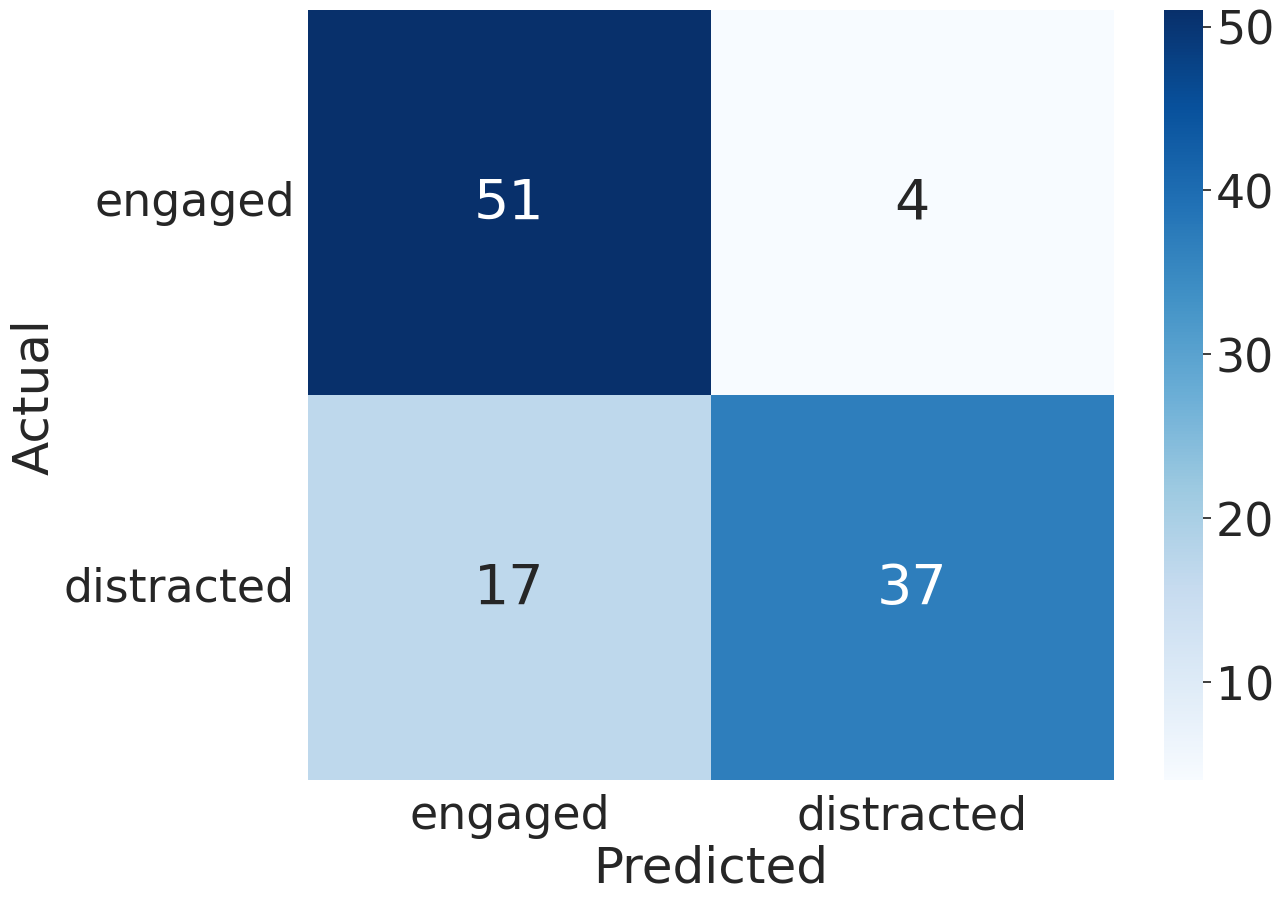

In [150]:
draw_confusion_matrix(all_preds, all_labels)

##### User-adapted model

In [151]:
train_files, test_files = get_custom_dataset_split(TRAIN_VIDEOS_COUNT, list(eng_file2features.keys()), list(dis_file2features.keys()))
filename2features_train, filename2features_test = get_train_test_dict(train_files, test_files, eng_file2features, dis_file2features)
actor2feat_label_train = associate_with_name(filename2features_train)
actor2feat_label_test = associate_with_name(filename2features_test)

In [152]:
for rep in range(1, REPEAT + 1):
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    all_preds = []
    all_labels = []
    ID = "{}_{}".format(TRAIN_VIDEOS_COUNT, rep)
    #history = {}
    for actor in actor2feat_label_test.keys():
        modelAtn.set_weights(base_model_weights)
        print("Actor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
        X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
        #X_subsample_test,y_subsample_test=get_samples(actor2feat_label_test[actor])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))
        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=20, verbose=1, callbacks=[save_best_model],
            #                                                 validation_data=(X_subsample_test,y_subsample_test))
            #best_model_weights = save_best_model.best_model_weights
            #modelAtn.set_weights(best_model_weights)
            save_weights(modelAtn, weights_name)
    
        pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
        p = prediction2bin(pred, THRESHOLD)
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
        all_preds.extend(p)
        all_labels.extend(test_labels)
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1
    
    total_acc /= len(actor2feat_label_test.keys())
    total_mse /= len(actor2feat_label_test.keys())
    total_uar /= len(actor2feat_label_test.keys())
    total_recall /= len(actor2feat_label_test.keys())
    total_precision /= len(actor2feat_label_test.keys())
    total_f1 /= len(actor2feat_label_test.keys())
    print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
    results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]



Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.7818181818181819, Precision: 0.9244444444444444, F1: 0.8226518218623481
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7636363636363637, Precision: 0.9571428571428571, F1: 0.8195087719298246
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7636363636363637, Precision: 0.9571428571428571, F1: 0.8195087719298246
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457
Actor Den
(9, 128, 3072) (9,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Kate
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Yana
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Egor
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Actor Katya
(10, 128, 3072) (10,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7818181818181819, Precision: 0.9571428571428571, F1: 0.8310877192982457


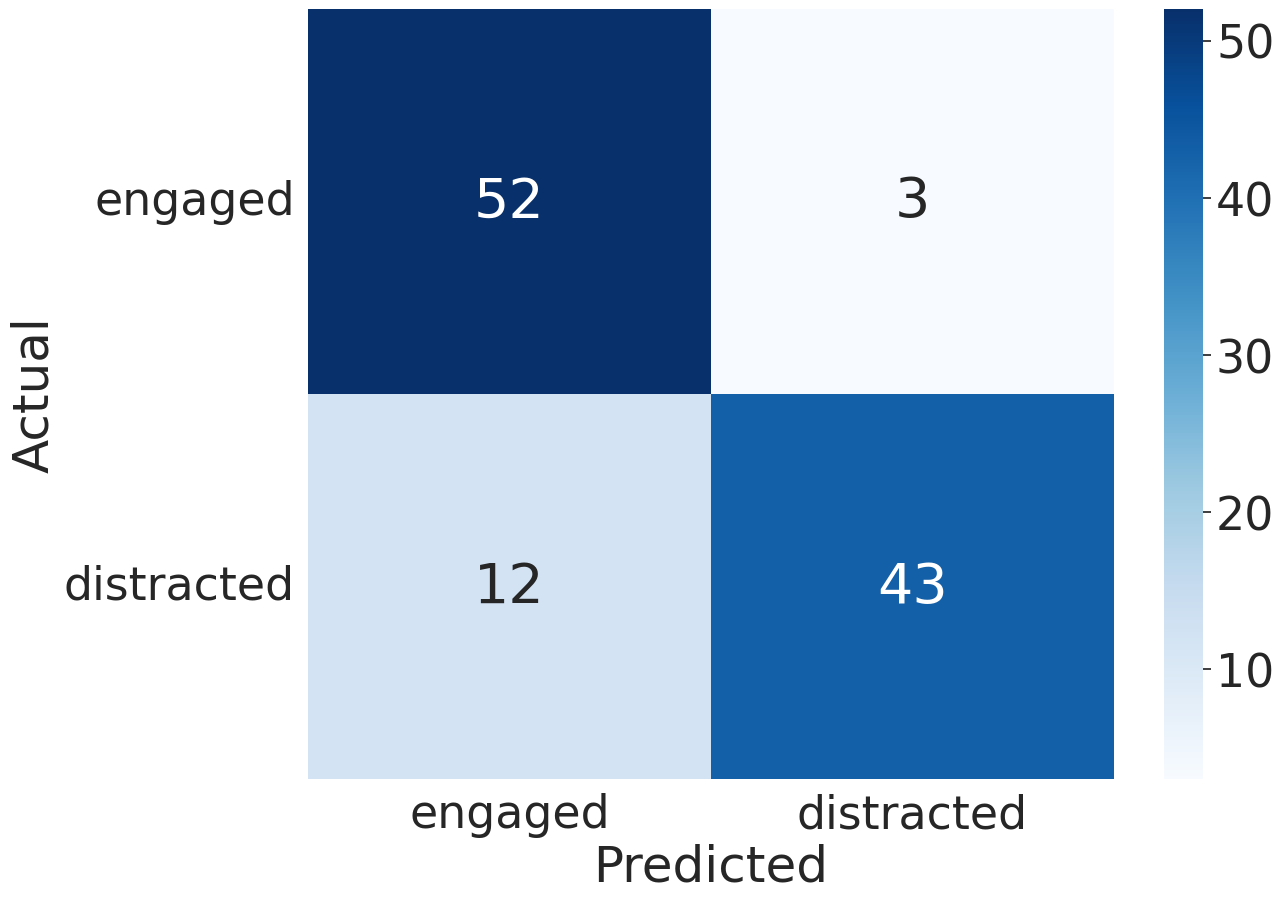

In [153]:
draw_confusion_matrix(all_preds, all_labels)

###### Adaptation by number of videos

In [154]:
from copy import deepcopy

actor2feat_label_test = associate_with_name(filename2features_test)
#subsample_test = {}
#for actor in actor2feat_label_test.keys():
#    x, y = get_samples(actor2feat_label_test[actor])
#    subsample_test[actor] = (x, y)

for rep in range(1, REPEAT + 1):
    for i in range(1, TRAIN_VIDEOS_COUNT):
        train_files, _ = get_custom_dataset_split(i, list(eng_file2features.keys()), list(dis_file2features.keys()))
        filename2features_train, _ = get_train_test_dict(train_files, [], eng_file2features, dis_file2features)
        actor2feat_label_train = associate_with_name(filename2features_train)
        total_acc = 0
        total_mse = 0
        total_uar = 0
        total_recall = 0
        total_precision = 0
        total_f1 = 0
        ID = "{}_{}".format(i, rep)
        print("Videos num: ", ID)
        for actor in actor2feat_label_test.keys():
            modelAtn.set_weights(base_model_weights)
            print("\t\tActor {}".format(actor))
            metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, actor, ID)
            X_subsample_train,y_subsample_train=get_samples(actor2feat_label_train[actor])
            #X_subsample_test,y_subsample_test=subsample_test[actor]
    
            weights_name = get_weights_path(metric_name)
            if os.path.isfile(weights_name):
                load_weights(modelAtn, weights_name)
            else:
                modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
                #history[actor] = modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
                #                                                 validation_data=(X_subsample_test,y_subsample_test))
                #best_model_weights = save_best_model.best_model_weights
                #modelAtn.set_weights(best_model_weights)
                save_weights(modelAtn, weights_name)
        
            pred, test_labels = get_prediction(modelAtn, actor2feat_label_test[k])
            p = prediction2bin(pred, THRESHOLD)
        
            #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
            acc, mse, uar, recall, precision, f1 = print_results(p, test_labels, metric_name=metric_name, print_info=False)
            total_acc += acc
            total_mse += mse
            total_uar += uar
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    
        total_acc /= len(actor2feat_label_test.keys())
        total_mse /= len(actor2feat_label_test.keys())
        total_uar /= len(actor2feat_label_test.keys())
        total_recall /= len(actor2feat_label_test.keys())
        total_precision /= len(actor2feat_label_test.keys())
        total_f1 /= len(actor2feat_label_test.keys())
        print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
        # if TABLE_NAME is not None:
        #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
        #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, split_name, "all", ID)
        results_agg[metric_name] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1_1
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.37272727272727274, UAR: 0.6272727272727273, Recall: 0.32727272727272727, Precision: 0.3466666666666667, F1: 0.3247863247863248
Videos num:  2_1
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.5818181818181818, Precision: 0.75, F1: 0.6316094584286803
Videos num:  3_1
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9800000000000001, F1: 0.8625396825396827
Videos num:  4_1
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7636363636363637, Precision: 0.9800000000000001, F1: 0.8509607351712616
Videos num:  1_2
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6272727272727273, MSE: 0.37272727272727274, UAR: 0.6272727272727273, Recall: 0.32727272727272727, Precision: 0.3466666666666667, F1: 0.3247863247863248
Videos num:  2_2
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_2
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9666666666666668, F1: 0.8506450696220517
Videos num:  4_2
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.8222025652366209
Videos num:  1_3
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.32727272727272727, Precision: 0.3375, F1: 0.31851851851851853
Videos num:  2_3
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_3
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9800000000000001, F1: 0.8625396825396827
Videos num:  4_3
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.820405179615706
Videos num:  1_4
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.32727272727272727, Precision: 0.3375, F1: 0.31851851851851853
Videos num:  2_4
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_4
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9800000000000001, F1: 0.8625396825396827
Videos num:  4_4
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.820405179615706
Videos num:  1_5
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.32727272727272727, Precision: 0.3375, F1: 0.31851851851851853
Videos num:  2_5
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_5
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7636363636363637, Precision: 0.9800000000000001, F1: 0.8481605975723623
Videos num:  4_5
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.820405179615706
Videos num:  1_6
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6, MSE: 0.4, UAR: 0.6, Recall: 0.32727272727272727, Precision: 0.32222222222222224, F1: 0.30727969348659007
Videos num:  2_6
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_6
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.7818181818181819, Precision: 0.9800000000000001, F1: 0.8625396825396827
Videos num:  4_6
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.820405179615706
Videos num:  1_7
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.32727272727272727, Precision: 0.3375, F1: 0.31851851851851853
Videos num:  2_7
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_7
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7818181818181819, Precision: 0.9636363636363636, F1: 0.8547474747474748
Videos num:  4_7
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.820405179615706
Videos num:  1_8
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_8
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_8
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9666666666666668, F1: 0.8650241545893721
Videos num:  4_8
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.7272727272727273, Precision: 0.9800000000000001, F1: 0.820405179615706
Videos num:  1_9
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6181818181818182, MSE: 0.38181818181818183, UAR: 0.6181818181818182, Recall: 0.32727272727272727, Precision: 0.3375, F1: 0.31851851851851853
Videos num:  2_9
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_9
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.8, Precision: 0.9666666666666668, F1: 0.8650241545893721
Videos num:  4_9
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545453, Recall: 0.7090909090909091, Precision: 0.9800000000000001, F1: 0.8060260946483858
Videos num:  1_10
		Actor Den
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Kate
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Yana
(1, 128, 3072) (1,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.6090909090909091, MSE: 0.39090909090909093, UAR: 0.6090909090909091, Recall: 0.32727272727272727, Precision: 0.32941176470588235, F1: 0.31269841269841275
Videos num:  2_10
		Actor Den
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(3, 128, 3072) (3,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(2, 128, 3072) (2,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))
/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


		Actor Egor
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.7818181818181819, MSE: 0.21818181818181817, UAR: 0.7818181818181819, Recall: 0.5818181818181818, Precision: 0.78, F1: 0.6465162907268172
Videos num:  3_10
		Actor Den
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(4, 128, 3072) (4,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.7636363636363637, Precision: 0.9800000000000001, F1: 0.8481605975723623
Videos num:  4_10
		Actor Den
(7, 128, 3072) (7,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Kate
(6, 128, 3072) (6,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Yana
(5, 128, 3072) (5,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Egor
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


		Actor Katya
(8, 128, 3072) (8,)


/media/deelvin_disk/echuraev/tmp_dir/ipykernel_1766056/1345145130.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(pred[0]))


	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.7454545454545455, Precision: 0.9800000000000001, F1: 0.8365816502039412


In [155]:
dump_to_table(TABLE_NAME, result_agg_dict2lines_row(results_agg))